# Week Four - Parameter Estimation and Fitting Data

<hr style="border:2px solid gray">
<a id='outline'></a>

# Outline

1. [Introduction to Estimation](#section1)
1. [Fitting](#section2)
1. [Parameter Uncertainty Intervals](#section3)
1. [Curve Fitting Using Least Squares and iminuit](#section4)
1. [Curve Fitting and Binning, Maximum Liklihood and iminuit](#section5)
1. [Exercises](#exercises)
1. [Appendix](#appendix)

#### Prelude

In one sense, all of machine learning including AI (whatever that difference is) is really about applying some function to your data and finding the "best" values for the parameters in your functions. This could be the weights in the links in the neural network (the function here is not in a standard form we know) or,as you have done before, it could be fitting a curve to data (as in the the polynomial examples below).  The terminology may be different, the measures we use to define what is the "best" fit may be new, some methods (neural nets) are only just coming into their own while hardware improvements open up new options, but really this has been going on for centuries. 

This week we start with curve fitting as the classic example of machine learning. In future weeks we will be looking at different types of problem but the basic principles are the same. 

#### Before you start

<img src="Week4_plots/logo_iminuit.png" alt="iminuit logo" class="bg-primary" width="200px">

This week we will be using the [`iminuit`](https://iminuit.readthedocs.io/) Python library to fit curves to data. This is the python interface for a fast minimiser based on a `C++` library maintained by CERN. It is comprehensive (unlike `scipy.optimize.curve_fit`) so for any scientist it is well worth the extra effort.

The `iminuit` library does not usually come installed with python. On the PC's in the Physics computing lab, you should find it is present and working. If you  are on your own machine, please read the [`iminuit` installation instructions](https://iminuit.readthedocs.io/en/stable/install.html). The teaching team had some trouble with permissions on a directory used for temporary files in the Physics lab installation so if you are using a Windows machine, beware of this.

The first thing you should do once you have installed it is to run the next code cell which acts as a quick check that `iminuit` is installed and running on your machine.

In [2]:
#Check iminuit
import iminuit 
print("iminuit version is "+str(iminuit.__version__))

from iminuit.cost import LeastSquares 
print(LeastSquares)

iminuit version is 2.30.1
<class 'iminuit.cost.LeastSquares'>


<hr style="border:2px solid gray">
<a name="section1">

# Section One: Introduction to Estimation [^](#outline)

In physics, it is common that we have a theory for a process which contains some parameters whose values are not known. For example Newton's law of gravity has one unknown constant $G$ while the standard model of particle physics has over twenty. 

We may do some experiment to try to determine if the theory is a good description of nature (Hypothesis testing) but first, we may need to find values for the unknown parameters in our theory. For example, in particle physics there are many experiments we can do to see if the standard model with our current best parameter values (a null model) is consistent with data and at the same time theorists have many suggestion for new physics which leads to a new model of particle physics (an alternative hypothesis) and we need to know the parameters in the alternative model. The data taken in experiments such as those at the LHC is used to both test if a given theory is compatible with nature, and to make estimates of the parameters of that theory.

Determining the values of these model parameters is referred to as **estimation** and is one of the most important applications of statistics in science. In the previous two weeks, we saw that hypothesis tests aim to answer the question "Is this particular model consistent with the data?". In this case, we always had some fixed model that we were testing. This week, we instead want to answer "What value of the parameter is *most* consistent with the data?". You can think of this as being a **continous** test for a family of hypotheses that are identified with different values of one (or more) parameter(s). 

There are many ways we can estimate a parameter value from a set of data that we have measured. The objective is to find some function $M$ of the measurements $X_i$ that gives an estimate of the value of some parameter $\theta$, 

\begin{equation*}
\hat{\theta} = M(X_1, \cdots, X_N)
\end{equation*}

Specific methods of estimation specify what this function $M$ looks like. Different parameter estimation methods are used in different situations and we will briefly cover two major methods in this workbook.

Note that we denote the estimate of a parameter with a "hat" as $\hat{\theta}$ to distinguish it from the true but unknown value of that parameter $\theta$. This is because our estimate $\hat{\theta}$ is a function of random variables so our estimate $\hat{\theta}$ is itself a random variable. 



#### Example

Let us consider a linear relationship where $y=X$ for a given set of values for the independent variable $X$ while we add some Gaussian noise to the values of the dependent variable $y$ to simulate experimental noise. We want to fit this data with a straight line, with equation $y = mX$.  Note we will focus on just one parameter for now. We can try several different values of the parameter $m$ by hand and just by eye judge which line fits the data best. We will generate this data using `numpy.random`:

In [3]:
import numpy as np
np.random.seed(1) # Set the random seed for consistency

X = np.linspace(0,10,20) # For simplicity these X values are not chosen randomly (they could have been) but are equally spaced 

y = X + np.random.default_rng().normal(loc = 0, scale = 0.5, size = len(X)) # Add Gaussian noise, mean 0, std.dev 0.5

Let us consider 3 possible values of $m$: 0.8, 1, and 1.2. The three straight lines with these parameter values are shown against the data in the plot below. Note each measurement is a single data point and we have no information on the uncertainty in the measurement from the data so we can not add error bars to points.

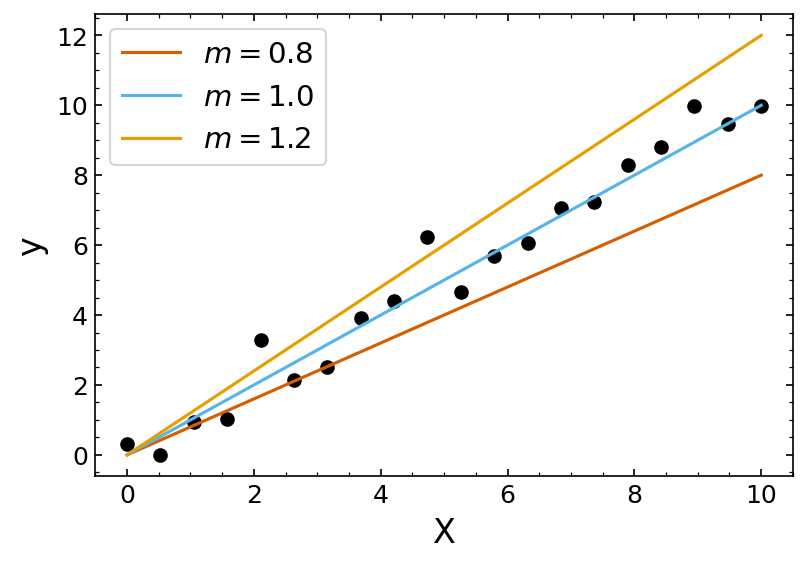

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

gradients = [0.8,1,1.2] # Define gradient parameters
colors = ['#D55E00','#56B4E9','#E69F00'] # Define colours

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(X,y,color='black')
for m,c in zip(gradients,colors):
    ax.plot(X,m*X,c=c,label='$m = {:.1f}$'.format(m))

ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
ax.legend(loc='upper left',fontsize = 14)
ax.tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))


Is it clear that $m = 1$ (the true underlying form) is the best choice of parameter? Try another seed to see if your answer changes.

Maybe it is clear on your computer, maybe not. For me, with random seed zero, I found slightly more circles intersected the $m=0.8$ line than the $m=1.0$ line while few were on the $m=1.2$ line. Most of the issue was at low $X$ values (EFS why?). Repeating with seed=1 the $m=1.0$ line was the best but still very unclear at low $X$.

Of course, in general we can't practically test different parameter values visually to fit your data, and in science what we really want to extract is the specific value of the fit that best describes the data. This is where we need other tools to estimate our parameters.

#### Good estimates

Many methods of estimation exist, where some are better than others. Good estimates are:

1. Consistent: in the limit of large N, $\hat{\theta} \to \theta$ i.e. the estimate converges to the true value
<br>

1. Unbiased: $E(\hat{\theta})  = \theta$ i.e. the expectation of the estimate equals the true value
<br>

1. Efficient: $V(\hat{\theta})$ is small, i.e. the variance in the estimate is small.

The expectation value $E(\ldots)$ and the variance $V(\ldots)$ shown here come from where we imagine that same identical experiment is done by many different people. The expectation and variance is found by looking at how the results vary from person to person. 

<div style="background-color: #FFF8C6">

The expectation value $E(\ldots)$ and the variance $V(\ldots)$ referred to above are theoretical results in the sense that if we really had repeated the experiment $N$ times, we would combine all the data to get better estimates of the parameters. 

However you could imagine that the experiment is to measure Newton's constant of gravity $G$ which is done by a lab full of $N$ physicists.  Each student $i$ hands in their lab book with their estimate of $G_I$ and does not improve this with the results obtained by other students. The HoL (Head of Lab) could do an analysis which should show the mean of all the student's results was closer to the best current estimate of $G$. More interestingly, by using all the student results, the HoL could estimate the standard deviation $\hat{\sigma}$ for the experiments (again, not the true value but an estimate).  Now the HoL can look to see if there is any student whose result is so far off it can not be explained by statistical uncertainty, i.e. something went wrong with that experiment.  

#### Example: finding the mean of data is an estimate

One of the most common methods of estimation that you may not have realised is formally an estimate: finding the mean of a set of measurements.

\begin{equation*}
\hat{\mu} = \frac{1}{N}\sum_{i = 1}^N X_i
\end{equation*}

In this example the function $M$ is the sum of the measurements, divided by the number of measurements made. We have put a hat on the symbol "mu" used here for the mean. That is because if the $X_i$ are random variables then their sum has some probability distribution which has a precise mean, denoted $\mu$ without a hat. The mean of the data is being used to estimate the true mean $\mu$ of the underlying distribution.

The method of estimating the mean that we have shown above is consistent, unbiased and efficient, its is a good estimator. However, it is obviously only applicable for finding the mean, rather than any parameter in general. This workbook will discuss two different methods of more generally estimating parameters of distributions or functions from data; namely, using the chi-squared and maximum likelihood estimators. The former is typically best applied for measurements made of variables with at least approximately Gaussian distributions, whereas the maximum likelihood method can be applied for any probability distribution. 

Both of these methods involve finding parameter values to maximise or minimise some function, and are referred to as **fitting**. 

## Summary

In this section, we have introduced the concept of parameter estimation, including:

* Best estimates of parameters
* Properties of good estimates

In the following section, we will discuss the concept of fitting: optimising some function to find the best possible parameter values for our data.

<hr style="border:2px solid gray">
<a id='section2'></a>

# Section Two: Fitting [^](#outline)


In order to find the best estimates of parameters, one of the most common methods is fitting. To do this, we define some **cost function** (often called a **loss function** in machine learning) of our data and our proposed model (and associated parameters) and we aim to maximise or minimise this function, depending on the specific choice of function. You will see this concept again many times as we discuss machine learning in the rest of this course.

As previously mentioned, we will discuss two different methods with different cost functions; we will start with the most familiar, the chi-squared method.

## The chi-squared estimation method

Recalling last week, we discussed the $\chi^2$ value as a method for determining the compatibility of a given model to some experimental data, where we hypothesise the data is distributed with some Gaussian noise about the model prediction and test whether the measurements are consistent with that hypothesis. 

However, we can take this concept one step further, and instead try to optimise the value of $\chi^2$ by choosing different parameter values $\theta$ (for simplicity we assume one parameter for now). We will assume that we want the smallest value of $\chi^2$ (but see warnings about problems when $\chi^2 \ll N_\mathrm{dof}$) so

* Consider some data $\{X_i\}$ that we hypothesise is modelled by some function $f(X_i; \theta)$ with one parameter $\theta$
* By finding a minimum of the $\chi^2$ with respect to $\theta$, we can choose the best estimate $\hat{\theta}$ to describe our data
* To minimise $\chi^2$ with respect to $\theta$, we require:
\begin{align*}
\frac{\partial\chi^2}{\partial\theta} &= 0 \\
\frac{\partial^2 \chi^2}{\partial\theta^2} &\gt 0
\end{align*}

where the first condition requires that we are at a stationary point of the $\chi^2$ function with respect to $\theta$, and the second condition requires that said stationary point is a minimum.

We can apply the same setup for a model with a set of multiple parameters $\{\theta_j\}$, where we require that

\begin{align*}
\frac{\partial\chi^2}{\partial\theta_j} &= 0 \\
\frac{\partial^2\chi^2}{\partial\theta_j^2} &\gt 0
\end{align*}
for all $j$. For $N$ parameters, we must solve these $2N$ equations simultaneously to find our best estimate of each parameter, where the best estimate of parameter $\theta_j$ is denoted as $\hat{\theta_j}$.

We will discuss how we can actually solve this optimisation problem in general later in this workbook.

## The maximum likelihood estimation method

In some experiment, we may know that our results should be distributed according to some probability density function $f(X; \theta)$ but with some unknown parameter $\theta$. In this scenario, we know the functional form of the PDF but not the specific parameter value. We want to do some experiment to determine the value of $\theta$. 

After we make a series of N measurements, we have some data points $X_i$ that are samples from whatever probability distribution underlies the quantity we are measuring. We can therefore define the total probability of our measurements as the product of the probablity of each individual measurement, i.e. as

$$
L(\theta; X_i) = \prod_{i = 1}^Nf(X_i;\theta),
$$

where $L(\theta; X_i)$ is the **likelihood function** for our experiment. As we saw last week, the likelihood function assumes a fixed data set and instead it is a function of the parameter $\theta$. Remember, this means the likelihood function is *not* a PDF for $\theta$, and is only proportional to the probability of $\theta$ being the correct value given the measurements $X_i$, so $\int L(\theta; X_i) d\theta \neq 1$ in general.

As with likelihood ratios, it is often more convenient to use the **log-likelihood** function to avoid dealing with very small numbers in products 

$$

\ln L(\theta; X_i) = \sum_{i = 1}^N\ln f(X_i;\theta),
$$


#### Example

For example, let us consider an experiment where we have a bag of coloured balls. We pull a ball out, note the colour and then return it to the bag. We do this ten times (ten "trials") and the  colour of the balls is r,B,r,r,B,r,r,r,B,r where r indicates a red ball and B is a blue ball. Here $X_i$ is the colour of the ball we pull out on the i-th attempt so $X_1=r$ and $X_9=B$. 
We want to estimate the probability $p$ of pulling out a blue ball on any one attempt, i.e. the fraction of blue balls in the bag. 

The obvious model to use is a binomial model as there are only two outcomes we are interested in: blue ball or not a blue ball. We will call our parameter $p$ here. Our $f(X,p)$ is the probability (not a probability density) that if there are a fraction $p$ blue balls in the bag then we get result $X=B$ with probability $p$ and result $X=\tilde B$ (not B) with probability $(1-p)$. That is

$$
 f(X;p) =  p
 $$ 
 
if $X=B$

$$
 f(X;p) = (1-p) 
$$

if $X = \tilde B$

So in our case the likelihood is given as

$$
L(\theta; \boldsymbol{X}) \equiv L(p; (r,B,r,r,B,r,r,r,B,r) ) = f(X_1;p)f(X_2;p) \ldots f(X_{10};p) 
                =(1-p).p.(1-p).(1-p).p.(1-p).(1-p).(1-p).p.(1-p) 
                = p^3(1-p)^7
$$

The cell below plots this likelihood, as a function of $p$. 

Integral of L(p) between 0 and 1 = 0.0007575757575757576


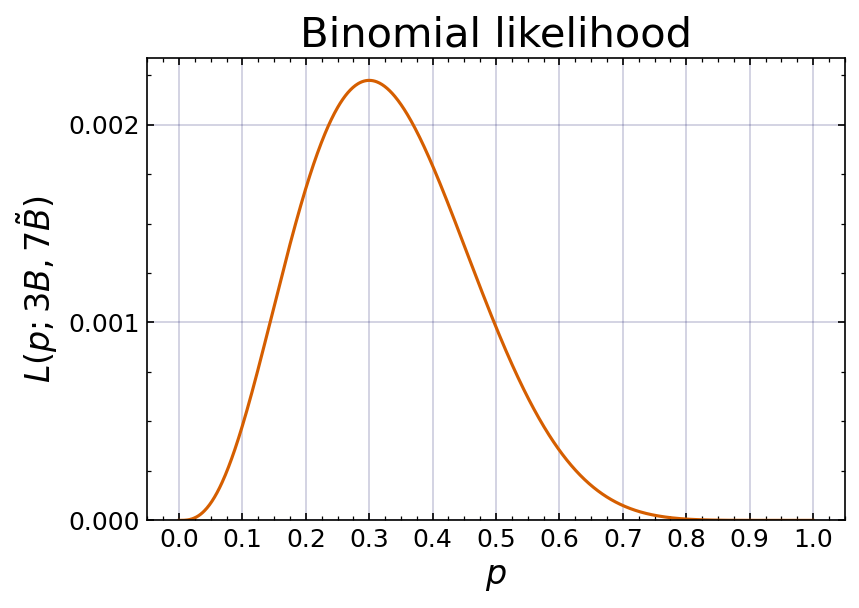

In [5]:
def L(p):
    return p**3*(1 - p)**7

p = np.linspace(0,1,1000)
L_p = L(p)

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.plot(p,L_p,color='#D55E00')
ax.set_xlabel('$p$',fontsize = 16)
ax.set_ylabel(r'$L(p; 3B, 7\tilde B)$',fontsize = 16)
ax.tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_major_locator(MultipleLocator(0.001))
ax.yaxis.set_minor_locator(MultipleLocator(0.00025))
ax.set_ylim(bottom = 0)
ax.set_title('Binomial likelihood',fontsize = 20)
ax.grid(color='xkcd:dark blue',alpha =0.2)

# Lazy check to show this liklihood for p is not normalised, you can do this integral exactly!
import scipy.integrate as integrate
result = integrate.quad(L, 0, 1.0)
print("Integral of L(p) between 0 and 1 = "+str(result[0]))

Our common sense suggests that our estimate for $p$, denoted $\hat{p}$, would equal the frequency of blue balls found in our experiment, that is $\hat{p} = 3/10 = 0.3$. We can now see that our more sophisticated likelihood gives exactly this results, namely that the liklihood function peaks at $0.3$. The value of $p$ that gives the maximum likelihood, which therefore maximises the probability of observing the data we have measured, gives a sensible estimate for $p$. 

In practice, we will take logarithms of likelihood functions to produce the **log-likelihood**, because this is more numerically stable for computing values, particularly for binned measurements with many bins. Because the logarithm is a monotonically increasing function, the maximum of $L(\theta)$ is at the same value of $\theta$ as the maximum of $\ln(L(\theta))$ and so we can use $\ln(L)$ for all calculations. The code cell below plots the log-likelihood for the binomial example.

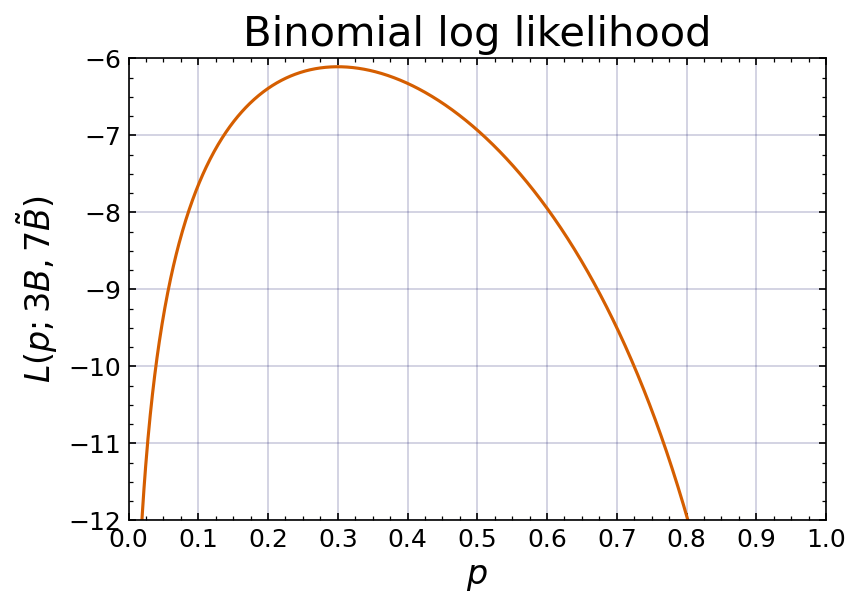

In [6]:
p2 = np.linspace(0.01,0.82,1000) # limit range to avoid log(0.0) 
L_p2 = L(p2)

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.plot(p2,np.log(L_p2),color='#D55E00')
ax.set_xlabel('$p$',fontsize = 16)
ax.set_ylabel(r'$L(p; 3B, 7\tilde B)$',fontsize = 16)
ax.tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlim(0.0,1.0)
ax.set_ylim(-12,-6)
ax.set_title('Binomial log likelihood',fontsize = 20)
ax.grid(color='xkcd:dark blue',alpha =0.2)

<div style="background-color: #FFF8C6">

EFS: What if in our ten trials we found r,B,g,g,B,r,g,r,B,r where "g" represents a green ball pulled from the bag? Would our estimate for the probability of pulling out a blue ball change from $\hat{p} = 3/10 = 0.3$?

What happens if we make more trials of this experiment, and find we see the outcome 30 times out of 100? Again we would expect our estimate $\hat{p}$ to be equal to 0.3 (30/100), but we would expect to be more confident in that measurement. We can see this in the likelihood and log-likelihood functions in the plots below. Both of these peak at $p = 0.3$ as expected but now they are much more sharply peaked at this value. We therefore expect the width of the likelihood function to be correlated with the error on the estimated parameter value. We will discuss this in Section Three. 

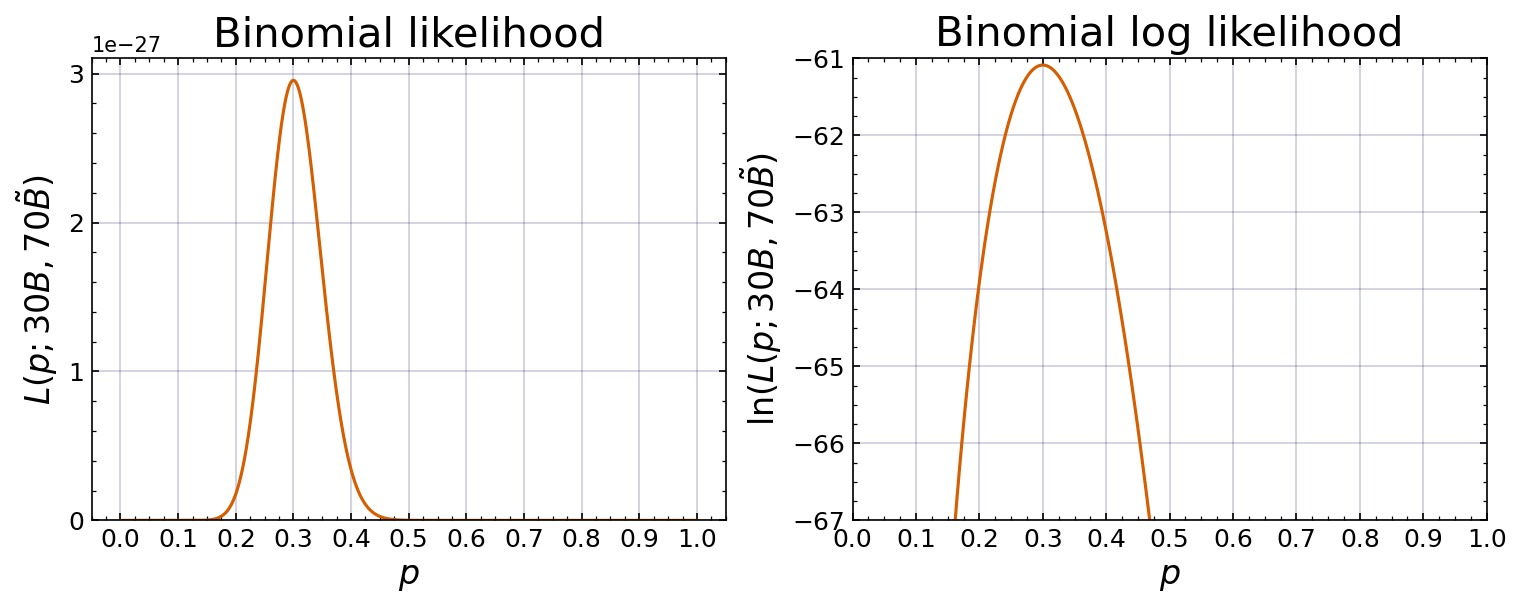

In [7]:
def L100(p):
    return p**30*(1-p)**70

fig, axs = plt.subplots(1,2,figsize = (12,4),dpi = 150)
axs[0].plot(p,L100(p),color='#D55E00')
axs[0].set_xlabel('$p$',fontsize = 16)
axs[0].set_ylabel(r'$L(p; 30B, 70\tilde{B})$',fontsize = 16)
axs[0].tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
axs[0].xaxis.set_major_locator(MultipleLocator(0.1))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.025))
axs[0].yaxis.set_major_locator(MultipleLocator(1e-27))
axs[0].yaxis.set_minor_locator(MultipleLocator(2e-28))
axs[0].set_ylim(bottom = 0)
axs[0].set_title('Binomial likelihood',fontsize = 20)
axs[0].grid(color='xkcd:dark blue',alpha =0.2)

p3 = np.linspace(0.1,0.5,100) # Limit range due to overflows
axs[1].plot(p3,np.log(L100(p3)),color='#D55E00')
axs[1].set_xlabel('$p$',fontsize = 16)
axs[1].set_ylabel(r'$\ln(L(p; 30B, 70 \tilde{B})$',fontsize = 16)
axs[1].tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
axs[1].xaxis.set_major_locator(MultipleLocator(0.1))
axs[1].xaxis.set_minor_locator(MultipleLocator(0.025))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[1].set_xlim(0.0,1.0)
axs[1].set_ylim(-67,-61)
axs[1].set_title('Binomial log likelihood',fontsize = 20)
axs[1].grid(color='xkcd:dark blue',alpha =0.2)

In fact, this idea can be taken as a principle, referred to as the **maximum likelihood principle**: the values of the parameters that maximise the log-likelihood function are the best estimates of those parameters. This is a very general method; we assume our measurement value is at the peak of the PDF, and we adjust the PDF parameters to match our data. 

These estimates are consistent, efficient, and unbiased at least in the limit of large numbers of data points. In general, we take the same approach as for the chi-squared method: we want to maximise the log-likelihood with respect to the parameters $\theta_j$ to find the best estimate of each parameter, by requiring:

\begin{align*}
\frac{\partial\ln(L)}{\partial\theta_j} &= 0 \\
\frac{\partial^2\ln(L)}{\partial\theta_j^2} &\lt 0 
\end{align*}

For the binomial example above (with 3 successes and 10 trials), we find that

\begin{equation*}
\ln(L) = \ln(120p^3(1-p)^7) = \ln(120) + 3\ln(p) + 7\ln(1-p)
\end{equation*}

and then that the derivative is given as

\begin{equation*}
\frac{\partial\ln(L)}{\partial p} = \frac{3}{p} - \frac{7}{1-p}
\end{equation*}

We find the estimate $\hat{p}$ by setting this equal to 0, giving:

\begin{equation*}
\frac{3}{\hat{p}} = \frac{7}{1-\hat{p}} \qquad \text{so} \qquad 3 - 3\hat{p} = 7\hat{p} \qquad \text{so} \qquad \hat{p} = \frac{3}{10}
\end{equation*}
exactly as we would expect. 

In general we cannot compute parameter estimates analytically, much like with the chi-squared method. 



### Gaussian approximation

It is useful to consider parameter estimation for the Gaussian case explicitly for reasons that will become clear. We can write the PDF for a single measurement of a random variable $X$ distributed according to some normal distribution $N(\mu, \sigma)$ as

\begin{equation*}
f(X; \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-(x-\mu)^2/2\sigma^2} \qquad \text{so} \qquad \ln(f(X; \mu, \sigma)) = -\ln\left(\sigma\sqrt{2\pi}\right) - \frac{(x - \mu)^2}{2\sigma^2}
\end{equation*}

If we know $\sigma$, we can make an estimate of $\mu$ from one measurement $X_1$. The log-likelihood is given as

\begin{equation*}
\ln(L(\mu)) = -\ln\left(\sigma\sqrt{2\pi}\right) - \frac{(X_i - \mu)^2}{2\sigma^2}
\end{equation*}

which peaks at $\hat{\mu} = X_1$ as you would expect. 

The reason this is such an important case to consider is due to how all functions behave near a maximum; if we take the Taylor expansion of any function near a maximum (where the first derivative is zero), then the function will approximate to a constant term plus a negative quadratic term, much like our Gaussian log-likelihood. The plot below compares the true log-likelihood and the Gaussian approximation for the binomial example before, both binomial examples given above. As a result, we say that the likelihood function for any PDF is approximately Gaussian near the peak. This will be key when we discuss how we can estimate the error on our estimated parameters. 

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
/var/folders/ry/gzww70hd00sdtqqjbzbd0bdh0000gn/T/ipykernel_17401/3408735386.py:9: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_ylabel('$\ln(L(p; k = 3, N = 10))$',fontsize = 16)
/var/folders/ry/gzww70hd00sdtqqjbzbd0bdh0000gn/T/ipykernel_17401/3408735386.py:26: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_ylabel('$\ln(L(p; k = 30, N = 100))$',fontsize = 16)


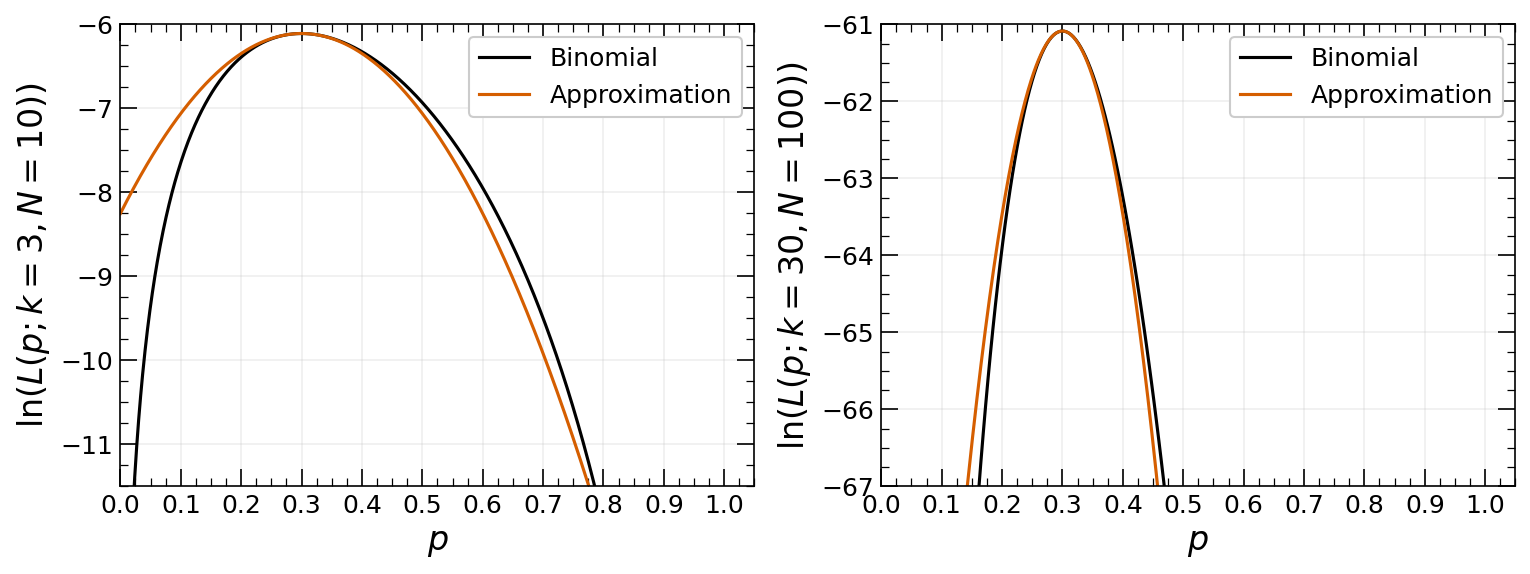

In [8]:
fig, axs = plt.subplots(1,2,figsize = (12,4),dpi = 150)

# Use p2 list to avoid log(0.0)
axs[0].plot(p2,np.log(p2**3*(1-p2)**7),color='black',label='Binomial')
axs[0].plot(p,np.log(0.3**3*0.7**7) + 0.5*(-3/0.3**2 - 7/0.7**2)*(p - 0.3)**2,color='#D55E00',label='Approximation')
axs[0].set_ylim(-11.5,-6)
axs[0].set_xlim(left=0)
axs[0].set_xlabel('$p$',fontsize = 16)
axs[0].set_ylabel('$\ln(L(p; k = 3, N = 10))$',fontsize = 16)
axs[0].tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
axs[0].tick_params(which='major',size = 8)
axs[0].tick_params(which='minor',size = 4)
axs[0].xaxis.set_major_locator(MultipleLocator(0.1))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.025))
axs[0].yaxis.set_major_locator(MultipleLocator(1))
axs[0].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[0].legend(loc='upper right',fontsize = 12,framealpha = 1)
axs[0].grid('xkcd:dark blue',alpha = 0.2)

# Use p3 list to avoid log(0.0)
axs[1].plot(p3,np.log(p3**30*(1-p3)**70),color='black',label='Binomial')
axs[1].plot(p,np.log(0.3**30*0.7**70) + 0.5*(-30/0.3**2 - 70/0.7**2)*(p - 0.3)**2,color='#D55E00',label='Approximation')
axs[1].set_ylim(-67,-61)
axs[1].set_xlim(left=0)
axs[1].set_xlabel('$p$',fontsize = 16)
axs[1].set_ylabel('$\ln(L(p; k = 30, N = 100))$',fontsize = 16)
axs[1].tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
axs[1].tick_params(which='major',size = 8)
axs[1].tick_params(which='minor',size = 4)
axs[1].xaxis.set_major_locator(MultipleLocator(0.1))
axs[1].xaxis.set_minor_locator(MultipleLocator(0.025))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[1].legend(loc='upper right',fontsize = 12,framealpha = 1)
axs[1].grid('xkcd:dark blue',alpha = 0.2)


From these plots, it can be seen that the approximation is most accurate near the peak, but the range for which it is accurate increases if we increase the number of trials (as we expect for a Gaussian approximation). 

For a set of measurements $X_i$ of Gaussian distributed random variables, each with different (unknown) mean $\mu_i$ and (known) width $\sigma_i$, we can show that maximising the log-likelihood with respect to the means $\mu_i$ is equivalent to minimising the chi-squared with respect to the same parameters. In fact, we find that 

\begin{equation*}
\chi^2 = 2C - 2\ln(L)
\end{equation*}
for some constant $C$ (which is constant if the widths $\sigma_i$ are known). As a result, it is common to find a minimum of $-2\ln(L)$ rather than trying to maximise the log-likelihood, as this is directly comparable to the chi-squared in the Gaussian case. 

## Numerical optimisation of cost functions

So far we have discussed two different cost functions that we can optimise in order to estimate our parameters: the chi-squared and the log-likelihood. However, we cannot always analytically solve to find our estimates and instead must apply numerical methods. While we won't cover this in detail here, it is important you are aware of what kinds of approaches might be used.

One of the most common algorithm used for these optimisation problems is **gradient descent**. Specifically, we use gradient descent for minimisation problems; either for minimising the $\chi^2$, or minimising the negative log-likelihood (equivalent to maximising the log-likelihood). To do this, we make updates to the parameter estimate by changing it by some small value in the direction of the negative gradient, i.e. we step towards the point where gradient tends to 0. This is illustrated in the figure below.

<img src='Week4_plots/gradient_descent_example.png' align='center' width=600>

*Example of how the parameter value $\theta$ updates in an application of gradient descent. In this scenario, the cost function is given as $X^2$. With each step in the direction of the negative gradient, we move towards the minimum of the cost function*




The amount we change our parameter $\theta$ by in each step is proportional to the gradient and to a parameter called the **learning rate**, which we label as $\alpha$. In fact, the learning rate belongs to a type of parameter called **hyperparameters**, which can be defined as *parameters of the learning algorithms, and not of the model*. We will see this concept more when we talk about machine learning in the rest of this course.

<div style="background-color:#FFCCCB">



The main steps of this algorithm are as follows:

1. Define an initial parameter guess $\theta_{\text{init}}$ and set our parameter estimate $\hat{\theta}$ equal to it
1. Calculate (numerically) the gradient of the cost function $q$ evalauted at the initial guess, $\frac{\partial q}{\partial \hat{\theta}}$
1. Update the value of $\hat{\theta}$ according to
\begin{equation*}
\hat{\theta} = \hat{\theta} - \alpha \frac{\partial q}{\partial\hat{\theta}}
\end{equation*}
where $\alpha$ is a parameter known as the **learning rate**. 
1. Repeat steps 2 and 3 until the value of the cost function is below some satisfactory value or satisfies some convergence condition



Because the learning rate is a hyperparameter of the algorithm, it must be chosen carefully to give good performance. If the learning rate is too low, we can take a long time to find a minimum as we need to make many steps. It is also possible to get caught in a local minimum of the cost function, rather than finding the global minimum. If the learning rate is too high, we may "skip" over the minimum and instead oscillate around the minimum or diverge away from it. A good choice of learning rate will result in fast convergence to a global minimum. The figure below shows these three scenarios.

<img src='Week4_plots/lr_scenarios.png' align='center' width = 1400>

*Different learning rate scenarios. For low learning rates, too many updates are required to reach the minimum, while a large learning rate causes drastic updates leading to divergent behaviour.*

You will not need to code gradient descent yourself; it is very well implemented in many software packages, including the `iminuit` package we will use for fitting. You will see this library in more detail later in this workbook. The same method can be applied to models with multiple parameters, we must simultaneously optimise the cost function with respect to all of the parameters. You will also see gradient descent again in Week 9 when we discuss neural networks.



## Summary

In this section you have seen how we can make best estimates of parameters from data we have measured, including:

* Chi-squared minimisation
* The maximum likelihood principle
* Gradient descent to minimise cost functions

The following section will discuss how we can determine the error on parameters we have estimated. 

<hr style="border:2px solid gray">
<a id='section3'></a>

# Section Three: Parameter Uncertainty Intervals [^](#outline)

When we make measurements of anything, we need to know the uncertainty on the measurement, because this tells us how much we can trust the value we have measured. Much like we consider uncertainty on the values we measure, we need to find uncertainties for parameters that we estimate. In this section, we will discuss how we can find parameter uncertainties from our fitting methods and then how this links back to the confidence interval we discussed for hypothesis testing last week.

We will first discuss our two main estimation methods in turn.

## Chi-squared parameter uncertainties

As we have previously defined, the chi-squared is a function of the parameters of our fit for measured data $\{X_i,y_i\}$, and can be written as

\begin{equation*}
\chi^2(\theta; y_i) = \sum_{i = 1}^N\left[\frac{y_i - f(X_i; \theta)}{\sigma_i}\right]^2
\end{equation*}
where $f(X_i; \theta)$ is our model prediction at the point $X_i$ and $\sigma_i$ is the uncertainty on the measurement $y_i$.

Consider taking a Taylor expansion around the minimum of the chi-squared which occurs at $\theta = \hat{\theta}$, assuming just one parameter for clarity. At a minimum, the linear term disappears and we are left with

\begin{equation*}
\chi^2(\theta) \approx \chi^2(\hat{\theta}) + \left.\frac{d^2\chi^2}{d\theta^2}\right|_{\theta = \hat{\theta}} \frac{(\theta - \hat{\theta})^2}{2} + \cdots
\end{equation*}

We know the second derivative must be positive as the best-fit chi-squared is a minimum. We will therefore define

\begin{equation*}
\frac{1}{\Sigma^2} = \frac{1}{2}\left.\frac{d^2\chi^2}{d\theta^2}\right|_{\theta = \hat{\theta}}
\end{equation*}

which allows us to write

\begin{equation*}
\chi^2(\theta) \approx \chi^2(\hat{\theta}) + \frac{(\theta - \hat{\theta})^2}{\Sigma^2}
\end{equation*}

We can interpret the second term of this as a residual divided by an uncertainty, like we saw when we talked about the chi-squared goodness-of-fit test. We therefore can identify our quantity $\Sigma$ as the uncertainty on the best estimate $\hat{\theta}$. 


<div style="background-color:#FFCCCB">

If we had a vector of multiple parameters $\boldsymbol{\theta}$, then the uncertainty $\Sigma$ is actually a matrix $\boldsymbol{\Sigma}$ and is referred to as the **error matrix**. The diagonal element $\Sigma_{ii}$ is are the uncertainty on the parameter $\theta_i$, while the off-diagonal element $\Sigma_{ij}$ is the covariance of the parameters $\theta_i$ and $\theta_j$. For uncorrelated parameters $\theta_i$ and $\theta_j$, the covariance $\Sigma_{ij} = 0$. 

We define the elements of the weight matrix $\mathbf{W} = \boldsymbol{\Sigma}^{-1}$ as
$$
W_{ij} = \frac{1}{2}\left.\frac{\partial^2\chi^2}{\partial\theta_i\partial\theta_j}\right|_{\theta = \hat{\theta}}
$$
which is half of what is called a [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) of the function $\chi^2$ evaluated at $\hat{\theta}$.
    
To find the covariance matrix, we must invert the weight matrix.

If the second derivative of the chi-squared is easy to calculate, the uncertainty on the best estimate can be found through this method. However, because the chi-squared method can be used for arbitrarily complex functions $f(X_i; \theta)$, we cannot always calculate the second derivative practically. 

Instead, we adopt a perturbation approach: what happens if we perturb the value of the parameter $\theta$ from the value that gives the minimum chi-squared? Let us specifically consider shifting the parameter from $\hat{\theta}$ to $\hat{\theta} \pm \Sigma$. From our Taylor expansion, we can see this becomes

\begin{align*}
\chi^2(\hat{\theta} \pm \Sigma) &\approx \chi^2(\hat{\theta}) + \frac{(\hat{\theta} \pm \Sigma - \hat{\theta})^2}{\sigma^2} \\
&\approx \chi^2(\hat{\theta}) + \frac{\Sigma^2}{\Sigma^2} \\
&\approx \chi^2(\hat{\theta}) + 1
\end{align*}

i.e. the value of the chi-squared changes by 1 if we change the parameter from the best estimate by $\pm \Sigma$. As a result, if we numerically evaluate the chi-squared for different values of theta, the range for which the chi-squared changes by up to 1 gives the uncertainty on $\hat{\theta}$. An example for such an approach can be seen in the figure below.

<img src='Week4_plots/chi_square_intervals_example.png' align='center' width = 600>

*Determining uncertainty intervals from the chi-squared distribution for a parameter estimate $\hat{\theta}$. From this we determine that the best estimate is $\hat{\theta} = 2 \pm 0.82$.*

## Maximum likelihood parameter uncertainties

For maximum likelihood parameter uncertainties, we adopt a very similar approach to the one we have just outlined for the chi-squared. By taking a Taylor expansion around the maximum of the log-likelihood and knowing that the second derivative must be negative as we are at a maximum, we find that

\begin{equation*}
\ln(L(\theta)) \approx \ln(L(\hat{\theta})) + \left.\frac{d^2\ln(L)}{d\theta^2}\right|_{\theta = \hat{\theta}}\frac{(\theta - \hat{\theta})^2}{2!} + \cdots
\end{equation*}

This time, we identify the constant $\Sigma$ according to

\begin{equation*}
\frac{1}{\Sigma^2} = -\left.\frac{d^2\ln(L)}{d\theta^2}\right|_{\theta = \hat{\theta}}
\end{equation*}

The negative sign means that $\Sigma^2$ is positive and thus that $\Sigma$ is real. We can then write the approximation as

\begin{equation*}
\ln(L(\theta)) \approx \ln(L(\hat{\theta})) - \frac{(\theta - \hat{\theta})^2}{2\Sigma^2} + \cdots
\end{equation*}

By ignoring higher order terms and taking the exponential of both sides, we find that

\begin{equation*}
L(\theta) \approx L(\hat{\theta})e^{-(\theta - \hat{\theta})^2/2\Sigma^2}
\end{equation*}

i.e. a Gaussian function in $\theta$, with mean $\hat{\theta}$ and width $\Sigma$. We therefore identify $\Sigma$ as the uncertainty on the parameter $\theta$.


<div style="background-color:#FFCCCB">

This holds for the single parameter case; if we have more than one parameter, then we must again invert the weight matrix $\mathbf{W}$ like for the chi-squared case, where the elements $W_{ij}$ are defined as 

\begin{equation*}
W_{ij} = -\left.\frac{\partial^2\ln(L)}{\partial\theta_i\partial\theta_j}\right|_{\theta = \hat{\theta}}
\end{equation*}

and the error matrix $\boldsymbol{\Sigma}$ is the inverse of the weight matrix.

What if the Gaussian approximation isn't a good approximation to our function, or it is difficult to evaluate the second derivative of the log-likelihood? We will use a similar approach to the chi-squared, namely examining the value of the log likelihood at $\theta = \hat{\theta} \pm \Sigma$ to find a range of log-likelihood values that correspond to our uncertainty.

We will start with the Gaussian case, and then claim (without proof) that this applies for non-Gaussian likelihoods as well (for the large N limit in general but as a good approximation normally).

\begin{align*}
\ln(L(\hat{\theta}\pm\Sigma)) &= \ln(L(\hat{\theta})) - \frac{(\hat{\theta} \pm \Sigma - \hat{\theta})^2}{2\Sigma^2} \\
&= \ln(L(\hat{\theta})) - \frac{\Sigma^2}{2\Sigma^2} \\
&= \ln(L(\hat{\theta})) - \frac{1}{2}
\end{align*}

Where we have identified
\begin{equation*}
\frac{1}{\Sigma^2} \approx -\left.\frac{d^2\ln(L)}{d\theta^2}\right|_{\theta = \hat{\theta}}
\end{equation*}
again.

This means the uncertainty is the range that changes the log-likelihood by -1/2, whereas for the chi-squared we look for the range that changes by +1. This range can in general be asymmetric. This is shown for a binomial example with distribution $B(3, 10)$ in the figure below.

<img src='Week4_plots/log_likelihood_intervals_example.png' align='center' width=600>

*Example of calculating estimated parameter uncertainty using log-likelihood estimation for a binomial distribution. In this case, the best estimate $\hat{p} = 0.3^{+0.155}_{-0.13}$.*

We can use the same method in general rather than only for Gaussian likelihoods as a pretty good approximation (which improves as the number of measurements $N$ increases).

## Parameter uncertainties and confidence intervals

<div style="background-color: #FFF8C6">


We've done a lot of talking about these errors on our estimated parameters and deriving them in analogy with the width of a Gaussian, but what do they actually mean? To understand this, we first need to understand the idea of confidence intervals on random variables.

As a basic example, consider a normally distributed random variable $X$ distributed according to $N(\mu,\sigma)$. If we integrate the PDF between $\mu - \sigma$, and $\mu + \sigma$, we find that the probability of a measurement of $X$ lying in this range is 68.3%. 

We can define similar ranges like these for non-Gaussian distributions, regardless of the parameters of the specific distribution. Despite the fact that the specific value of 68.3% is derived from the integral of a Gaussian, it is very common to use this with any distribution and even refer to it as the $1\sigma$ confidence interval, even if the distribution in question doesn't have $\sigma$ as a parameter. `Things can be slightly more complicated for non-Gaussian distributions because they can be asymmetric and as such there is not a unique way to define the confidence interval of a given percentage. 

How does this relate to errors on estimated parameters? Unlike random variables, parameters have an exact value even if it is unknown to us, which is why we try to estimate them from data that we measure. If we were to make a large number of experiments, we expect that 68.3% (or 95%, or whatever our quoted confidence value is) of the experiments will have the true value within the derived confidence interval. Again we can quote these in terms of numbers of $\sigma$ even if our likelihood or PDF is not Gaussian. 

We can also use one-sided confidence intervals, if e.g. our parameter cannot be negative like a cross section of some rare process, instead we only want to set an upper limit. 

We will discuss the connection between parameter uncertainties and hypothesis testing more during the next discussion session 


## Summary

In this section we have discussed how we can estimate parameter uncertainties for our two parameter estimation methods, including:

* Estimating uncertainties through direct calculation of cost function derivatives
* Estimating uncertainties through numerical methods
* Connection of parameter uncertainties to confidence intervals

In the next section, we will discuss how we can do accurate and flexible fitting in python using `iminuit`.

<hr style="border:2px solid gray">
<a id='section4'></a>

# Section Four: Curve Fitting Using Least Squares and `iminuit` [^](#outline)

Now we have discussed the theory of how we can estimate parameters from data, we want to put it into practise. `scipy` has a series of functions for fitting data, but in general more advanced packages are preferred. The `minuit` C++ package is commonly used in High Energy Physics, and was developed at CERN. It has a python wrapper called `iminuit` that we will use for fitting in this course. This should be loaded on all physics PCs but if you are using your own machine you may need to [install iminuit](https://iminuit.readthedocs.io/en/stable/install.html).

This section is intended to give an overview of some key `iminuit` syntax that you can work through to make sure you understand how to use the library. The following content is based on the `iminuit` tutorials, available on [their website](https://iminuit.readthedocs.io/en/stable/tutorials.html). 

<div style="background-color: #FFF8C6">
    
You may be familiar with routines such as `curve_fit` in `scipy.optimize`, where we apply `curve_fit` to our data and the function we are fitting to get a result. Here we will see that `iminuit` takes what is called an "object-oriented" approach. That is we create a `Minuit` object, a type of object defined by the `imunuit` package. This `Minuit` object contains everything: data, fitted function, the methods needed to generate the fit, fitted parameter values and their uncertainties.      

## A simple example of a fit using `iminuit`

Like all fitting, we require some data, the function (a "model") we are fitting to the data, and a cost function whose minimum indicates the parameters of the best fit. 

<!-- We can define cost functions manually if we want, but there are many already implemented in `iminuit` that we can use. We provide the data and the model, with some initial parameter guesses, and then the local minimizer (called MIGRAD) will find a local minimum of the model starting from our initial parameter guesses. 

Fundamentally, everything is done through the `Minuit` object, and a cost function. We will begin by importing these: -->



#### Model and Fit Function

Our model used to create the data will also be the same function we use to fit the data.  We will choose a simple line $y = m \, x +c$ with independent variable $x$ and two fixed parameters $m$ and $c$.

In [9]:
# Note this is both the model we use to construct the data and the function we use to fit the data.
def line(x, m, c):
    return x*m + c

#### Artificial data

We will create some artificial data starting from the function we will use to fit the data plus some random noise.  An artificial data set like this is a classic way to test machine learning methods as we know what should be the best answer for our method as we created the data around this ideal answer. Can the machine learning method, here curve fitting, find the "correct" answer (the "ground truth")? 

For our data:- 
* We will set the parameters of this model to be $m=1.0$ and $c=2.0$. 
* We will choose a small set of $X$ values.
* For each $X$ value we take our data point to be $ m \, X +c$ plus a Gaussian random number chosen from a normal distribution of mean zero and standard deviation $0.1$.

Note that our data points can be thought of as the mean value for $y$ measured at each $x$ value. Then the standard error in the mean represents the uncertainty in the $y$ values but here this is simply the standard deviation we used when choosing a random number from a Gaussian distribution.

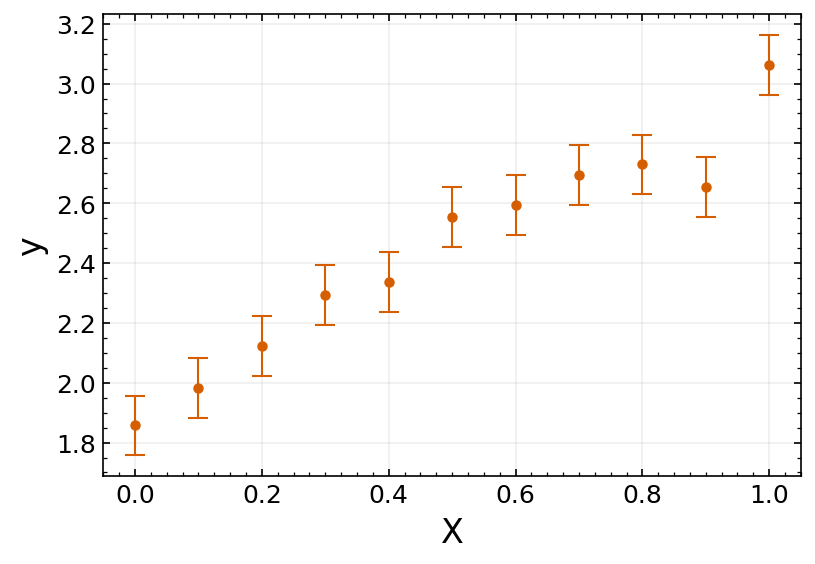

In [10]:
np.random.seed(0) # Set the random seed for consistency. Why not use 0?

# These are the ground truth values hiding in our data
m_value=1.0
c_value=2.0

n_points = 11 # 11 data points
data_x = np.linspace(0,1,n_points) # evenly spaced from 0.0 to 1.0 inclusive 
data_yerr = 0.1 # the standard deviation of the noise
data_y = line(data_x, m_value, c_value) + np.random.default_rng().normal(loc = 0, scale = data_yerr, size = n_points)

# Plot to show the data
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(data_x, data_y, yerr = data_yerr,
            color='#D55E00',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
# ax.xaxis.set_major_locator()
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

#### Cost function

The simplest way to construct a cost function is to ue one of the many provided by `iminuit` as it has all the comon choises. Here we can use the `LeastSquares` class to generate an object which encodes the chi-squared cost function, has the data we are using and the function we want to fit, all in one object. So we need to pass the $X$ values, $y$ values, uncertainty on the $y$ values, and the function we are trying to fit.

In [11]:
# Note: this is equivalent to our chi-squared cost function
from iminuit.cost import LeastSquares 

least_squares_line = LeastSquares(data_x, data_y, data_yerr, line)

Note how this cost function object we defined knows what the parameters are. This cost function object looks at the function `line` given to it and assumes the second and subsequent arguments are the paramaters, while it assumes the first parameter of `line` is a vector of independent variable values $X$.  

#### Minuit object

Now at last we combine data, fitted function and an initial value for the fitting parameters (needed to start the fitting method) into a single `Minuit` object - we  "instantiate" a `Minuit` object. Everything we need is then in this object. 

Note that choosing initial parameter values can have a big effect on the success of your algorithm in more complicated cases. If our cost function has several minima, the minimium reached after running the optimisation depends on the starting point. We might not even find the global minimum i.e. the best possible fit. Even if the cost function only has one minimum, starting parameter values in the proximity of the minimum will improve the speed of convergence. 

However, for this simple case the initial values will have little effect. 

In [12]:
# If you get an error then maybe iminuit is not installed on your machine.
from iminuit import Minuit 

# Starting parameter values often important but not in this simple case
mline = Minuit(least_squares_line, m = 5.0, c = 5.0) 

print(mline.init_params) # shows initial parameter values

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   5.00    │   0.05    │            │            │         │         │       │
│ 1 │ c    │   5.00    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


We can pass the parameters by the name *exactly as used in the fit function*, here our `line` function. These parameter names found by the `Minuit` object through "introspection".

We can also pass the parameters by positional arguments. Looking at our fit function `line` which is the `LeastSquares`, we see the first argument is $m$ and the second is $c$ so another way to define an equivalent Minuit object is

In [13]:
# This does exactly the same job as mline but isn't as clear to read.
mline1 = Minuit(least_squares_line, [5.0, 5.0]) 

print(mline1.init_params) # shows initial parameter values

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   5.00    │   0.05    │            │            │         │         │       │
│ 1 │ c    │   5.00    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


If we forget a parameter, or we write the wrong name for a parameter, `iminuit` will raise an error. The next two cells will show examples of such errors.

In [14]:
# error, our least_squares_line uses the line function 
#        which takes two parameters

# UNCOMMENT THIS NEXT LINE TO SEE ERROR
#mline2 = Minuit(least_squares_line) 

In [15]:
# error as no h parameter in the line function 
#       inside the least_squares_line

# UNCOMMENT THIS NEXT LINE TO SEE ERROR
#mline3 = Minuit(least_squares_line, h = 10, c = 5) 

### The fit

After instantiating our `Minuit` object, the `mline` in the previous cell, we will use two different methods: 
* `migrad` (the name of a particular minimisation method) to find the local minimum of the cost function.
There are a few other pre-defined minimizers, but we will just use the MIGRAD algorithm. 
* `hesse` (named after the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix)) to compute the uncertainty on our parameter. 


In a Jupyter notebook, we get a nice rendering of the results of the fitting. 

In [16]:
# Do the fitting

# minimise the least_squares cost function, i.e. find the best fit
mline.migrad() 

mline.hesse() # calculate parameter uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.749 (χ²/ndof = 0.9)      │              Nfcn = 46               │
│ EDM = 2.74e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   1.05    │   0.10    │            │            │         │         │       │
│ 1 │ c    │   1.92    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       m       c │
├───┼─────────────────┤
│ m │ 0.00909 -0.0045 │
│ c │ -0.0045 0.00318 │
└───┴─────────────────┘

<div style="background-color: #C2D5BD"> 

OPTIONAL EFS: You might notice the reduced chi-square is quoted in the output as $\chi^2/\mathrm{ndof}$. What are the degrees of freedom $\mathrm{ndof}$ in this case? As a bonus, can you find out how to get this from the iminuit object, our `mline`?
    
<!-- 
print("The number of degrees of freedom should be {0:d} and we find {1:d}".format(n_points-2,mobj.ndof)) 
-->    

<!-- The number of degrees of freedom should be number of points minus two as we have two parameters whose values are fixed by the fitting. -->

Hurray! You should see the line is a good fit, not too perfect, not too bad.  The $m$ and $c$ values found are close to, within error, the values we used to create the data (the ground truth values). 

#### Inspecting current parameter values

The `Minuit` object contains the current parameter values, errors, and some other information about each parameter. We can display the current values using `Minuit.params`:

In [17]:
display(mline.params)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,1.05,0.10,,,,,
1,c,1.92,0.06,,,,,


If we just run `Minuit.params`, it returns a tuple-likecontainer of `Param` objects which are data structures representing properties of the parameters being fitted. 

For instance     
* `mline.params` is the tuple-like container of Param data objects which contain information about the fitted parameters. `display(mline.params)` shows the values nicely.
* This means `mline.params[p]` gives information about the p-th parameter. 

We can use the `repr` function to get a detailed representation of a given parameter, `print(repr(mline.params[p]))`.

Each parameter has several fields including: 
- `number`: parameter index. 
- `name`: parameter name. 
- `value`: value of the parameter at the minimum. 
- `error`: uncertainty estimate for the parameter value.

For instance, `mline.params[0].name` gives the name of the first parameter    



In [18]:
for param in mline.params:
    print(repr(param))

Param(number=0, name='m', value=1.053162649118042, error=0.09534622819496641, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None)
Param(number=1, name='c', value=1.9171962078994493, error=0.05640758880160511, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None)


If we want properties of an individual parameter we can access them as follows

In [19]:
for param in mline.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))

m = 1.05 +/- 0.10
c = 1.92 +/- 0.06


In [20]:
print('{} = {:.2f} +/- {:.2f}'.format(mline.params[0].name, mline.params[0].value, mline.params[0].error))

m = 1.05 +/- 0.10


The initial parameter guesses can still be viewed using `Minuit.init_params` e.g. `mline.init_params[0]` is the information on initial values of the `m` parameter.

In [21]:
for param in mline.init_params:
    print(repr(param))

Param(number=0, name='m', value=5.0, error=0.05, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None)
Param(number=1, name='c', value=5.0, error=0.05, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None)


#### Visualise the fit

And that's all you need to do for a simple fit using `iminuit`. You should always visualise the fit. This isn't precise statistics but you need to use your common sense and just look to make sure your fitting is working. the automatic version above will do fine for development but here is a fancier version needed for presentation.

<!-- Really, we should look at the fits that are within the errors.  One way to do this is with error bands, Since this is something we often want to do, it is of course it is easy to do in iminuit. See [How to draw error bands](https://iminuit.readthedocs.io/en/stable/notebooks/error_bands.html). -->

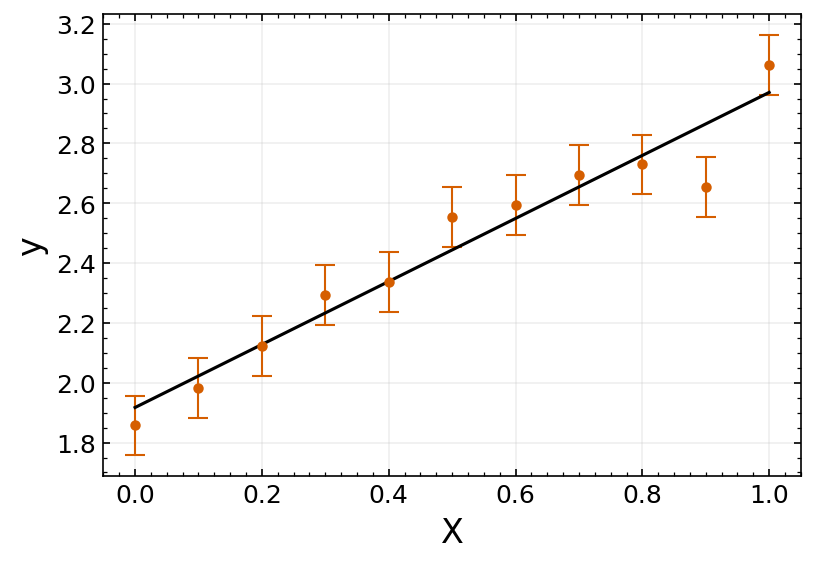

In [22]:
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(data_x, data_y, yerr = data_yerr,
            color='#D55E00',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
ax.plot(np.linspace(0,1,100),line(np.linspace(0,1,100),*mline.values),color='black')

x_min = min(data_x)
x_max = max(data_y)
fit_x_values = np.linspace(x_min,x_max,100)
fit_y_values = line(fit_x_values, *mline.values)

ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
# ax.xaxis.set_major_locator()
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

Now we have seen how we can do a simple fit, we will talk about each part in more detail.

### Using `iminuit` with an arbitrary number of parameters

We can also use iminuit with functions that accept an arbitrary number of parameters which are defined through data structures such as numpy arrays e.g. $n$-th order polynomials. This has pros and cons.

**Pros**

* Easy to change number of fitted parameters
* Sometimes simpler function body that’s easier to read
* Technically this is more efficient, but this is hardly going to be noticed

**Cons**

* `iminuit` cannot (automatically) figure out names for each parameter
* user (you) might get confused over the name of the parameter linked to each entry in the array of parameter values

In [66]:
""" Functions used by iminuit's LeastSquares take the argument x first 
    (could be an array of x_0, x_1, ... if in more than one dimension) 
    followed by any number of parameters. 

    And then notice that numpy's polyval, 
    https://numpy.org/doc/stable/reference/generated/numpy.polyval.html
    which gives us a polynomial in x, puts the arguments the other way round!
    That is polyval wants parameter array first, x array second.
    N.B. The polynomial with N=len(par) has parameter of highest power of x from the first par[0] entry:-
    par[0]*x**(N-1) + par[1]*x**(N-2) + ... + par[N-2]*x + par[N-1]

"""

def line_np(x, par):
    """
    Input
    -----
    x = a 1D array of values
    par a tuple (list etc) of parameter values
    
    Return
    ------
    An array of polynomial values equal to
    par[0]*x**(N-1) + par[1]*x**(N-2) + ... + par[N-2]*x + par[N-1]
    
    """
    return np.polyval(par, x)  # for len(par) == 2, this is a line

least_squares_np = LeastSquares(data_x, data_y, data_yerr, line_np)

"""
    NOTE.
    The version above works as long as you don't visualise the result in iminuit which the 
    migrad method does in Jupyter notebooks. The solution used below is always to assign 
    a variable to the Minuit object when using migrad. See Appendix for alternative solution.
"""

"\n    NOTE.\n    The version above works as long as you don't visualise the result in iminuit which the \n    migrad method does in Jupyter notebooks. The solution used below is always to assign \n    a variable to the Minuit object when using migrad. See Appendix for alternative solution.\n"

Calling `line_np` with more or fewer arguments is easy. For $N$ arguments, a polynomial of order $(N-1)$ is used to predict the behavior of the data.

The built-in cost functions of `iminuit`, such as the `LeastSquares` used here, support models like our `line_np` with an unspecified number of arguments. However,  for this to work properly, we need to pass the starting values in the form of a single sequence of numbers when constructing the `Minuit` object. That way `iminuit` can work out how many parameters it is fitting. 

For example:-

In [24]:
display(Minuit(least_squares_np, (5.5, 6.0)))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.50,0.06,,,,,
1,x1,6.00,0.06,,,,,


Here we have used a tuple `(5.5,6.0)` for initialisation of the parameters, but any sequence (including lists and numpy arrays) would work. `iminuit` uses the length of the sequence to detect how many parameters the model has, so two here. By default, the *parameters* are named automatically $x_0$ to $x_N$ - yes confusing as these are parameter names and nothing to do with the "x" values of our data. 

We can override this naming convention with the keyword argument `name`, passing a sequence of parameter names. Of course, this sequence must be of the same length as the sequence of starting points.

In [25]:
# This means that the parameter we call "a" starts with value 5.5, etc
display (Minuit(least_squares_np, (5.5, 6.0), name=("a", "b"))) 

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.50,0.06,,,,,
1,b,6.00,0.06,,,,,


In [26]:
# As a quick check lets use the straight line version of the polynomial fit
m_line_obj_np = Minuit(least_squares_np, [5.5, 6.0])
display(m_line_obj_np)


# minimise the least_squares cost function, i.e. find the best fit
# Suppress the graphical output
mmm = m_line_obj_np.migrad() 

hhh = m_line_obj_np.hesse() # calculate parameter uncertainties

# Now check it works and see if the answer is exactly as the line fit above.
for param in mline.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))

# Note that for Exercise 1 you need to get the values of the parameters into one list
fit_param_values = [ v for v in m_line_obj_np.values]
print(fit_param_values)

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/ry/gzww70hd00sdtqqjbzbd0bdh0000gn/T/ipykernel_17401/3719899408.py:5: SyntaxWarning: invalid escape sequence '\c'
  """ These lines fail at line 1878 in the visualize method in iminuit\cost.py


,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.50,0.06,,,,,
1,x1,6.00,0.06,,,,,


m = 1.05 +/- 0.10
c = 1.92 +/- 0.06
[1.0531626491187398, 1.917196207899874]


Since our `least_squares_np` works for parameter arrays of any length, we can now define a different `Minuit` object which will fit a cubic polynomial by specifying four initial values:

In [27]:
m_cubic_obj = Minuit(least_squares_np, (5.5, 4.1, 6.9, 0.4))
display (m_cubic_obj)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.50,0.06,,,,,
1,x1,4.10,0.04,,,,,
2,x2,6.90,0.07,,,,,
3,x3,0.400,0.004,,,,,


In [28]:
# minimise the least_squares cost function, i.e. find the best fit
# Suppress the graphical output
mmm3 = m_cubic_obj.migrad() 

hhh3 = m_cubic_obj.hesse() # calculate parameter uncertainties

# It works and the answer is comparable with the linear fit.
# noting that x3 is the constant (c) and x2 is the coefficient of x^1 (m) 
for param in m_cubic_obj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))
    
# Note that for Exercise 1 you need to get the values of the parameters into one list
fit_param_values = [ v for v in m_cubic_obj.values]
print(fit_param_values)

# Again useful for exercise 1
display(m_cubic_obj.fmin)
print( f" chi^2/dof = {m_cubic_obj.fval:.1f} / {m_cubic_obj.ndof:.0f} = {m_cubic_obj.fmin.reduced_chi2:.1f}")

x0 = 1.15 +/- 1.27
x1 = -2.09 +/- 1.94
x2 = 2.07 +/- 0.81
x3 = 1.82 +/- 0.09
[1.1541778645629697, -2.0913757346442194, 2.073461330369246, 1.8216294615646753]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.813 (χ²/ndof = 0.8)      │              Nfcn = 102              │
│ EDM = 1.95e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

 chi^2/dof = 5.8 / 7 = 0.8


We can try different orders of polynomial for fitting our data in this way, just by providing different numbers of starting parameters. Of course, getting the wrong order of polynomial for our data can lead to under or over fitting. 

<div style="background-color:#C2F5DD">
    
### Exercise 1

Fit the data set in the following code cell with different orders of polynomial. Describe qualitatively how the fit changes, and how well the fit describes the data as you increase the order of the polynomial. When does the fit show signs of overfitting? Remember the following points:

* Define your cost function
* Define your Minuit object
* Run the optimisation
* Plot the data and your fit

Use the `line_np` function we have previously defined as your model. You can change the order of polynomial by passing more parameters as `pars` to this function. For instance if you call `line_np(X, (5, 5))` you will be testing a linear model, but if you call `line_np(X, (5, 5, 5, 5))` you will be testing a fit to a cubic, a polynomial of order 3.

In [29]:
x_values = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

y_measured = [343.39452514, 251.31914561, 186.7806368, 121.30027965, 45.23336652, 
              23.49470302, 18.46581766, 6.58329486, 1.98522328, -6.74799454, 
              -7.55489379, -29.55544088, -31.32898172, -36.27525348, -25.23860169, 
              -1.09156819, 52.32898397, 225.38126087, 460.67437131]

y_err = [141.312, 86.205, 49.632, 26.877, 13.872, 
         7.197, 4.08, 2.397, 0.672, 1.923, 5.568, 
         9.795, 13.488, 14.883, 11.568, 0.483, 
         22.08, 60.477, 119.712]


In [30]:
# Define your cost function

""" You don't need to repeat everything from above 
but as a reminder we need:-

from iminuit.cost import LeastSquares 
def line_np(x, par):
    return np.polyval(par, x)
    
Also remember that polyvar with N=len(par) parameters represents
    par[0]*x**(N-1) + par[1]*x**(N-2) + ... + par[N-2]*x + par[N-1]

"""

least_squares_ex1 = LeastSquares(x_values, y_measured, y_err, line_np)

In [31]:
# Define your Minuit object

""" Initial Values. 
You could play around by hand to find a good starting point.
For these polynomials it isn't too important but for 
complicated functions and data a good choice is important 
and it can be a real pain finding it.
So I usually make some simple estimates and use those as a starting point.
"""
# Trying to fit straight line, y = m x + c
# The errors are small around values at indices 8 and 9 so try those
m_est = (y_measured[9]-y_measured[8])/(x_values[9]-x_values[8])
c_est = y_measured[8] - m_est*x_values[8]
print("For line y = mx + c fit, estimate m={:f}, c={:f}".format(m_est,c_est))

# Minuit object for example 1 with two parameters (straight line)
mobj_ex1_p2 = Minuit(least_squares_ex1, [m_est, c_est] )    

For line y = mx + c fit, estimate m=-8.733218, c=19.451659


In [32]:
# Run the minimisation

# *** I HAD TO SUPRESS THE OUTPUT HERE BY SETTING EQUAL TO A VARIBLE CALLED "_" 
#     the single underscore character, often used as a dummy variable in python

# minimise the least_squares cost function, i.e. find the best fit
_ = mobj_ex1_p2.migrad() 

_ = mobj_ex1_p2.hesse() # calculate parameter uncertainties

# results for parameters, just to compare to estimated values
for param in mobj_ex1_p2.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))

x0 = -0.54 +/- 0.11
x1 = 3.39 +/- 0.78


Actually, the fit suggests my initial estimates were pretty poor so that clever estimate was not really needed here but I have found in needed in many practical cases.

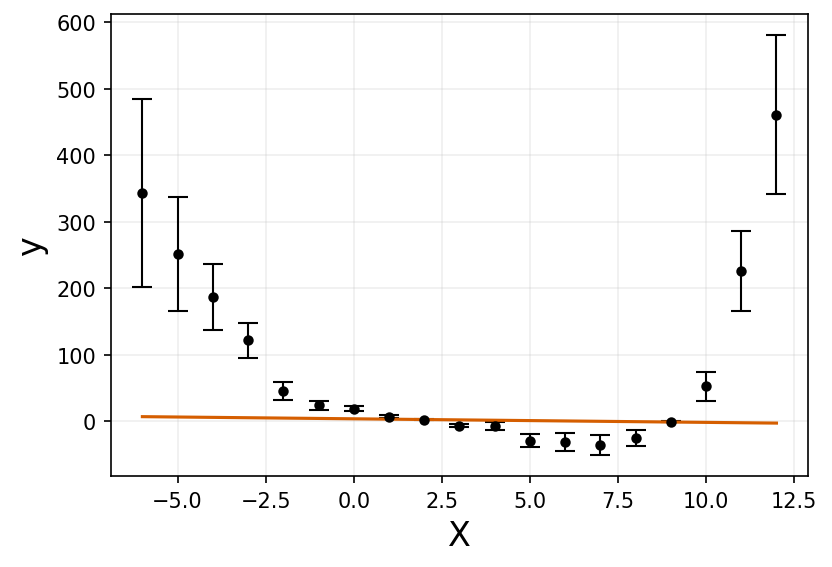

In [33]:
# Plot data and fit

fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(x_values, y_measured, yerr = y_err,
            color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
x_min = min(x_values)
x_max = max(x_values)
fit_x_values = np.linspace(x_min,x_max,100)
fit_param_values = [ v for v in mobj_ex1_p2.values]
fit_y_values = line_np(fit_x_values, fit_param_values )
ax.plot( fit_x_values, fit_y_values, color='#D55E00')

ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
# ax.xaxis.set_major_locator()
#ax.xaxis.set_minor_locator(MultipleLocator(0.025))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

Now we have got one function to fit, let us try several polynomials. You could just repeat the code for each different order of polynomial, it would be simpler. Then combine into one plot at the end.

I will try something a little neater.

Fitting order 4 polynomial
Fitting order 5 polynomial
Fitting order 6 polynomial
Fitting order 8 polynomial


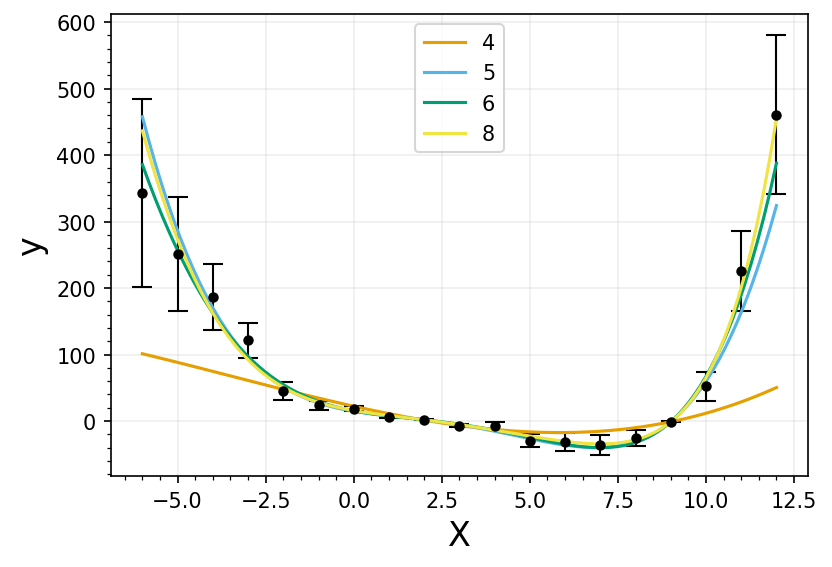

In [34]:
N_list=[4,5,6,8] # order of polynomial, maximum power is x^N where N=N_list[i]

mobj_ex1_list = [] # list of the Minuit objects
for N in N_list:
    print ("Fitting order {:d} polynomial".format(N))
    
    # First set the initial parameter values to be [0,0, ..., m_est,c_est]
    # Length of this initial parameter value list sets the order of polynomial fitted
    initial_argument_list = [0]*N # Set all coefficient values of polynomial to be zero 
    initial_argument_list[-1] = c_est # set last one equal to c estimate
    initial_argument_list[-2] = m_est # set second last one equal to c estimate
    
    # Now define Minuit object then minimise
    mobj_ex1_pn = Minuit(least_squares_ex1, initial_argument_list )
    mobj_ex1_pn.migrad() # No graphical output produced here by default 
    mobj_ex1_pn.hesse() 
    mobj_ex1_list.append(mobj_ex1_pn )
    
    """ Any of the following can be used to see information on the fit
    
    for param in mobj_ex1_pn.params:
        print('{} = {:.4f} +/- {:.4f}'.format(param.name, param.value, param.error))
        
    display(mobj_ex1_pn.fmin)

    # We will talk about the quality of the fit a little later but with least squares we can get chi square values
    print( f" chi^2/dof = {mobj_ex1_pn.fval:.2f} / {mobj_ex1_pn.ndof:.0f} = {mobj_ex1_pn.fmin.reduced_chi2:.2f}")    

    """
    
    
# Plot data and fit

fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(x_values, y_measured, yerr = y_err,
            color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)

# X Values to use when showing fitted curve
x_min = min(x_values)
x_max = max(x_values)
fit_x_values = np.linspace(x_min,x_max,100)

# Colours from Okabe_Ito list in appendix of week 1
Okabe_Ito =  ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

# for each fit, plot a line
for fit_number in range(len(mobj_ex1_list)):
    mobj_ex1_pn = mobj_ex1_list[fit_number]
    fit_param_values = [ v for v in mobj_ex1_pn.values]
    fit_y_values = line_np(fit_x_values, fit_param_values )
    ax.plot( fit_x_values, fit_y_values, 
            color=Okabe_Ito[fit_number], 
            label=str(N_list[fit_number]) )

# labels etc
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(100))

ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(20))

#ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)    

plt.legend(loc='best')

Comments on Exercise 1.

What is noticeable, playing around with the order of the polynomial fitted, is that there is a big improvement up to order 5. You can see this visually in plots where from order 5 onwards, the lines seem to go through the points. However, with my current plot, you can't see the error bars for points between $-1 \leq X \leq 4$ so you can't really judge this properly (i.e. we need a second plot, say of the residues, difference between data point and fit value). We can extract quantitative measures of the fit and this is what the text output show. As we are using least squares as our "cost function" (our "loss function") here, we can use these values to look at the chi square measure. We will look at how to get these values out of the fit below in exercise 2.  

We say that for $N<5$ we have **underfitting** i.e. bad fit. For $N \gg 5$ we have **overfitting** as adding more parameters to the fitted function will always give a better fit to the data in terms of the value of the chi square value (our loss function) but we are losing predictive power and are likely to get poorer predictions away from data points. I tried plotting the pull for each point as shown below. This shows that for $N =5,6$ and $8$ we are getting good fits, not too good but better than $N=4$. However there is no great improvement in the quality of the fit.

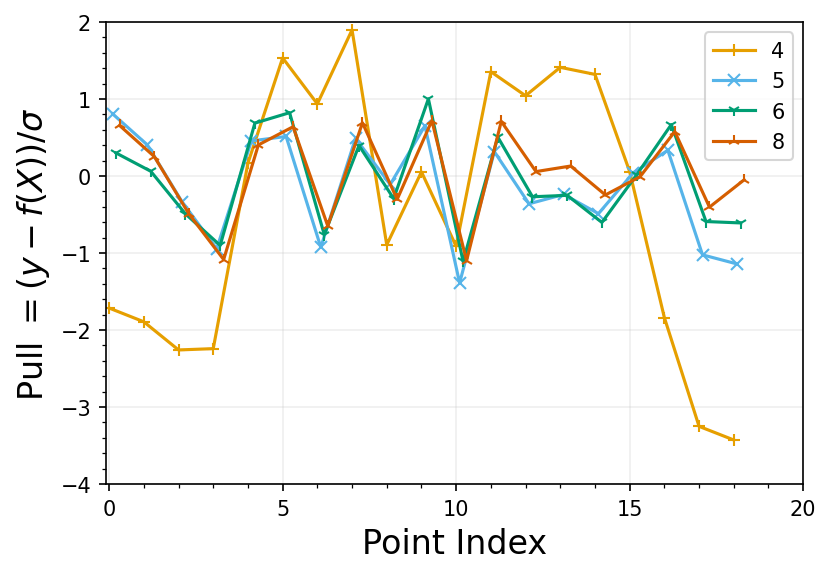

In [35]:
# Plot residues of fit to data. 
# Still not very good. A table of the pull values might be better here  .

fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()

# Colours from Okabe_Ito list in appendix of week 1 except I don't like the yellow
Okabe_Ito =  ["#E69F00", "#56B4E9", "#009E73", "#D55E00", "#0072B2", "#CC79A7", "#F0E442", "#000000"]

# Unfilled markers, see appendix week 1
unfilled_markers_tse = ["+", "x", "1", "2", "3", "4", "|", "_", ","]

# for each fit, plot residue at each data point
for fit_number in range(len(mobj_ex1_list)):
    mobj_ex1_pn = mobj_ex1_list[fit_number]
    fit_param_values = [ v for v in mobj_ex1_pn.values]
    fit_y_values = line_np(x_values, fit_param_values )
    point_index=[i+fit_number/10.0 for i in range(len(x_values))]
    # You need to get rid of meaningless lines between data points probably
    ax.plot(point_index,  (fit_y_values-y_measured)/y_err, marker= unfilled_markers_tse [fit_number],
            color=Okabe_Ito[fit_number], 
            label=str(N_list[fit_number]) )

# The large |X| values still too big so can't see small |X| residues so cut them out
ax.set_xlim(-0.1,len(x_values)+1)
ax.set_ylim(-4,2)
    
# labels etc
ax.set_xlabel('Point Index',fontsize = 16)
ax.set_ylabel(r'Pull $=(y-f(X))/\sigma$',fontsize = 16)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))

#ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)    

plt.legend(loc='best')

<div style="background-color:#C2F5DD">
    
End of Exercise 1.

## Advanced parameter methods

### Setting limits on parameters

When we are fitting for parameters, we may want to set limits on possible values as our parameter may be limited to a certain range either mathematically or physically. For example, if the function includes $\sqrt{a}$, then $a$ must be non-negative, or if our parameter is an energy then we know it must be positive. 

We can set limits on our parameters using `Minuit.limits` and slicing by the name of the parameter we want to set limits on:

In [36]:
# Create a fresh version of our Minuit object for a simple linear fit
mline = Minuit(least_squares_line, m = 3, c = 3)

mline.limits['m'] = (0,None) # set limit on m to be minimum of 0, no maximum
mline.limits['c'] = (-float("infinity"), 10) # set maximum value of c as 10, no minimum
mline.limits['m'] = (0,10) # set limit on m to be minium of 0, maximum of 10
mline.limits['m'] = (None, None)

We can also set multiple limits at once by passing a sequence of limits:

In [37]:
mline.limits = [(0, None), (0,10)]
display(mline.params)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,3.00,0.03,,,0,,
1,c,3.00,0.03,,,0,10,


We can see the limits for each parameter in this listing. 

### Fixing and releasing parameters

We can also fix parameters during the optimisation, so they are not optimised and instead kept at a fixed value. For example, we may have a guess for a parameter value and want to find the optimal values for other parameters for that fixed value. 

You might also have a complex function with many parameters, where a few parameters cause large variations in the function but the rest cause much smaller variations. By first fixing the less important parameters, you can more quickly optimise the most important parameters, and then release the fixed parameters to complete the optimisation. 

We can fix an individual parameter using `Minuit.fixed[<name>] = True`. For example, we can fix $m$ in our straight line example:

In [38]:
# Create a fresh version of our Minuit object for a simple linear fit
mline = Minuit(least_squares_line, m = 3, c = 3)

mline.fixed['m'] = True
display(mline.params)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,3.00,0.03,,,,,yes
1,c,3.00,0.03,,,,,


If we now run `migrad`, only $c$ with be varied:

In [39]:
mline.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 424.7 (χ²/ndof = 42.5)     │              Nfcn = 11               │
│ EDM = 1.42e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   3.00    │   0.03    │            │            │         │         │  yes  │
│ 1 │ c    │   0.944   │   0.030   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        m        c │
├───┼───────────────────┤
│ m │        0        0 │
│ c │        0 0.000909 │
└───┴───────────────────┘

We can now release $m$ and instead fix $c$, and run the optimisation again:

In [40]:
mline.fixed['m'] = False
mline.fixed['c'] = True
mline.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 305.5 (χ²/ndof = 30.6)     │              Nfcn = 24               │
│ EDM = 1.28e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   2.44    │   0.05    │            │            │         │         │       │
│ 1 │ c    │   0.944   │   0.030   │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      m      c │
├───┼───────────────┤
│ m │ 0.0026 0.0000 │
│ c │ 0.0000      0 │
└───┴───────────────┘

We could keep iterating like this, but it is only really necessary for more complex cases. For now we will release both parameters and rerun the minimisation.

In [41]:
mline.fixed = False # Can release all parameters at once this way
mline.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.749 (χ²/ndof = 0.9)      │              Nfcn = 51               │
│ EDM = 1.04e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   1.05    │   0.10    │            │            │         │         │       │
│ 1 │ c    │   1.92    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       m       c │
├───┼─────────────────┤
│ m │ 0.00909 -0.0045 │
│ c │ -0.0045 0.00318 │
└───┴─────────────────┘

### Varying starting points for minimisation

It can also be useful to be able to manually change the values of some fixed parameters and fit the others, or to redo a fit from a different starting point. For example, if the cost function has several minima, changing the starting parameter values can be used to help find the other minimum. 

We define a custom cost function below to show this. We will denote our cost function as $\varphi(\theta)$.

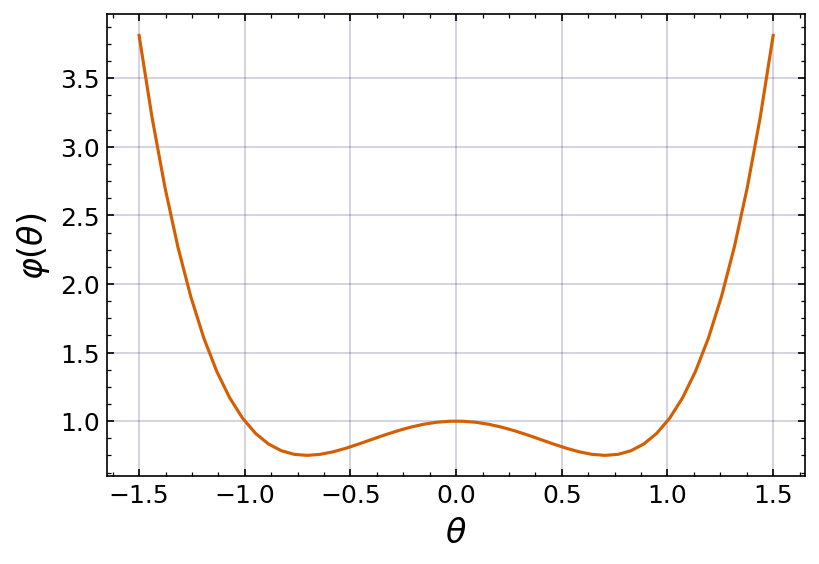

In [42]:
# ! Note how python supports Unicode characters in variables names so
# !    you can use non-ascii characters such θ or 鬯 in variables names.
# !    However, ascii characters work in anything and may be more 
# !    readable to a wider audience.

def cost_function_with_two_minima(θ):
    return θ**4 - θ**2 + 1

# We set a parameter called errordef here; we will discuss this later
cost_function_with_two_minima.errordef = Minuit.LEAST_SQUARES

x = np.linspace(-1.5,1.5)
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.plot(x, cost_function_with_two_minima(x),color='#D55E00')
ax.set_xlabel(r'$\theta$',fontsize = 16)
ax.set_ylabel(r'$\varphi(\theta)$',fontsize = 16)
ax.tick_params(direction='in',which='both',top=True,right=True,labelsize = 12)
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_minor_locator(MultipleLocator(0.125))
ax.grid(color='xkcd:dark blue',alpha = 0.2)

In [43]:
# Starting at θ = -0.1 should give us the left minimum
m2minima = Minuit(cost_function_with_two_minima, θ=-0.1)
m2minima.migrad()
print("Starting value θ = -0.1, minimum at θ = {:.2f}".format(m2minima.values['θ']))

# Now changing the starting value to 0.1 gives the right minimum
m2minima.values['θ'] = 0.1
m2minima.migrad()
print("Starting value θ = +0.1, minimum at θ = {:.2f}".format(m2minima.values['θ']))

Starting value θ = -0.1, minimum at θ = -0.71
Starting value θ = +0.1, minimum at θ = 0.71


## Investigating the fit status

As seen before, calling `Minuit.migrad()` runs the actual minimization with the Migrad algorithm. Migrad essentially tries a Newton-step and if that does not produce a smaller function value, it tries a line search along the direction of the gradient. So far so ordinary. The clever bits in Migrad are how various pathological cases are handled.

Let’s look again at the output of `Minuit.migrad()`.

In [44]:
# Again set up a fresh Minuit object using our original simple linear fit example 
mline = Minuit(least_squares_line, m=5, c=5)
mline.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.749 (χ²/ndof = 0.9)      │              Nfcn = 34               │
│ EDM = 1.06e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   1.05    │   0.10    │            │            │         │         │       │
│ 1 │ c    │   1.92    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       m       c │
├───┼─────────────────┤
│ m │ 0.00909 -0.0045 │
│ c │ -0.0045 0.00318 │
└───┴─────────────────┘

The `Minuit.migrad()` method returns the Minuit instance so that one can chain method calls. The instance also prints the latest state of the minimization in a nice way as we can see in the output in teh previous cell. The informationis in three blocks.

#### First block of `Minuit.migrad()` information 

The *first block* in this `Minuit.migrad()` output is showing information about the function minimum. This is good for a quick check:

All blocks should be green, other colours mean:
* Purple means something bad.
* Yellow is a warning, telling you that you need to be careful.

Let’s see how it looks when the function is bad:

In [45]:
m_bad = Minuit(lambda x: 0, x=1)  # a constant function has no minimum
m_bad.errordef = 1  # avoid the errordef warning
m_bad.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 216              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │     1     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Coming back to our line fit example, the info about the function minimum can be directly accessed with `Minuit.fmin`:

In [46]:
mline.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.749 (χ²/ndof = 0.9)      │              Nfcn = 34               │
│ EDM = 1.06e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

In [47]:
# print(repr(...)) to see a detailed representation of the data object
print(repr(mline.fmin))

<FMin algorithm='Migrad' edm=1.0594129323658668e-21 edm_goal=0.0002 errordef=1.0 fval=7.748676754004783 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=34 ngrad=0 reduced_chi2=0.8609640837783092 time=0.001017493021208793>


The most important one here is `is_valid`. If this is false, the fit does not converge and the result is useless. Since this value is so often looked at, a shortcut is provided with `Minuit.valid`.

If the fit fails, there is usually a numerical or logical issue.

Either:

- The fit function is not analytical everywhere in the parameter space, e.g. it has a discrete step;

or

- The fit function does not have a local minimum, e.g. the minimum may be at infinity or the extremum may be a saddle point or maximum.

Indicators for this are `is_above_max_edm=True`, `hesse_failed=True`, `has_posdef_covar=False`, or `has_made_posdef_covar=True`.

Possible problems are:


* Migrad reached the call limit before the convergence so that `has_reached_call_limit=True`. The used number of function calls is `nfcn`, and the call limit can be changed with the keyword argument `ncall` in the method `Minuit.migrad()`. Note that `nfcn` can be slightly larger than `ncall`, because Migrad internally only checks this condition after a full iteration, in which several function calls can happen.
* Migrad detects convergence by a small `edm` value, the estimated distance to minimum. This is the difference between the current minimum value of the minimized function and the prediction based on the current local quadratic approximation of the function, which is something that Migrad computes as part of its algorithm. If the fit does not converge, `is_above_max_edm` is true.

If you are interested in parameter uncertainties, you should make sure that:

* `has_covariance`, `has_accurate_covar`, and `has_posdef_covar` are `True`; and
* `has_made_posdef_covar` and `hesse_failed` are `False`.

We are working with least squares as our loss function, the function we minimise to find the best values of the parameters. With this loss function, each entry is weighted by the errors we provided so if these errors are the standard deviation of each measurement then we are really minimising chi square (see week 3). As a result we can get this goodness-of-fit measure out of the `Minuit` object. For instance the value of the loss function, the number of degrees of freedom and the reduced chi square are obtained using `.fval` `.fval` `.fval` respectively. 

For example the reduced chi square for the simple line fit is about what we would hope for a good (never perfect) fit.

In [48]:
# Have to come across the f strings in python?  A recent addition but you can live without it too.
print( f"Simple line fit has chi^2/dof = {mline.fval:.2f} / {mline.ndof:.0f} = {mline.fmin.reduced_chi2:.2f}")    


Simple line fit has chi^2/dof = 7.75 / 9 = 0.86


#### Second block of `Minuit.migrad()` information 

The *second block* that is printed with `Minuit.migrad()` after information about the fit minimum is the parameter list, which can also be directly accessed with `Minuit.params`.

A quick reminder about the information held on parameters. Suppose we have a Minuit object `m`. Then `m.params` is a tuple-like container of Param data objects so `m.params[p]` gives information about the p-th parameter. Important fields for each of these parameters are: 
- `number`: parameter index. 
- `name`: parameter name. 
- `value`: value of the parameter at the minimum. 
- `error`: uncertainty estimate for the parameter value.

For instance, `m.params[0].name` gives the name of the first parameter

In [49]:
display(mline.params)

for ppp in mline.params:
    print("Parameter index {:d} called {:s} has value {:.2f} +/- {:.2f}".format(ppp.number, ppp.name, ppp.value, ppp.error))

print("Name of parameter 0 is "+mline.params[0].name)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,1.05,0.10,,,,,
1,c,1.92,0.06,,,,,


Parameter index 0 called m has value 1.05 +/- 0.10
Parameter index 1 called c has value 1.92 +/- 0.06
Name of parameter 0 is m


The accuracy of the uncertainty estimate depends on two factors: the correct mathematical modeling of the fitting problem and the appropriate usage of the `errordef` value in Minuit. By "correct mathematical modelling of the fitting problem", we mean have we chosen an appropriate model to describe our data; we can check how well our model with its fitted parameters describe the data by calculating the reduced chi-squared statistic, as we discussed in Week 3. 

#### Third block of `Minuit.migrad()` information 

The *last block* that gets printed by running `Minuit.migrad()` shows the covariance matrix, which can also be directly accessed with `Minuit.covariance`. This is useful to check for large correlations which are usually a sign of trouble.

In [50]:
mline.covariance

,m,c
m,0.00909,-0.0045 (-0.845)
c,-0.0045 (-0.845),0.00318


<div style="background-color:#C2F5DD">

### Exercise 2

Now that we have introduced how to investigate the fit status, go back to your polynomial fits from before. As you increase the order of the polynomial how does the goodness of fit change? Can you now tell by some goodness of fit measure when the fit shows signs of overfitting?

Fitting order 2 polynomial reduced chi square = 9.49, p-value is 0.000
Fitting order 3 polynomial reduced chi square = 3.67, p-value is 0.000
Fitting order 4 polynomial reduced chi square = 3.83, p-value is 0.000
Fitting order 5 polynomial reduced chi square = 0.62, p-value is 0.847
Fitting order 6 polynomial reduced chi square = 0.56, p-value is 0.887
Fitting order 7 polynomial reduced chi square = 0.58, p-value is 0.864
Fitting order 8 polynomial reduced chi square = 0.57, p-value is 0.854
Fitting order 9 polynomial reduced chi square = 0.63, p-value is 0.794
Fitting order 10 polynomial reduced chi square = 0.67, p-value is 0.734
Fitting order 11 polynomial reduced chi square = 0.76, p-value is 0.635
Fitting order 12 polynomial reduced chi square = 0.90, p-value is 0.509
Fitting order 13 polynomial reduced chi square = 1.11, p-value is 0.351
Fitting order 14 polynomial reduced chi square = 1.20, p-value is 0.304
Fitting order 15 polynomial reduced chi square = 1.49, p-value is 0.203


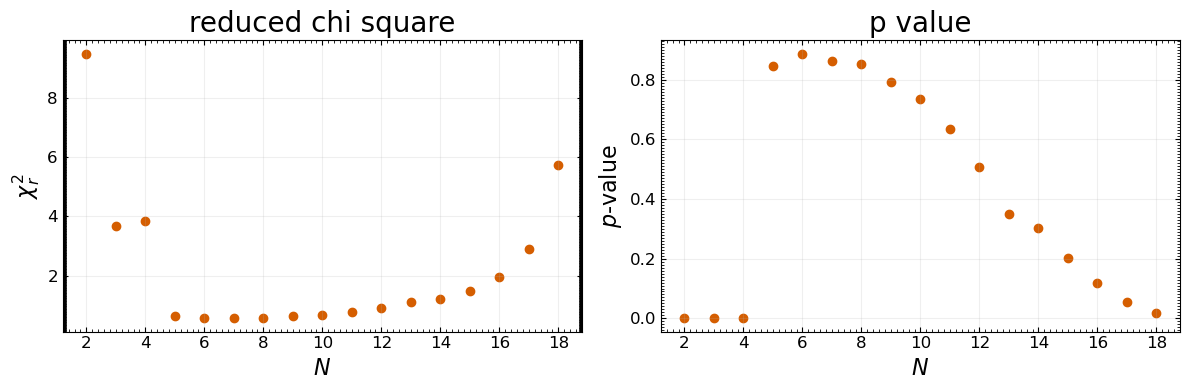

In [51]:
# Your code here

from scipy.stats import chi2 # This is the chi-square distribution, not the chi-square statistic

N_list=range(2,20) # order of polynomial, maximum power is x^N where N=N_list[i]

mobj_ex1_list = [] # list of the Minuit objects
chir_list=[]
pvalue_list=[]
for N in N_list:
    #print ("Fitting order {:d} polynomial".format(N))
    
    # First set the initial parameter values to be [0,0, ..., m_est,c_est]
    # Length of this initial parameter value list sets the order of polynomial fitted
    initial_argument_list = [0]*N # Set all coefficient values of polynomial to be zero 
    initial_argument_list[-1] = c_est # set last one equal to c estimate
    initial_argument_list[-2] = m_est # set second last one equal to c estimate
    
    # Now define Minuit object then minimise
    mobj_ex1_pn = Minuit(least_squares_ex1, initial_argument_list )
    mobj_ex1_pn.migrad() # No graphical output produced here by default 
    mobj_ex1_pn.hesse() 
    mobj_ex1_list.append(mobj_ex1_pn )
    
    """ Any of the following can be used to see information on the fit
    
    display(mobj_ex1_pn.fmin)

    for param in mobj_ex1_pn.params:
        print('{} = {:.4f} +/- {:.4f}'.format(param.name, param.value, param.error))
        
    """

    chir_list.append(mobj_ex1_pn.fmin.reduced_chi2)
    #print( f" chi^2/dof = {mobj_ex1_pn.fval:.2f} / {mobj_ex1_pn.ndof:.0f} = {mobj_ex1_pn.fmin.reduced_chi2:.2f}")  
    
    # for this line see week 3 "Calculating p-values from $\chi^2$ tests"
    pvalue = chi2.sf(mobj_ex1_pn.fval, mobj_ex1_pn.ndof)
    pvalue_list.append(pvalue)
    #print( f" p-value is {pvalue:5.3f}\n")
    
for iii in range(len(N_list)):    
    N = N_list[iii]
    print ("Fitting order {:d} polynomial".format(N)
           +f" reduced chi square = {chir_list[iii]:.2f}, p-value is {pvalue_list[iii]:5.3f}")

fig, ax = plt.subplots(1,2,figsize = (12,4))

ax[0].set_xlabel(r'$N$',fontsize = 16)
ax[0].set_ylabel(r'$\chi^2_r$',fontsize = 16)
ax[0].scatter(N_list,chir_list,color='#D55E00')

ax[0].tick_params(direction='in',top=True,right=True,which='both',labelsize =12)
ax[0].xaxis.set_minor_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.01))
#ax[0].legend() #(loc='upper left')
ax[0].set_title('reduced chi square',fontsize = 20)
ax[0].grid('xkcd:dark blue',alpha = 0.2)

ax[1].set_xlabel(r'$N$',fontsize = 16)
ax[1].set_ylabel(r'$p$-value',fontsize = 16)
ax[1].scatter(N_list,pvalue_list,color='#D55E00')

ax[1].tick_params(direction='in',top=True,right=True,which='both',labelsize =12)
ax[1].xaxis.set_minor_locator(MultipleLocator(0.2))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.01))
#ax[1].legend() #(loc='upper left')
ax[1].set_title('p value',fontsize = 20)
ax[1].grid('xkcd:dark blue',alpha = 0.2)

fig.tight_layout()

The table of values is just as effective as the plot. Again we clearly se $N=5$ is the most effective value to use, best result for least number of parameters. The overfitting can be seen as the $\chi^2_r$ values get too good, the p-values get too small. 

<div style="background-color:#C2F5DD">

End of exercise 2



## Parameter uncertainties, covariances and confidence intervals

You will have seen when we did our simple example, we called `Minuit.hesse` after running the minimisation, to calculate the error accurately. In fact, `iminuit` has two different methods for calculating the uncertainty on parameter estimates, referred to as Hesse and Minos. These two algorithms sound fancy, but they just correspond to the two different methods we saw earlier:

* Hesse numerically calculates the second derivative of the cost function with respect to the parameters to form a matrix then inverts it to find the error matrix (called the Hesse matrix)
* Minos examines the cost function near the minimum to find where the cost function changes by `errordef`, a value specific to the cost function. This can give asymmetric errors.

The two main cost functions we use are the chi-squared and the negative log-likelihood (so it is still a minimisation problem). The `errordef` parameter is equal to 1 for the chi-squared, and 0.5 for the negative log-likelihood, as we would expect from our discussion of fitting earlier. 

We can easily visualise the covariance matrix:

In [52]:
mline.covariance

,m,c
m,0.00909,-0.0045 (-0.845)
c,-0.0045 (-0.845),0.00318


After we have calculated the covariance matrix by running `Minuit.hesse`, we can also find the correlation matrix:

In [53]:
mline.covariance.correlation()

,m,c
m,1,-0.8
c,-0.8,1


Correlation is in generally not necessarily bad, but if you can redefine the parameters of the fit function it is generally good to choose parameters which are not strongly correlated.



In general, it is best to use `hesse` by default to calculate parameter uncertainties and we will aim to stick with this for the remainder of the course.

It is also possible to draw confidence regions easily using `iminuit`; for example, we can draw a matrix of contours for the $1\sigma$ confidence interval for all parameters:

(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='m', ylabel='c'>, <Axes: xlabel='c'>]], dtype=object))

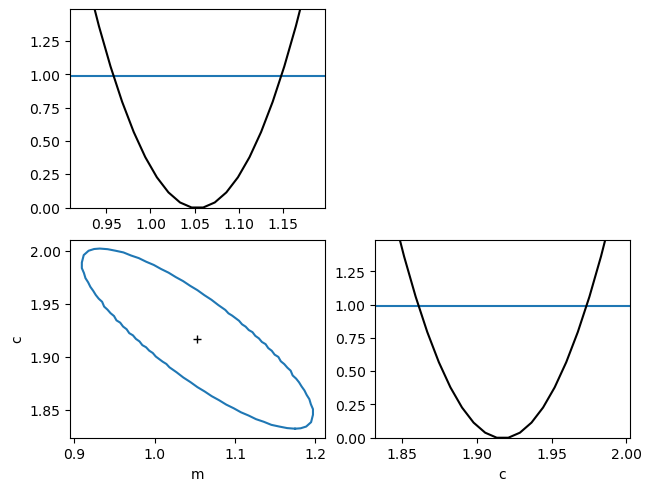

In [54]:
mline.draw_mnmatrix()

The top-left to bottom-right diagonal plots show the 1D profiles around the minimum of each parameter, while the other plots show the 2D contour in the two parameters. 

We can also draw contours at specified confidence levels, such as the levels corresponding to 1, 2 and 3 $\sigma$ in the Gaussian case, using [`Minuit.draw_mncontour`](https://iminuit.readthedocs.io/en/stable/reference.html#iminuit.Minuit.mncontour):



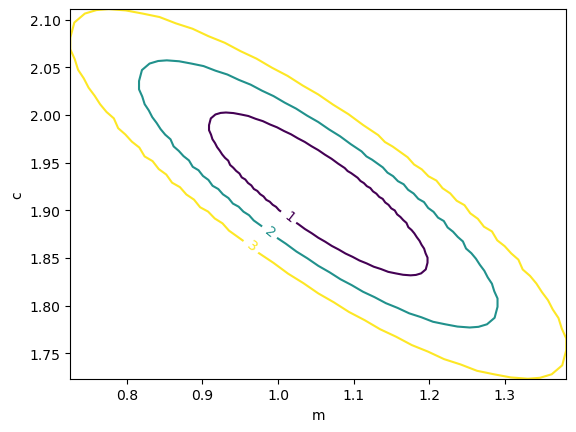

In [55]:
# CARE. mline.contour is closely related but different. Be sure you understand what these are doing.

mline.draw_mncontour("m","c",cl=(1,2,3))


We can draw the 1D profiles using `Minuit.draw_profile`:

(array([0.86247013, 0.86632251, 0.87017488, 0.87402726, 0.87787963,
        0.881732  , 0.88558438, 0.88943675, 0.89328913, 0.8971415 ,
        0.90099387, 0.90484625, 0.90869862, 0.912551  , 0.91640337,
        0.92025574, 0.92410812, 0.92796049, 0.93181287, 0.93566524,
        0.93951761, 0.94336999, 0.94722236, 0.95107474, 0.95492711,
        0.95877948, 0.96263186, 0.96648423, 0.97033661, 0.97418898,
        0.97804135, 0.98189373, 0.9857461 , 0.98959848, 0.99345085,
        0.99730323, 1.0011556 , 1.00500797, 1.00886035, 1.01271272,
        1.0165651 , 1.02041747, 1.02426984, 1.02812222, 1.03197459,
        1.03582697, 1.03967934, 1.04353171, 1.04738409, 1.05123646,
        1.05508884, 1.05894121, 1.06279358, 1.06664596, 1.07049833,
        1.07435071, 1.07820308, 1.08205545, 1.08590783, 1.0897602 ,
        1.09361258, 1.09746495, 1.10131732, 1.1051697 , 1.10902207,
        1.11287445, 1.11672682, 1.1205792 , 1.12443157, 1.12828394,
        1.13213632, 1.13598869, 1.13984107, 1.14

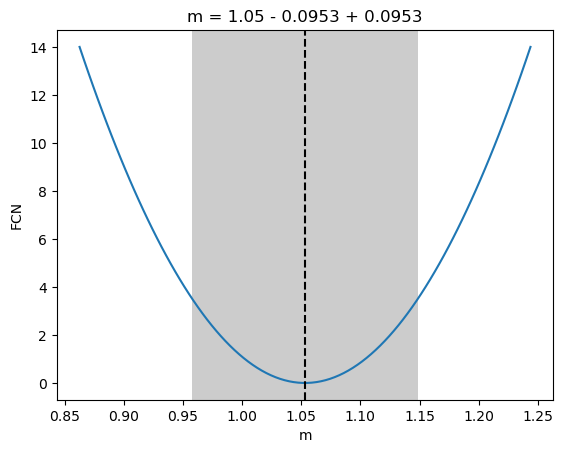

In [56]:
mline.draw_profile("m")

If you want to get the profiles or contours to plot yourself (to make it easier to improve formatting etc), you can use `Minuit.mnprofile` and `Minuit.mncontour` respectively:

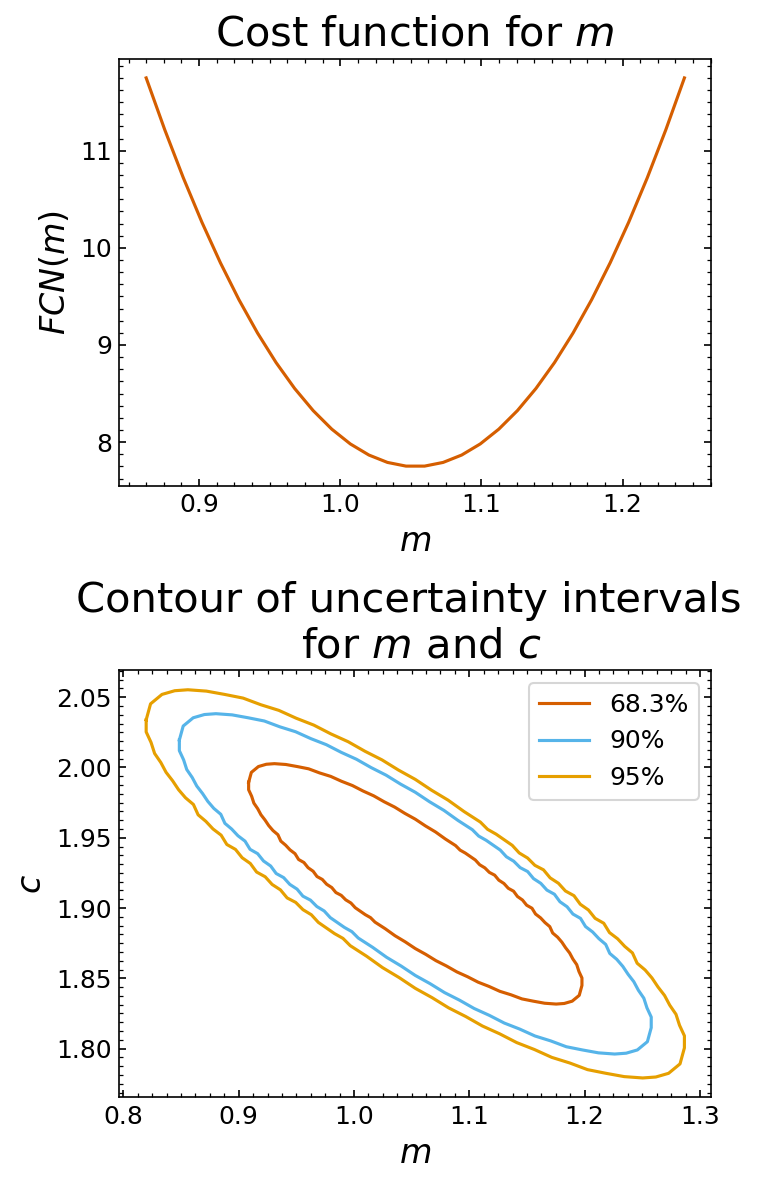

In [57]:
# Colours are from Okabe_Ito list, see appendix week 1.
m_h, Lm_h, _ = mline.mnprofile("m")

pts_1 = mline.mncontour("m","c",cl=0.683, size = 100)
pts_2 = mline.mncontour("m","c",cl=0.9,size = 100)
pts_3 = mline.mncontour("m","c",cl=0.95,size = 100)
fig, ax = plt.subplots(2,1,figsize = (5,8),dpi = 150)
ax[0].plot(m_h,Lm_h,color='#D55E00')
ax[0].set_xlabel('$m$', fontsize = 16)
ax[0].set_ylabel(r'$FCN(m)$',fontsize = 16)
ax[0].tick_params(direction='in',top=True,right=True,which='both',labelsize = 12)
ax[0].xaxis.set_minor_locator(MultipleLocator(0.0125))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.125))
ax[0].set_title('Cost function for $m$',fontsize = 20)

ax[1].plot(pts_1.T[0],pts_1.T[1],color='#D55E00',label = '68.3%')
ax[1].plot(pts_2.T[0],pts_2.T[1],color='#56B4E9',label = '90%')
ax[1].plot(pts_3.T[0],pts_3.T[1],color='#E69F00',label = '95%')
ax[1].set_xlabel('$m$',fontsize = 16)
ax[1].set_ylabel('$c$',fontsize = 16)
ax[1].tick_params(which='both',direction='in',top = True, right = True,labelsize = 12)
ax[1].xaxis.set_minor_locator(MultipleLocator(0.0125))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.025/4))
ax[1].legend(loc='upper right',fontsize = 12)
ax[1].set_title('Contour of uncertainty intervals \n for $m$ and $c$',fontsize = 20)

fig.tight_layout()

<hr style="border:2px solid gray">
<a id='section5'></a>


# Section 5: Curve Fitting and Binning, Maximum-Likelihood and `iminuit`  [^](#outline)

So far, we have not used binned data. All our data was set of $(X,y)$ points and we compared that to a function $f(X)$. The comparison has always used the least squares, the chi square statistics, as a way to assess how good the fit was. In this section, we will consider the effect of binning data, something which you might want to do whatever method you use when fitting data.  While considering this aspect we will also work consider an alternative approach to the least square method, the popular maximum likelihood method.


So far, we have looked at simple fits using `LeastSquares`, which is the `iminuit` implementation of the chi-squared parameter estimation method. In practice, many applications use maximum-likelihood estimation, which is also implemented in several ways in `iminuit`. 



We will discuss both unbinned and binned maximum-likelihood fitting using `iminuit`. These differ as follows:

* Unbinned fits apply directly to the raw data sample. The easiest to use, but can become slow when the sample size is large.
* Binned fits are applied to binned data, which means you must appropriately bin your sample. The binning has to be fine enough to retain all the essential information. These are in general much faster than unbinned fits. 

We will discuss how we can do both of these using `iminuit` in turn. We will demonstrate both methods using the same dataset which is a standard example from high-energy physics, the fit of a peak over a smooth background. We will assume a constant background.

## Counts and Binning

The previous section worked with raw data in the form of a set of $(X_i,y_i)$ measurements where $i$ is the index of each measurement. We may also have an estimate of the errors in $y_i$. A typical example would be the data on our pendulum where we are given data as $(L_i,T_i,\Delta T_i)$ so $X=L_i$ is the independent variable (we set the length of the pendulum in the experiment), $T_i=y_i$ is the dependent variable (we find out what this given $L_i$) and $\Delta T_i$ is our estimate of the error in our measurement. (Aside: so far we have ignored the fact that there will also be an error in our measurement of length too but that question is for another day or see how I sidestepped this in one of the exercises in week 3. Lets just assume in this course that the errors in $X_i$ are always negligible.)


### Independent events

Suppose though, that our data is in the form of events. Formally $X_i=i$, each event is simply the next independent event, and all we do is measure some property $y$ of each event. Our data is then simply the list of $y_i$ values as the order in which they came tells us nothing.  

This is very common in wider science.  For instance in medical studies we might have a series of independent subjects in our medical trial, and we measure some property of each subject, e.g. the height.

In physics, the classic example is particle physics. At CERN, each collision is captured in the detectors independently from every other collision. The physicists will look for, say, the energy of a particular particle emerging from the collision (yes, there are lots of particles emerging so there is a lot of work to get to the simple data we will use in the exercises here). The data then is simply a list of the energies of particles. 

Our predictions come in the form of a probability distribution function $f(X; \theta)$ that for a given theory where $\theta$ represent a set of parameters in our theory we want to find e.g. the mass of predicted new particles. In particle physics a lot of difficult calculations (see QFT, Unification and APP courses in fourth year physics or all the courses in the QFFF MSc), tell us the probability $f(X; \theta)dX$ of finding our particle between energies $X$ and $X+dX$. 

Now we could just use the KS test to decide if the cdf $F(X; \theta)$ of our theory is a good fit to the data. We construct a CDF of the data by counting the fraction of events $F_\mathrm{data}(X; \theta)$ that have energy less than $X$. In this context, we would vary the parameters $\theta$ in our theory (e.g. masses of predicted particles) until we found the best fit (minimum $D$ for the KS test). 


#### Definition of Binned Data (Reminder)

A popular way to deal with such data of events is to gather up the data up into **bins**. That is we work with the number of events $n(b)$ in bin $b$ where the index $b$ runs from $1$ to the number of bins. Bin $b$ is defined to contain all the events whose energy $y_i$ lies between $X_{b-1}$ and $X_{b}$. Note the change of notation is because we decide where the bins are, the $X_b$ are independent variables set up and chosen by us. The universe decides what is the energy of each particle measured will be, the $y_i$ in the original data are dependent variables.  Also note that the number of these **bin edges** $X_b$ is one more than the number of bins.

Now we compare the pairs $(b,n(b))$ to the prediction $N(F(X_{b}; \theta) - F(X_{b-1}; \theta) )$ where $N$ is the total number of events we have, so $N = \sum_b n(b)$. (EFS: why do we need the cdf here?) So we have now reduced the problem to onw of a series of $(X,y)$ measurements as we had in the previous section, where the bins (or some property of each bin such as the index or mean of the bin edge values) play the role of our independent variable $X$ and the counts $n(b)$ play the role of the dependent variables $y$.

#### Pros and Cons of Binning Data

A general rule in statistics is to try and do a little manipulation of the data as possible. Try and work with the raw data to avoid introducing additional problems. For instance, with bins a big question that can have a significant effect on results is what bins to choose. By definition, binning reduces the number of data points you have so you have lost information on your system.  You do not always know if that was important information you lost or mostly irrelevant noise. 

So unbinned fits are ideal when the data sample isn't too large or very high dimensional.
If your statistical tools are appropriate, finding a genuine signal in the data is exactly what they should be able to do. 

The downside of unbinned data is that these can be very inefficient for large samples and can even become numerically unstable. So binning out of necessity is an acceptable reason.

#### Approximating the predicted count in a bin

Finally note that using the cdf to find the predicted value from a theory for each bin can be time consuming. So many people use the following *approximation* often without comment (but you will all remember that this is an approximation for that time when it makes a difference). 
* Let $p_b$ be the predicted value for the probability of finding an event in bin $b$. 
* Then $p_b$ is approximately equal to the the width of bin $b$, $(X_{b} - X_{b-1})$, multiplied by the typical probability density of that bin.
* Assuming bins are not too wide so the PDF does vary much across the bin, we can use the probability density in the centre of the bin at $\bar{X}_b = (X_{b} + X_{b-1})/2$ as a good measure of the probability density in the bin, that is $f(\bar{X}_{b}; \theta)$.
* If we have $N$ events in total then the approximate prediction for the number of events in the bin will be $Np_b$.

To summarise, we often use (as I do in the exercises at the end of the notebook) the following formula
$$
n(b) \approx (X_b - X_{b-1}) \, f(\bar{X}_{b}; \theta) \, , \quad \text{where} \quad \bar{X}_b = (X_{b} + X_{b-1})/2 \, .
$$

EFS: Optional. This is simple to derive using the Taylor expansion. The derivation is given as an appendix here too.

#### Choosing your bins

There is no perfect way to choose bins, so no simple set of rules I can give you. There are, however, many ways to work with badly binned data. So all I can give is a few suggestions and we will look at one example in the exercises later.

The main rule is to avoid bins that have counts that are too low.  They will be noisy and so tell us little. In fact their noise may hinder the numerical process to find the good fit that is there for the data.

In particular if you assume that the counts in each bin follow Poisson statistics rather than Binomial statistics (a common simplification), then try not to have less than a count of 5 events in any one bin. This is not an exact number (10 might be better) but the message is that the Poisson approximation is poor for bins with low numbers as the variation is large. So again it is a low count/ high noise issue.

Bins with zero counts are a particular problem.  People often ignore them but having nothing in a bin is non-trivial information ("The dog did nothing in the night-time.", "That was the curious incident," remarked Sherlock Holmes. [The Hound of the Baskervilles](https://en.wikipedia.org/wiki/The_Hound_of_the_Baskervilles)). Including them (empty bins, not quotes from Shelock Holmes) without any changes to your code may cause errors as most codes are designed for large or at least positive numbers. Including them is possible but may require a lot of work and pehaps it does not help you much (see discussion of low count bins again).

So an obvious route forward is to choose fewer bins with larger widths. 
Clearly, if the bins are too large (everything in one bin) you learn nothing. You may miss a small signal which gets hidden under the large numbers of wide bins. 
So there is some unquantifiable sweet spot between too many bins and too few bins.

Other tricks might include dropping some bins at the extreme end of the data.  That might be justified if these contain few events anyway, they are noisy.

You do not have to use bins of the same sizes. When the counts get much rarer very fast as $X$ gets bigger, then *logarithmic binning* is useful. This is where we set the bin boundaries to satisfy  $X_{b}=r X_{b-1}$ for some ratio $r>1$. Perhaps having one large bin for everything over a certain value of $X$ is useful.



### Maximum Likelihood

Apart from binning, the other theme of this section is the **Maximum Likelihood** approach to parameter estimation and curve fitting. This gives an alternative to the least squares method we considered above and we minimise a different loss function to find the best value for parameters. Again, see the notes from Statistics and Measurement course (also provided on Blackboard as part of this course) for details. 

A quick reminder. Suppose we have a set of events where for each event $i$ we measure some quantity $x_i$ e.g. for the $i$-th collision at CERN we measure the energy $x_i$ of some particle. (Note I have flipped my notation as everyone talks in terms of random variable $x_i$ being measured at each event. I will now follow the same convention).

For each event our theory predicts that this event $i$ happens with probability $p_i$ where $p_i = f(x_i; \theta)dy$ if we have a continuous variable $x$ or simply $f(x_i; \theta)$ if it is discrete. The probability $P_N(\theta)$ predicted by our theory with parameters $\theta$ that in $N$ measurements we would have found the $x_i$ data values actually found in the experiment is simply the product of the individual $p_i$. That is
$$
P_n (\theta) = \prod_{i=1}^{N} p_i  = \prod_{i=1}^{N} f(x_i; \theta) dx_i \,  .
$$
Note we set $dx_i$ to be 1 for the discrete case. The best fit of our theory to the data comes from  the parameters $\theta$ that maximise this probability. 

Numerically is is much more convenient to minimise the negative log of this function which is guaranteed to give the same answer. So the cost function we use is the (negative) log likelihood $L$ where
$$
L = - \log(P_n (\theta)) = \sum_{i=1}^{N} \log(f(y_i; \theta)) \,  .
$$

Aside. The more observant will notice that we have dropped a term equal to the sum of $\log(dx_i)$. This is not present for discrete valued $x$ ($dx=1$ in this case). For continuous variables, this $dx_i$ can be considered some sort of uncertainty. If it is the same for all variables, these add an irrelevant constant. In more sophisticated problems, we might need to reexamine this aspect more carefully.  However, in all the problems we consider, we will use the form for $L$ given here.

#### Example data

Let us start by generating some data we will use in the following examples. Note how we use binning to visualise this data here but the data is actually from a continuous distribution. We could have shown the cumulative distribution of the data and of the theoretical function to avoid binning. 

To perform an unbinned fit, you must provide the (vectorized) PDF of the model i.e. a numpy function or a scipy function. The PDF must also be normalised. 

We will consider an example of a Gaussian peak over a constant background. The corresponding model PDF is the weighted sum of the normal and uniform PDFs. We will only consider $X$ values between 0 and 1, so the uniform component is parameter-free. The parameters of the model are therefore $\mu$ and $\sigma$ of the normal distribution, and $z$, the weighting factor which takes values between zero and one. We can write the total PDF as

\begin{equation*}
f(X; z, \mu, \sigma) = zf_{\text{normal}}(X; \mu, \sigma) + (1 - z)f_{\text{uniform}}(X)
\end{equation*}

where $f_\text{normal}(X; \mu, \sigma)$ and $f_\text{uniform}(X)$ denote the normal and uniform PDFs respectively.

Data generated using mu=0.000, sigma=0.100,  z=0.286 


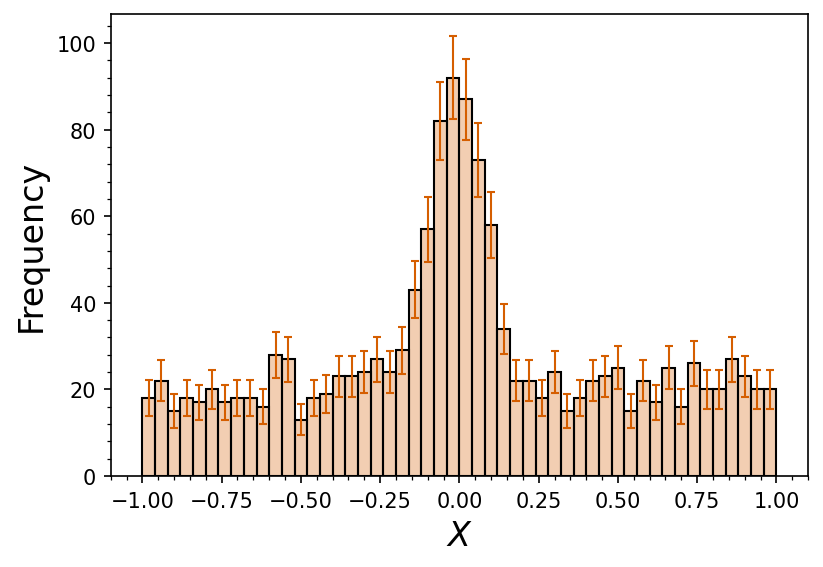

In [58]:
from scipy.stats import norm, uniform
from matplotlib.colors import to_rgba
from matplotlib.ticker import MultipleLocator

xrange = -1, 1
rng = np.random.default_rng(1)

mu_value = 0.0
sigma_value = 0.1
n_normal = 400
n_uniform = 1000
z_value =  n_normal/(n_normal+n_uniform)
print("Data generated using mu={:.3f}, sigma={:.3f},  z={:.3f} ".format(mu_value,sigma_value,z_value))
# EFS: we don't stop the Gaussian from ranging outside -2 to 2 range. Does it matter?
x_data = rng.normal( mu_value, sigma_value, size = n_normal) 
x_data = np.append(x_data, rng.uniform(*xrange, size = n_uniform))

# n ,xe= 
counts, bin_edges = np.histogram(x_data, bins = 50, range = xrange)
x_bin_centre = 0.5*(bin_edges[1:]+bin_edges[:-1])
dx = np.diff(bin_edges)

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.bar(x_bin_centre, counts, yerr = counts**0.5, 
       width = dx,
       fc=to_rgba('#D55E00',0.3),edgecolor='black',
       error_kw={'ecolor':'#D55E00','capsize':2,'elinewidth':1,'capthick':1})
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))


### Unbinned maximum-likelihood fits


We will use our mixture of data drawn from either a Gaussian or a uniform distribution.

First we need to set limits on our parameters to prevent this problem from becoming mathematically undefined. In this case, we want our signal to be within the range $-1 \lt X \lt 1$, and so we require that

\begin{align*}
0 \lt &z \lt 1 \\
-1 \lt &\mu \lt 1 \\
&\sigma \gt 0
\end{align*}

Now we have everything, we can try the fit. This uses the [`UnbinnedNLL`](https://iminuit.readthedocs.io/en/stable/reference.html#iminuit.cost.UnbinnedNLL) ("Unbinned Negative Log-Likelihood) function fro iminuit.

In [59]:
from iminuit.cost import UnbinnedNLL

def model_pdf(x, z, mu, sigma):
    return (z*norm.pdf(x, mu, sigma) + (1-z)*uniform.pdf(x, xrange[0], xrange[1]-xrange[0]))

cost_function = UnbinnedNLL(x_data, model_pdf) # only need to pass the samples we have

m_obj = Minuit(cost_function, z = 0.4, mu = 0, sigma = 0.2) # arbitrary starting parameters
m_obj.limits['z'] = (0,1) # Set limit on z
m_obj.limits['mu'] = (-1, 1) # Set limit on mu
m_obj.limits['sigma'] = (0, None) # Set lower limit on sigma

m_obj.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1504                       │              Nfcn = 83               │
│ EDM = 3.42e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.275   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000298        -0  0.037e-3 │
│    mu │        -0  3.79e-05 -0.002e-3 │
│ sigma │  0.037e-3 -0.002e-3  3.22e-05 │
└───────┴───────────────────────────────┘

We can then visualise the result a little better. 

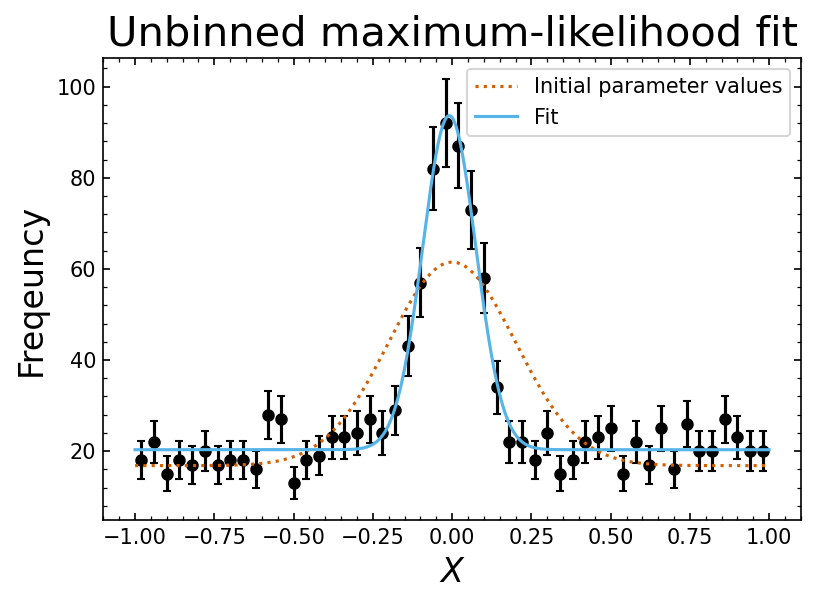

In [60]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi = 150)
ax.errorbar(x_bin_centre, counts, counts**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)

xm = np.linspace(bin_edges[0],bin_edges[-1],1000)
ax.plot(xm, model_pdf(xm, *[p.value for p in m_obj.init_params])*len(x_data)*dx[0], 
             ls = ':', label='Initial parameter values',color='#D55E00',zorder = 1)
ax.plot(xm, model_pdf(xm, *m_obj.values)*len(x_data)*dx[0], 
             label='Fit',color='#56B4E9',zorder = 1)
ax.legend(loc='upper right')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Freqeuncy',fontsize = 16)
ax.set_title('Unbinned maximum-likelihood fit',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.tick_params(direction='in',which='both',top=True,right=True)


Finally, we can look at the uncertainty in the best fit parameters. Comparing with the values used to generate the data, we can see the best fit values are statistically consistent. 

We could go through all the hypothesis testing, p-values etc if we wanted to make this conclusion more precise.

In [61]:
# Calculate error using hesse

hhh = m_obj.hesse() # calculate parameter uncertainties

for param in m_obj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))



z = 0.28 +/- 0.02
mu = -0.01 +/- 0.01
sigma = 0.08 +/- 0.01


### Binned maximum-likelihood fits

When we have large data samples, binned fits are more computationally efficient and numerically stable. However, you have to choose an appropriate binning, which is non-unique. 

For our example, we have a reasonably large sample (1400 events) and 50 bins is sufficiently fine to retain all information without having too few counts per bin. The maximum likelihood method applied to binned data gives correct results even if bins have no entries, so a binning that is very fine is not a problem and only increases computational cost. 

The cost functions for binned fits that are implemented in Minuit assumes that the bin counts are independently Poisson distributed about some unkown expected value per bin. This is correct for ordinary histograms. 

For a given PDF $f(X; \boldsymbol{\theta})$ with parameters $\boldsymbol{\theta}$, we can write the expected count $\lambda_i$ in a given bin with boundaries $a_i$ and $b_i$ as

\begin{equation*}
\lambda_i = \int_a^bf(X;\boldsymbol{\theta}) dX
\end{equation*}

The cost function for a binned maximum-likelihood fit is the sum of the logarithms of the Poisson probability for the count in each bin, as a function of the expected counts $\lambda_i$. This is again multiplied by -1 to go from a maximisation problem to a minimisation problem. However, instead of supplying a PDF we must provide a CDF in this case. We can approximate the CDF as bin-width multiplied by the PDF evaluated at the bin center if it is difficult to calculate, but this is only an approximation. Using an exact CDF is better.

Now we know what we need, we can define the CDF and run the fit:



In [62]:
from iminuit.cost import BinnedNLL

def model_cdf(xe, z, mu, sigma):
    return (z * norm.cdf(xe, mu, sigma) +
            (1-z) * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

bnll_cost_function = BinnedNLL(counts, bin_edges, model_cdf)

bnll_mobj = Minuit(bnll_cost_function, z = 0.4, mu = 0, sigma = 0.2)

bnll_mobj.limits['z'] = (0,1)
bnll_mobj.limits['mu'] = (-1,1)
bnll_mobj.limits['sigma'] = (0, None)

bnll_mobj.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.74 (χ²/ndof = 0.6)      │              Nfcn = 82               │
│ EDM = 1.88e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.274   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000302        -0  0.041e-3 │
│    mu │        -0   3.9e-05 -0.003e-3 │
│ sigma │  0.041e-3 -0.003e-3  3.49e-05 │
└───────┴───────────────────────────────┘

In [63]:
# Calculate error using hesse
hhh = bnll_mobj.hesse() # calculate parameter uncertainties

for param in bnll_mobj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))

z = 0.27 +/- 0.02
mu = -0.01 +/- 0.01
sigma = 0.08 +/- 0.01


The parameter values and uncertainty estimates are not identical to the unbinned fit, but they are very close. In statistical terms, our results are equivalent. This shows that the binning we have chosen is good enough to reveal the essential information in the data. 

We can then plot the result in a nicer format. 

Aside: thinking about this, I think it would be better to put the uncertainty on the fitted values.  The data points are exactly that, we have exactly one data point per bin.  The uncertainites on the data points are estimated from a theoretical principle. 

On the other hand, the theoretical work suggests we have a Binomial distribution in each bin with the analytic formula giving the mean value for the distribution in each bin. We should be plotting the mean value and then the known uncertainties (e.g. 1 sigma band) of this fitted theoretical probability distribution. Given the counts in each bin the Poisson distribution is a good approximation and much simpler to work with.

Also there is more uncertainty in the fitted form than we show.  We only show the form using the parameters that give the best fit here. 

However, what I show here is a fair enough representation.

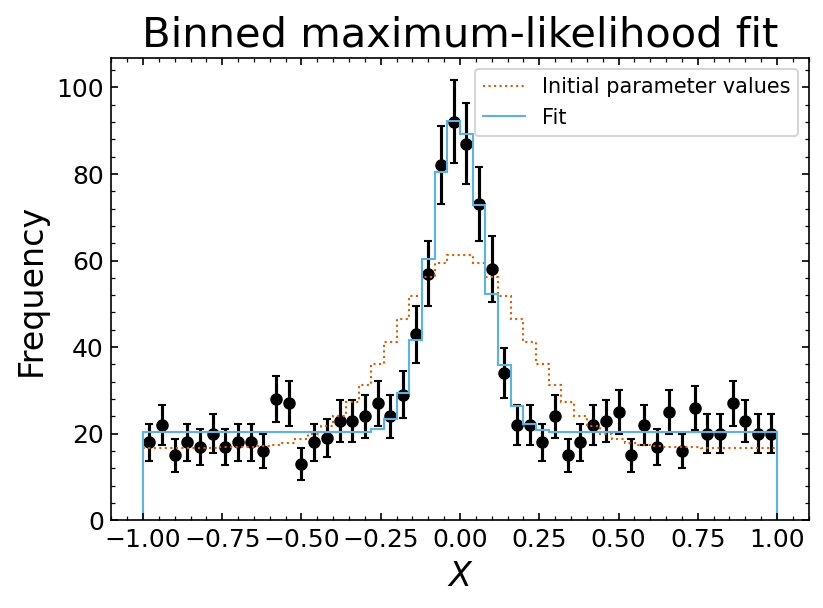

In [64]:
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.errorbar(x_bin_centre, counts, counts**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
ax.stairs(np.diff(model_cdf(bin_edges, *[p.value for p in bnll_mobj.init_params]))*len(x_data), 
          bin_edges, 
          ls=':',label='Initial parameter values',zorder = 1,color='#D55E00')
ax.stairs(np.diff(model_cdf(bin_edges, *bnll_mobj.values))*len(x_data), bin_edges, 
          label='Fit',zorder = 1,color='#56B4E9')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.set_title('Binned maximum-likelihood fit',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.legend(loc='upper right')
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

## Summary

In this section, you have seen how to do fitting using `iminuit`, including:

* The basics of fitting
* Details of the Minuit object
* How to set limits on parameters and fix values during fitting
* How to calculate and plot confidence intervals on fitted parameters
* Binned and unbinned maximum-likelihood fits

While we have covered many things here, this is by no means a comprehensive summary of `iminuit`. If you want to learn more, look at the [documentation](https://iminuit.readthedocs.io/en/stable/). The tutorials are in general very useful for understanding different approaches/techniques for fitting.

The following section covers the exercises for you to work through this week.

<hr style="border:2px solid gray">
<a id='exercises'></a>

# Exercises [^](#outline)

For the exercises this week, you will work through a problem that is very close to some real data. 

Note that some of these answers may contain more information and text than we would expect from students, say in an assessment. We sometimes use our answers to highlight issues and to illustrate ideas, sometimes outside the range of the course, and to do that we may add a wider range of numerical outputs and text. 

#### Data for remaining exercises

The data you will use for the remaining exercises is a list of the energies in GeV (our X variable) of particles seen in an experiment.  The theory is that in general we will get a "background" of particle production from all sorts of boring physics we are not interested in. What we are looking for are rare events, the "signal", where a new particle has been produced. These rare events will be seen as extra events on top of the background but these extra events are all at energies centred around the mass of the new particle and with a small width (the width is related to the decay rate of the particle, it won't be stable).

To find the new particle we will have a theoretical pdf representing some prediction for the shape of the background plus signal. This pdf has six parameters which we must fit to the data, e.g. the centre of the signal peak is a parameter representing the mass of the new particle.

We do not try to fit the raw data directly to the pdf (EFS: we could use a method from week 3 to do this, which one?). Instead we will first bin the data and then we will try to find values for the six parameters of our theory that give the best fit to the binned data.

The first job is to look at the data and then to decide how to bin it and what part is useable in order to give us a reasonable chance of success. That is what we start with in exercise 3. Each exercise builds up step by step until by exercise 7 we hopefully find out the mass of the new particle if the data suggests one is present.

<div style="background-color:#C2F5DD">

### Exercise 3

The data you will use for the remaining exercises is saved in a file named "signal". The code cell below will load this data in using `pickle`. 
    
Investigate this data.  This is what you should always try to do before diving into analysis.  You want to get a quick feel for the data. However, in thei exercise you must decide on two aspects of the analysis of this data. You must fix aspects (the parameter used to encode this are examples of hyper parameters in the ML langauge we use later):
* The number of bins to use for the data, equivalent to fixing the bin width. If we have few but very wide bins, we might not see the peak representing the new particle. If there are lots of small width bins, many bins will have small counts or even zero, so they will be too noisy to use.
* The range of data to include. We don't want to include regions of low counts as this will be noisy and will not help us find the signal for the new particle (if any).

To do this plot a histogram of the raw data sample from this file to fix:
* an `n_bins` parameter, the number of bins used,
* choose the range of X (energy/GeV) values to include. Use as much of the data as you can.
    
You must use a Markdown cell to explain your reasons for your choice of these two parameters.
    
Finally produce the data in the form you will use in the remaining exercises. That is, the energy values and counts (frequency) in each bin.
    
You may use any data structure and any names you like. I used two one-dimensional numpy arrays `data_x` and `data_y` of the same length with, respectively, the energy values and counts (frequency) in each bin. It might help you to do the same when comparing against my answers.

In [2]:
# Read in data
import pickle as pk

with open('signal','rb') as infile:
    signal_data = pk.load(infile)   

# Start with some basic measurements of the data
print(signal_data.shape)
print(" Number of data points is "+str(len(signal_data)))
print(" X (energy/GeV): min={:.2f}, max={:.2f}".format(min(signal_data),max(signal_data)))

(30550,)
 Number of data points is 30550
 X (energy/GeV): min=90.00, max=226.12


50 bins giving average number of data points per bin is 611.0
We have 14 bins with counts less then 5 starting from 183.9
100 bins giving average number of data points per bin is 305.5
We have 36 bins with counts less then 5 starting from 173.7
200 bins giving average number of data points per bin is 152.8
We have 81 bins with counts less then 5 starting from 168.6
400 bins giving average number of data points per bin is 76.4
We have 185 bins with counts less then 5 starting from 153.8


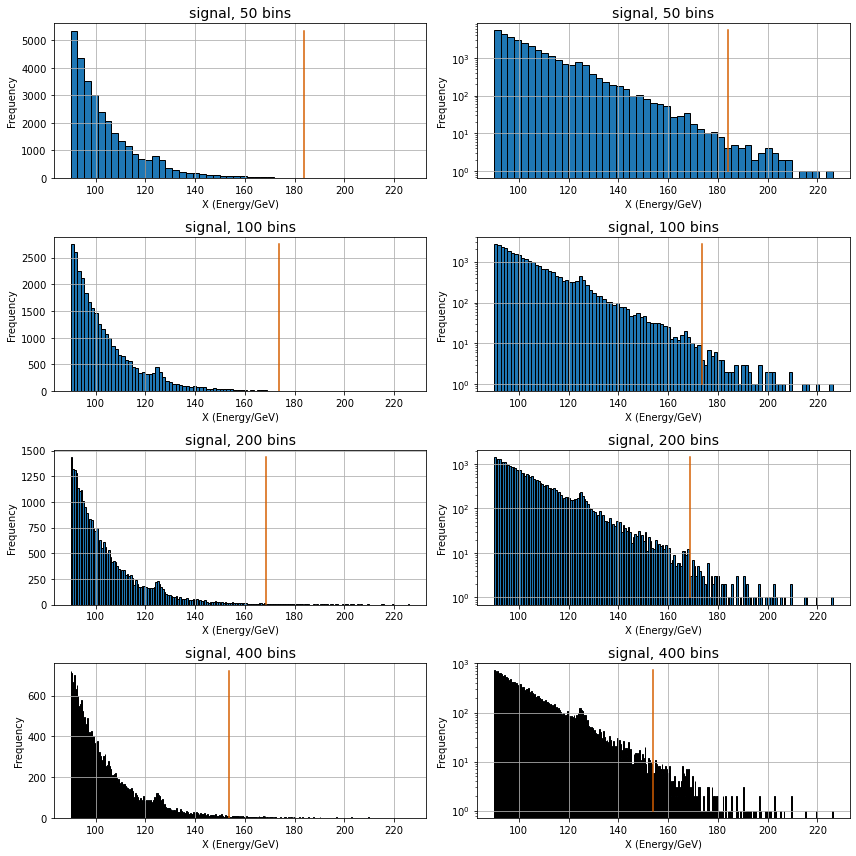

In [65]:
# Your plotting code here
# I suggest you show just have one simple plot and you change the parameters 
# by hand several times to find the right parameters to use

# I have put several into one plot to show you the sort of things you might see

min_bin_count = 5

n_bin_list=[50,100,200,400] # these are the n_bin values we might consider, change or add to them 
n_bin_values = len(n_bin_list)
fig, axs = plt.subplots(n_bin_values,2,figsize = (12,12)) 
    
for rrr in range(n_bin_values): # row for each distinct number of bins value
    n_bins = n_bin_list[rrr]
    print(str(n_bins)+" bins giving average number of data points per bin is {:.1f}".format(len(signal_data)/n_bins))    
    
    for ccc in [0,1]: # two columns: one for normal axes plot and one for plot with log y axis.
        if ccc==1:
            axs[rrr,ccc].set_yscale('log')
        axs[rrr,ccc].set_title("signal, {:d} bins".format(n_bins),fontsize= 14)
        data_y, bins, ppp = axs[rrr,ccc].hist(signal_data , edgecolor='black', bins=n_bins)
        data_x = 0.5*(bins[1:]+bins[:-1]) # x value is centre of each bin
        x_small_bincount = data_x[data_y<min_bin_count]
        x_small_bincount_min = min(x_small_bincount)
        axs[rrr,ccc].plot( [x_small_bincount_min,x_small_bincount_min],
                           [1,data_y[0]], '-', color='#D55E00',)
        axs[rrr,ccc].grid()
        axs[rrr,ccc].set_xlabel('X (Energy/GeV)')
        axs[rrr,ccc].set_ylabel('Frequency')

    print("We have {:d} bins with counts less then {:d} starting from {:5.1f}".format(len(x_small_bincount),min_bin_count,x_small_bincount_min))

# Labels and titles of subplots often overlap so try this to solve that 
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

#### Discussion for Exercise 4

I ran my code for a single plot and one value for the number of bins several times to find a reasonable number of bins.  
The number of data points and the average number in a bin gives us a rough feeling for what is reasonable but having a number of bins in the 100's seems about right.  

We  see (even with just 50 bins) that there might be something interesting (the "signal" in particle physics terms) at around X=125 (i.e. energy 125 GeV). However we are not talking very many counts above the background so the statistics are low and this peak we see could just be random fluctuations. Notice how elsewhere there are peaks and troughs in the general trend.

When choosing the number of bins, equivalently choosing the width of the bins, there are two issues. The visibility of the signal (higher number of bins favoured) against having so many bins that the width is small so that the count (frequency) in many bins will be low or zero. Low counts are very noisy and the Poisson statistics approximation often used breaks down. 

Using a very large number of bins reduces the counts in each bin so the count in each bin is noisier and so less useful. So the suggest minimum, the brown line, moves to lower and lower energy values as the number of bins goes up (width of bins decreases).

#### Conclusions for `signal` data

I will use 200 bins but I will then cut off the noisy data at high energy (X) where many bins have less than a count of 5 in that bin. There is no perfect solution. Your choice might be different.  The reasons behind your choices are what we are looking for in assessments.

The last step here is to use these choices to prepare the data we use in the remaining exercises.

Note for clarity, I have chosen to produce numpy arrays `data_x` and `data_y` that already limited to the set of data I want to use.  You could also use the masks available in iminuit. 

In [66]:
# Set the number of bins to be used by the rest of this exercise
n_bins=200
print("\n*** FINAL choice for number of bins is "+str(n_bins))
min_bin_count = 5
print("*** Limit X to be below lowest X value of any bin containing counts less than  "+str(min_bin_count))

# Prepare data for rest of exercise
data_y_all, bin_edges_all = np.histogram(signal_data, bins = n_bins)
data_x_all = 0.5*(bin_edges_all[1:]+bin_edges_all[:-1]) # x value is centre of each bin

# Cutoff bins at high X with low numbers of counts
x_small_bincount = data_x_all[data_y_all<min_bin_count]
x_small_bincount_min = min(x_small_bincount) 
print("    We will drop {:d} bins starting from X={:5.1f} from our analysis".format(len(x_small_bincount),x_small_bincount_min))


# Now limit to data to final range of  X < x_small_bincount_min so data_y[i] >= min_bin_count = 5 
data_x = data_x_all[ data_x_all < x_small_bincount_min ] 
data_y = data_y_all[ data_x_all < x_small_bincount_min ] 


*** FINAL choice for number of bins is 200
*** Limit X to be below lowest X value of any bin containing counts less than  5
    We will drop 81 bins starting from X=168.6 from our analysis


<div style="background-color:#C2F5DD">

### Exercise 4

Now that you have prepared the data you think we should analyse, we will start by trying to fit a polynomial function using the `LeastSquares` cost function. We will use `np.polyval` to define our model. Try using different polynomial orders up to 10. Remember you can extract the value of the cost function from your Minuit object, using `m.fmin`, which will also tell you your reduced chi-squared value. What is the best reduced chi-squared you can get?
    
Hint: to use the chi square statistic, you need to provide errors on the counst in each bin.  WHat will you use for these errors and why?

Before we even start, we know from the semi-log histograms above that a polynomial fit to something that is basically looks like an exponential will be rubbish!

These are simple counts and the counts are never too small, bigger than 5 in my case. So we can reasonably assume the count in each bin behaves like a Poisson random variable. This means the standard deviation is estimated to be the square root of the count value in the bin (y) which is our best estimate for the mean of the Possion distribution in that bin. 

In [67]:
# Cost function doesn't like any error = 0 so make sure any that would be 0 are altered.
# Another sign that low counts don't match our other assumptions. 
# Luckily we cut those out this isn't an issue here
print("Lowest count in any bin is "+str(min(data_y)))
data_yerr = np.sqrt(data_y)

Lowest count in any bin is 5


In [68]:
# FROM NOW ON WE CAN REUSE THE CODE FROM EXERCISE 1 from this week.

# Our old friend the n-order polynomial
def line_np(x, par):
    return np.polyval(par, x)

In [69]:
# Define cost function a.k.a. loss function

signal_lsq_obj = LeastSquares(data_x, data_y, data_yerr, line_np)

In [70]:
# Define Minuit object
from iminuit import Minuit 

# Trying to fit straight line, y = m x + c
# The errors are small around values at indices 8 and 9 so try those
m_est = (y_measured[9]-y_measured[8])/(x_values[9]-x_values[8])
c_est = y_measured[8] - m_est*x_values[8]
print("For line y = mx + c fit, estimate m={:f}, c={:f}".format(m_est,c_est))

For line y = mx + c fit, estimate m=-8.733218, c=19.451659


In [71]:
# Run the minimisation, as in exercise 1

N_list=[4,5,6,8] # order of polynomial, maximum power is x^N where N=N_list[i]

mobj_signal_list = [] # list of the Minuit objects
for N in N_list:
    print ("Fitting order {:d} polynomial".format(N))
    
    # First set the initial parameter values to be [0,0, ..., m_est,c_est]
    # Length of this initial parameter value list sets the order of polynomial fitted
    initial_argument_list = [0]*N # Set all coefficient values of polynomial to be zero 
    initial_argument_list[-1] = c_est # set last one equal to c estimate
    initial_argument_list[-2] = m_est # set second last one equal to c estimate
    
    # Now define Minuit object then minimise
    mobj_signal_pn = Minuit(signal_lsq_obj, initial_argument_list )
    mobj_signal_pn.migrad() # No graphical output produced here by default 
    mobj_signal_pn.hesse() 
    mobj_signal_list.append(mobj_signal_pn )
    
    """ Any of the following can be used to see information on the fit
    
    for param in mobj_ex1_pn.params:
        print('{} = {:.4f} +/- {:.4f}'.format(param.name, param.value, param.error))
        
    display(mobj_ex1_pn.fmin)

    """
    print( f" chi^2/dof = {mobj_signal_pn.fval:.2f} / {mobj_signal_pn.ndof:.0f} = {mobj_signal_pn.fmin.reduced_chi2:.2f}")    
    


Fitting order 4 polynomial
 chi^2/dof = 696.11 / 111 = 6.27
Fitting order 5 polynomial
 chi^2/dof = 842.51 / 110 = 7.66
Fitting order 6 polynomial
 chi^2/dof = 368.14 / 109 = 3.38
Fitting order 8 polynomial
 chi^2/dof = 430.82 / 107 = 4.03


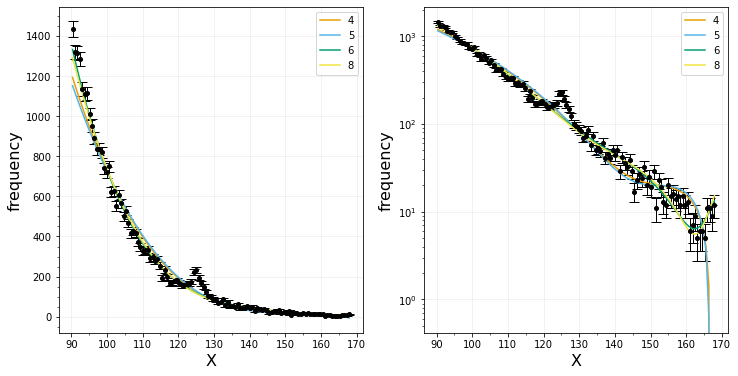

In [72]:
# Plot result, as in exercise 1, but double up with logarithmic y axis example.

fig, axs = plt.subplots(1,2,figsize = (12,6))

for fff in [0,1]:
    
    if fff==1:
        axs[fff].set_yscale('log')
    
    axs[fff].errorbar(data_x, data_y, yerr = data_yerr,
                color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)

    # X Values to use when showing fitted curve
    x_min = min(data_x)
    x_max = max(data_x)
    fit_x_values = np.linspace(x_min,x_max,100)

    # Colours from Okabe_Ito list in appendix of week 1
    Okabe_Ito =  ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

    # for each fit, plot a line
    for fit_number in range(len(mobj_signal_list)):
        mobj_signal_pn = mobj_signal_list[fit_number]
        fit_param_values = [ v for v in mobj_signal_pn.values]
        fit_y_values = line_np(fit_x_values, fit_param_values )
        axs[fff].plot( fit_x_values, fit_y_values, 
                color=Okabe_Ito[fit_number], 
                label=str(N_list[fit_number]) )

    # labels etc
    axs[fff].set_xlabel('X',fontsize = 16)
    axs[fff].set_ylabel('frequency',fontsize = 16)

    axs[fff].xaxis.set_minor_locator(MultipleLocator(20))
    axs[fff].xaxis.set_minor_locator(MultipleLocator(5))

    if fff==0:
        axs[fff].yaxis.set_major_locator(MultipleLocator(200))
        axs[fff].yaxis.set_minor_locator(MultipleLocator(50))


    #ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
    axs[fff].grid('xkcd:dark blue',alpha = 0.2)    

    axs[fff].legend(loc='best')



#### Comments on results of exercise 4

As expected the fits look pretty poor. They miss the signal and the log plot shows a lot of oscillations at high X, and poor fits at both high and low X. The reduced chi square values printed above the plots confirm this.

<div style="background-color:#C2F5DD">

### Exercise 5

Now try fitting the data with an exponential, again with the `LeastSquares` cost function. The function has been defined for you below. Discuss with the person next to you what you think good starting parameter values might be.
    
Is this a good fit?  Look at the visual output and calculate a goodness of fit measure.

In [73]:
def exp_distrib(x, a, b, c):
    return a*np.exp(-(x-b)/c)

In [74]:
# Define cost function a.k.a. loss function

signal_lsq_exp_obj = LeastSquares(data_x, data_y, data_yerr, exp_distrib)

Now we need to define some initial values. Let us assume the centre of the distribution is at $x=0$ so $b=0$. The semilog plots suggests this will work. That then gives us that for two points $(X_0,y_0)$ and $(X_1,y_1)$ we have that
$$ 
y_i = a \exp(-x_i/c) \, .
$$
Now take the ratio to find
$$ 
\frac{y_1}{y_0} = \exp(-(x_1-x_0)/c) 
$$
which eliminates $a$ (in fact it also removes $b$ if it is left in). Thus we can estimate $c$ as
$$
\ln(y_1/y_0) = -(x_1-x_0)/c 
\quad \Rightarrow  \quad
c = -(x_1-x_0) / \ln(y_1/y_0) \, .
$$
We then get $a$ from
$$
a = y_0 \exp(+x_0/c) \, .
$$

In [75]:
# Define Minuit object

# The errors are small around values at indices i0=0 and i1 so try those
i0 = 0 # lots of data at the start
i1 = int(0.5+len(data_x)/6) # noisy data at end so second point in middle of data set but avoid feature around X=125
print (f"Using X0={data_x[i0]:.1f} and X1={data_x[i1]:.1f} to estimate parameters")
b_est = 0
c_est = - (data_x[i1]-data_x[i0]) / np.log( data_y[i1] / data_y[i0] ) 
a_est = data_y[i0] * np.exp( (data_x[i0] - b_est) / c_est) 

print(f"For exponential distribution f(X) = a exp(-(x-b)/c), estimate a={a_est:g}, b={b_est:f}, c={c_est:f}")
est_form_str = f"f(X) = {a_est:.2g} exp( -(X-{b_est:4.2f}) / {c_est:4.1f})"
print ("    so fitting "+est_form_str)

# This does exactly the same job as mobj but isn't as clear to read.
signal_lsq_exp_mobj = Minuit(signal_lsq_exp_obj, a=a_est, b=b_est, c=c_est) 

print(signal_lsq_exp_mobj.init_params) # shows initial parameter values
#signal_lsq_exp_mobj.limits['a'] = (0,None) # set limit on a to be minimum of 0, no maximum
#signal_lsq_exp_mobj.limits['c'] = (0,None) # set limit on c to be minimum of 0, no maximum

Using X0=90.3 and X1=103.3 to estimate parameters
For exponential distribution f(X) = a exp(-(x-b)/c), estimate a=588710, b=0.000000, c=15.013027
    so fitting f(X) = 5.9e+05 exp( -(X-0.00) / 15.0)
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   589e3   │    6e3    │            │            │         │         │       │
│ 1 │ b    │    0.0    │    0.1    │            │            │         │         │       │
│ 2 │ c    │   15.01   │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [76]:
# Fit Minuit object

# minimise the least_squares cost function, i.e. find the best fit
signal_lsq_exp_mobj.migrad()  

signal_lsq_exp_mobj.hesse() # calculate parameter uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 302.7 (χ²/ndof = 2.7)      │              Nfcn = 94               │
│ EDM = 7.65e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  0.69e6   │  0.05e6   │            │            │         │         │       │
│ 1 │ b    │    2.3    │    1.1    │            │            │         │         │       │
│ 2 │ c    │   14.23   │   0.08    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │           a           b           c │
├───┼─────────────────────────────────────┤
│ a │     2.8e+09  -50.4478e3 -1.039820e3 │
│ b │  -50.4478e3         1.2      -0.022 │
│ c │ -1.039820e3      -0.022     0.00604 │
└───┴─────────────────────────────────────┘

In [77]:
# check fit valid but it looks good
print("Valid fit? "+str(signal_lsq_exp_mobj.valid))

Valid fit? True


In [78]:
# create a label for the best fit
a_value = signal_lsq_exp_mobj.params['a'].value
b_value = signal_lsq_exp_mobj.params['b'].value
c_value = signal_lsq_exp_mobj.params['c'].value
fit_form_str = f"f(X) = {a_value:.2g} exp( -(X-{b_value:4.2f}) / {c_value:4.1f})"
print (fit_form_str)

f(X) = 6.9e+05 exp( -(X-2.32) / 14.2)


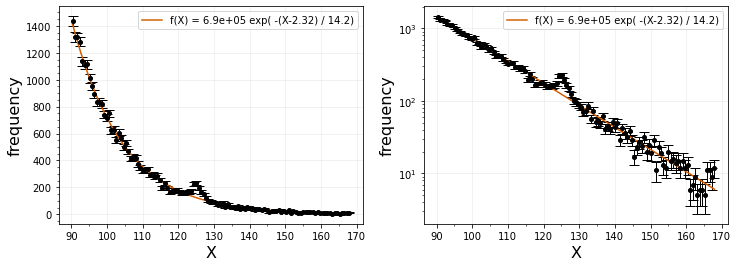

In [79]:
# Plot result, as in exercise 1, but double up with logarithmic y axis example.

fig, axs = plt.subplots(1,2,figsize = (12,4))

# X Values to use when showing fitted curve
x_min = min(data_x)
x_max = max(data_x)
fit_x_values = np.linspace(x_min,x_max,100)

for fff in [0,1]:
    
    if fff==1:
        axs[fff].set_yscale('log')
    
    axs[fff].errorbar(data_x, data_y, yerr = data_yerr,
                color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)

    # for each fit, plot a line
    #fit_param_values = [ v for v in signal_lsq_exp_mobj.values]
    fit_y_values = exp_distrib(fit_x_values, *signal_lsq_exp_mobj.values )
    axs[fff].plot( fit_x_values, fit_y_values, color="#D55E00", label= fit_form_str)

    #est_y_values = exp_distrib(fit_x_values, *signal_lsq_exp_mobj.init_values )
    #axs[fff].plot( fit_x_values, est_y_values, color="#009E73", label= fit_form_str)

    # labels etc
    axs[fff].set_xlabel('X',fontsize = 16)
    axs[fff].set_ylabel('frequency',fontsize = 16)

    axs[fff].xaxis.set_minor_locator(MultipleLocator(20))
    axs[fff].xaxis.set_minor_locator(MultipleLocator(5))

    if fff==0:
        axs[fff].yaxis.set_major_locator(MultipleLocator(200))
        axs[fff].yaxis.set_minor_locator(MultipleLocator(50))


    #ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
    axs[fff].grid('xkcd:dark blue',alpha = 0.2)    

    axs[fff].legend(loc='best')

In [80]:
# Now look at measures of goodness of fit
print( f" chi^2/dof = {signal_lsq_exp_mobj.fval:.2f} / {signal_lsq_exp_mobj.ndof:.0f} = {signal_lsq_exp_mobj.fmin.reduced_chi2:.2f}")  

# for this line see week 3 "Calculating p-values from $\chi^2$ tests"
pvalue = chi2.sf(signal_lsq_exp_mobj.fval,signal_lsq_exp_mobj.ndof)
print( f" p-value is {pvalue:5.3f}\n")

 chi^2/dof = 302.69 / 112 = 2.70
 p-value is 0.000



On a first look, the plots don't look too bad but the chi square values say otherwise.  You can see that the bins with low counts have large errors bars for X values around 160 and above. However, with their large error bars they seem to fit well enough and should not increase chi square. Just as well we cut off bins at higher X values as they will only be worse. Still these do not explain why we have a large chi square (large reduced chi square and low p-value) and so the exponential itself is a bad fit statistically speaking. 

The region around X=125 has several bins and the error bars are small so we might guess this is causing the poor goodness of fit statistics. 

We can now try to find out if the 125 bump is statistically significant by fitting a different function to the data.  

<div style="background-color:#C2F5DD">

### Exercise 6

Now, we will try a more sophisticated model, composed of an exponential and a Gaussian, namely
$$
f(X) = A \exp ( -(X-B)/C) ) + D \exp(-(x-\mu)^2 / 2 \sigma^2) \, .
$$    
    
First, try fitting all of the data simultaneously. The function has been defined in the code cell below. Make sure to plot your results. 

Take care with your choice of initial parameters, as this will significantly affect your results.

In [81]:
# Exponential and gaussian
def exp_plus_gauss(x, A, B, C, D, mu, sigma):
    return A*np.exp(-(x-B)/C) + D*np.exp(-(x - mu)**2/(2*sigma**2))

In [82]:
# Define cost function a.k.a. loss function

signal_lsq_eg_obj = LeastSquares(data_x, data_y, data_yerr, exp_plus_gauss)

In [83]:
# Define Minuit object

# We use best fit to the pure exponential as our initial estimate for exponential part of f(X)  
A_est = a_value
B_est = b_value
C_est = c_value

# We set by eye the gaussian parameters
mu_est = 125
sigma_est = 5
D_est = 100

print(f"For exponential plus gaussian distribution f(X) = A exp(-(x-B)/C) + D exp( -(x-mu)^2/sigma^2 )")
print(f"   estimate A={A_est:g}, B={B_est:f}, C={C_est:f}, D={D_est:g}, mu={mu_est:f}, sigma={sigma_est:f}")

est_form_str = f"f(X) = {A_est:.2g} exp( -(X-{B_est:4.2f}) / {C_est:4.1f}) + {D_est:5.1f}  exp( -(x-{mu_est:5.1f} )^2/ {sigma_est:5.2f}^2 )"
print ("    so fitting "+est_form_str)

signal_lsq_eg_mobj = Minuit(signal_lsq_eg_obj, A=A_est, B=B_est, C=C_est, D=D_est, mu=mu_est, sigma=sigma_est) 

print(signal_lsq_eg_mobj.init_params) # shows initial parameter values



For exponential plus gaussian distribution f(X) = A exp(-(x-B)/C) + D exp( -(x-mu)^2/sigma^2 )
   estimate A=686881, B=2.322450, C=14.228921, D=100, mu=125.000000, sigma=5.000000
    so fitting f(X) = 6.9e+05 exp( -(X-2.32) / 14.2) + 100.0  exp( -(x-125.0 )^2/  5.00^2 )
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   687e3   │    7e3    │            │            │         │         │       │
│ 1 │ B     │   2.322   │   0.023   │            │            │         │         │       │
│ 2 │ C     │   14.23   │   0.14    │            │            │         │         │       │
│ 3 │ D     │    100    │     1     │            │            │         │         │       │
│ 4 │ mu    │   125.0   │    1.2    │            │            │         │         │  

In [84]:
# Fit Minuit object

# minimise the least_squares cost function, i.e. find the best fit
signal_lsq_eg_mobj.migrad()  

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 128.5 (χ²/ndof = 1.2)      │              Nfcn = 245              │
│ EDM = 7.2e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │  0.73e6   │  0.06e6   │            │            │         │         │       │
│ 1 │ B     │    3.3    │    1.1    │            │            │         │         │       │
│ 2 │ C     │   13.94   │   0.08    │            │            │         │         │       │
│ 3 │ D     │    99     │     9     │            │            │         │         │       │
│ 4 │ mu    │  125.19   │   0.14    │            │            │         │         │       │
│ 5 │ sigma │   -1.44   │   0.15    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────┐
│       │           A           B           C           D          mu       sigma │
├───────┼─────────────────────────────────────────────────────────────────────────┤
│     A │    3.17e+09  -51.2736e3 -1.224831e3      6.33e3      26.463    -410.162 │
│     B │  -51.2736e3        1.14      -0.024         0.1       0.001      -0.008 │
│     C │ -1.224831e3      -0.024     0.00659      -0.038      -0.000       0.002 │
│     D │      6.33e3         0.1      -0.038        87.4      -0.112       0.843 │
│    mu │      26.463       0.001      -0.000      -0.112      0.0187      -0.001 │
│ sigma │    -410.162      -0.008       0.002       0.843      -0.001      0.0224 │
└───────┴─────────────────────────────────────────────────────────────────────────┘

In [85]:
signal_lsq_eg_mobj.hesse() # calculate parameter uncertainties
for param in signal_lsq_eg_mobj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))

A = 734615.48 +/- 56320.97
B = 3.27 +/- 1.07
C = 13.94 +/- 0.08
D = 99.09 +/- 9.35
mu = 125.19 +/- 0.14
sigma = -1.44 +/- 0.15


In [86]:
# Fit looks good but is it?

# check fit valid. 
print("Valid fit? "+str(signal_lsq_eg_mobj.valid))

# create a label for the best fit
A_value = signal_lsq_eg_mobj.params['A'].value
B_value = signal_lsq_eg_mobj.params['B'].value
C_value = signal_lsq_eg_mobj.params['C'].value
D_value = signal_lsq_eg_mobj.params['D'].value
mu_value = signal_lsq_eg_mobj.params['mu'].value
sigma_value = signal_lsq_eg_mobj.params['sigma'].value
fit_form_eg_str  = f"f(X) = {A_value:.2g} exp( -(X-{B_value:4.2f}) / {C_value:4.1f}) + {D_value:5.1f}  exp( -(x-{mu_value:5.1f} )^2/ {sigma_value:5.2f}^2 )"
print ("    so fitted form is "+fit_form_str)

# goodness of fit is better here but still not very good
print( f" chi^2/dof = {signal_lsq_eg_mobj.fval:.2f} / {signal_lsq_eg_mobj.ndof:.0f} = {signal_lsq_eg_mobj.fmin.reduced_chi2:.2f}")  

# for this line see week 3 "Calculating p-values from $\chi^2$ tests"
pvalue = chi2.sf(signal_lsq_eg_mobj.fval,signal_lsq_eg_mobj.ndof)
print( f" p-value is {pvalue:5.3f}\n")



Valid fit? True
    so fitted form is f(X) = 6.9e+05 exp( -(X-2.32) / 14.2)
 chi^2/dof = 128.54 / 109 = 1.18
 p-value is 0.097



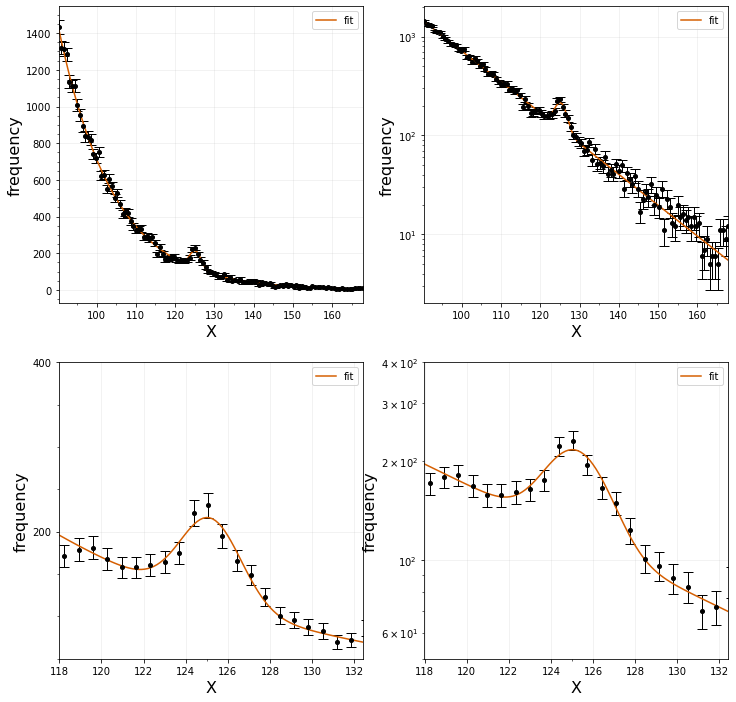

In [87]:
# Plot result, as in exercise 1, but double up with logarithmic y axis example.

fig, axs = plt.subplots(2,2,figsize = (12,12))

# X Values to use when showing fitted curve
x_min = min(data_x)
x_max = max(data_x)

fit_x_values1 = np.linspace(x_min,x_max,100)
fit_x_values2 = np.linspace(mu_value-5*sigma_value,mu_value+5*sigma_value,100)
fit_x_values_list = [fit_x_values1,fit_x_values2]
for rrr in [0,1]:
    # rrr=0 is the standard plot of the whole data
    # rrr=1 zooms in on the interesting part around X=125 anticpating the next question
    for fff in [0,1]:
        # fff=0 is on normal axes, fff=1 is on semilog axes
        if fff==1:
            axs[rrr,fff].set_yscale('log')
        axs[rrr,fff].errorbar(data_x, data_y, yerr = data_yerr,
                    color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
        
        if rrr==0: # standard plot
            fit_x_values = np.linspace(x_min,x_max,100)
            axs[rrr,fff].set_xlim(x_min,x_max)
        else: # limit to region around signal
            fit_x_values = np.linspace(mu_value-5*sigma_value,mu_value+5*sigma_value,100)
            axs[rrr,fff].set_xlim(min(fit_x_values),max(fit_x_values))
            axs[rrr,fff].set_ylim(50,400)

        # for each fit, plot a line
        #fit_param_values = [ v for v in signal_lsq_eg_mobj.values]
        fit_y_values = exp_plus_gauss(fit_x_values, *signal_lsq_eg_mobj.values )
        axs[rrr,fff].plot( fit_x_values, fit_y_values, color="#D55E00", label= "fit") #fit_form_eg_str")

        #est_y_values = exp_distrib(fit_x_values, *signal_lsq_eg_mobj.init_values )
        #axs[fff].plot( fit_x_values, est_y_values, color="#009E73", label= fit_form_str)

        # labels etc
        axs[rrr,fff].set_xlabel('X',fontsize = 16)
        axs[rrr,fff].set_ylabel('frequency',fontsize = 16)

        axs[rrr,fff].xaxis.set_minor_locator(MultipleLocator(20))
        axs[rrr,fff].xaxis.set_minor_locator(MultipleLocator(5))

        if fff==0:
            axs[rrr,fff].yaxis.set_major_locator(MultipleLocator(200))
            axs[rrr,fff].yaxis.set_minor_locator(MultipleLocator(50))


        #ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
        axs[rrr,fff].grid('xkcd:dark blue',alpha = 0.2)    

        axs[rrr,fff].legend(loc='best')

So looking at the zoomed in part of the plot, the fit looks pretty good. All points are within one error bar of the line (the fit).

Note: in the original version of the question, this is not what I found.  If you included the higher X values we removed from the raw data at the start of the process, we would not be doing so well. 

The question is can we do better. The next exercise will show you how we can use some iminuit tricks to improve the fit.

<div style="background-color:#C2F5DD">

### Exercise 7

Now we will use the same function
$$
f(X) = A \exp ( -(X-B)/C) ) + D \exp(-(x-\mu)^2 / \sigma^2) \, .
$$
but we will do the fit in stages. We will start by fitting the exponential background without the part of the data coming from the signal (the region $120 \leq X \leq 130$). So follow these steps:

* Fix the signal parameters `D`, `mu`, and `sigma`
* Set physical limits on background parameters `A`, `B`, and `C` (`A` and `C` should be strictly positive)
* Mask the signal region $120 \leq X \leq 130$, i.e. don't include it in the data.
* Fit the model so that we are only effectively fitting the background.
* Fix background parameters and release signal parameters.
* Set physical limits on signal parameters (`D` and `sigma` should be positive, `mu` should lie in the range of the data)
* Remove the mask, i.e. now run on all the data.
* Fit the model. 
* Finally, release all parameters and fit one final time.

Take care with your choice of initial parameters, as this can make a large difference to the result of your fit. Make sure to plot your final result.

In [88]:
# Define a new cost function, a.k.a. loss function, to start afresh but it is as before

signal_lsq_eg_obj2 = LeastSquares(data_x, data_y, data_yerr, exp_plus_gauss)

In [89]:
# Define Minuit object

# Try the previous best fit values as our initial estimate for exponential part of f(X)  
A_est = A_value
B_est = B_value
C_est = C_value
mu_est = mu_value
sigma_est = abs(sigma_value) # should not effect the fitting (EFS why?) but I prefer positive sigma values.
D_est = D_value

print(f"For exponential plus gaussian distribution f(X) = A exp(-(x-B)/C) + D exp( -(x-mu)^2/sigma^2 )")
print(f"   estimate A={A_est:g}, B={B_est:f}, C={C_est:f}, D={D_est:g}, mu={mu_est:f}, sigma={sigma_est:f}")

est_form_str = f"f(X) = {A_est:.2g} exp( -(X-{B_est:4.2f}) / {C_est:4.1f}) + {D_est:5.1f}  exp( -(x-{mu_est:5.1f} )^2/ {sigma_est:5.2f}^2 )"
print ("    so fitting "+est_form_str)

signal_lsq_eg_mobj2 = Minuit(signal_lsq_eg_obj2, A=A_est, B=B_est, C=C_est, D=D_est, mu=mu_est, sigma=sigma_est) 

print(signal_lsq_eg_mobj2.init_params) # shows initial parameter values

For exponential plus gaussian distribution f(X) = A exp(-(x-B)/C) + D exp( -(x-mu)^2/sigma^2 )
   estimate A=734615, B=3.273373, C=13.941127, D=99.09, mu=125.194783, sigma=1.444596
    so fitting f(X) = 7.3e+05 exp( -(X-3.27) / 13.9) +  99.1  exp( -(x-125.2 )^2/  1.44^2 )
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │   735e3   │    7e3    │            │            │         │         │       │
│ 1 │ B     │   3.273   │   0.033   │            │            │         │         │       │
│ 2 │ C     │   13.94   │   0.14    │            │            │         │         │       │
│ 3 │ D     │   99.1    │    1.0    │            │            │         │         │       │
│ 4 │ mu    │   125.2   │    1.2    │            │            │         │         │

In [90]:
# Fix signal parameters and set limits on background parameters

signal_lsq_eg_mobj2 .fixed['D'] = True
signal_lsq_eg_mobj2 .fixed['mu'] = True
signal_lsq_eg_mobj2 .fixed['sigma'] = True

In [91]:
# Mask the signal region as specified in question 
xsignal_min=120
xsignal_max=130

# You could try the region I used for plotting above based on the fitted parameter estimates
# xmask_min, xmask_max = mu_value-5*sigma_value, mu_value+5*sigma_value

# The mask is just an array of boolean values, true at each X value (in data_x) to be included 
x_mask_no_signal = (data_x < xsignal_min) | (data_x >xsignal_max)
signal_lsq_eg_obj2.mask= x_mask_no_signal

In [92]:
# Fit the model

signal_lsq_eg_mobj2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 123.5 (χ²/ndof = 1.3)      │              Nfcn = 46               │
│ EDM = 8.53e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │  0.74e6   │  0.06e6   │            │            │         │         │       │
│ 1 │ B     │    3.3    │    1.1    │            │            │         │         │       │
│ 2 │ C     │   13.93   │   0.08    │            │            │         │         │       │
│ 3 │ D     │   99.1    │    1.0    │            │            │         │         │  yes  │
│ 4 │ mu    │   125.2   │    1.2    │            │            │         │         │  yes  │
│ 5 │ sigma │   1.445   │   0.014   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────┐
│       │           A           B           C           D          mu       sigma │
├───────┼─────────────────────────────────────────────────────────────────────────┤
│     A │     3.5e+09  -56.6469e3 -1.304555e3           0           0           0 │
│     B │  -56.6469e3        1.25      -0.025         0.0         0.0         0.0 │
│     C │ -1.304555e3      -0.025     0.00695       0.000       0.000       0.000 │
│     D │           0         0.0       0.000           0           0           0 │
│    mu │           0         0.0       0.000           0           0           0 │
│ sigma │           0         0.0       0.000           0           0           0 │
└───────┴─────────────────────────────────────────────────────────────────────────┘

In [93]:
# check fit valid. It looks good
print("Valid fit? "+str(signal_lsq_eg_mobj.valid))

# goodness of fit will show a poor fit
print( f" chi^2/dof = {signal_lsq_eg_mobj2.fval:.2f} / {signal_lsq_eg_mobj2.ndof:.0f} = {signal_lsq_eg_mobj2.fmin.reduced_chi2:.2f}")  

# for this line see week 3 "Calculating p-values from $\chi^2$ tests"
pvalue = chi2.sf(signal_lsq_eg_mobj.fval,signal_lsq_eg_mobj.ndof)
print( f" p-value is {pvalue:5.3f}\n")

# create a label for the best fit
A_value1 = signal_lsq_eg_mobj2.params['A'].value
B_value1 = signal_lsq_eg_mobj2.params['B'].value
C_value1 = signal_lsq_eg_mobj2.params['C'].value
D_value1 = signal_lsq_eg_mobj2.params['D'].value
mu_value1 = signal_lsq_eg_mobj2.params['mu'].value
sigma_value1 = signal_lsq_eg_mobj2.params['sigma'].value
fit1_form_eg_str  = f"f1(X) = {A_value1:.2g} exp( -(X-{B_value1:4.2f}) / {C_value1:4.1f}) + {D_value1:5.1f}  exp( -(x-{mu_value1:5.1f} )^2/ {sigma_value1:5.2f}^2 )"
print ("          so 1st fitted form is\n"+fit1_form_eg_str)


Valid fit? True
 chi^2/dof = 123.50 / 97 = 1.27
 p-value is 0.097

          so 1st fitted form is
f1(X) = 7.4e+05 exp( -(X-3.32) / 13.9) +  99.1  exp( -(x-125.2 )^2/  1.44^2 )


In [94]:
# Release the signal parameters, fix background parameters, set limits on signal parameters, 
# remove the mask

# Release the signal parameters, 
signal_lsq_eg_mobj2.fixed['D'] = False
signal_lsq_eg_mobj2.fixed['mu'] = False
signal_lsq_eg_mobj2.fixed['sigma'] = False

# Fix background parameters
signal_lsq_eg_mobj2.fixed['A'] = True
signal_lsq_eg_mobj2.fixed['B'] = True
signal_lsq_eg_mobj2.fixed['C'] = True

# set limits on signal parameters
signal_lsq_eg_mobj2.limits['D'] = (0,None) # set limit on D to be minimum of 0, no maximum
signal_lsq_eg_mobj2.limits['mu'] = (xsignal_min,xsignal_max) # set mu to lie in signal region
signal_lsq_eg_mobj2.limits['sigma'] = (0,None) # set limit on sigma to be minimum of 0, no maximum

# remove the mask of the signal region
#signal_lsq_eg_obj2.mask = None 

# Just fit to signal region
x_mask_only_signal = (data_x >= xsignal_min) & (data_x <= xsignal_max)
signal_lsq_eg_obj2.mask= x_mask_only_signal


# To be honest, not sure this should have much effect. 
# Perhaps if mask was bigger (5 sigma) we would not need to remove mask.
# The exponential fall off of the Gaussian means the contribution to the signal
# in a region a couple of sigmas away from the mean is neglibible, De^{-2} = . 
# Maybe try without this?
ysignal_2sigma_est = D_value1 * np.exp(-(xsignal_min-mu_value1)**2 / (2*sigma_value1**2))
ybackground_xmin = A_value1 * np.exp(-(xsignal_min-B_value1)/C_value1)
print(f"Estimated background vs signal contribution at edge of mask above signal: {ybackground_xmin:5.1f} vs. {ysignal_2sigma_est:5.1f}" )


Estimated background vs signal contribution at edge of mask above signal: 169.5 vs.   0.2


In [95]:
# Fit the model

signal_lsq_eg_mobj2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.065 (χ²/ndof = 0.4)      │              Nfcn = 79               │
│ EDM = 0.000103 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │  0.74e6   │  0.06e6   │            │            │         │         │  yes  │
│ 1 │ B     │    3.3    │    1.1    │            │            │         │         │  yes  │
│ 2 │ C     │   13.93   │   0.08    │            │            │         │         │  yes  │
│ 3 │ D     │    99     │     9     │            │            │    0    │         │       │
│ 4 │ mu    │  125.19   │   0.14    │            │            │   120   │   130   │       │
│ 5 │ sigma │   1.45    │   0.15    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────┐
│       │      A      B      C      D     mu  sigma │
├───────┼───────────────────────────────────────────┤
│     A │      0      0      0      0  0.000  0.000 │
│     B │      0      0      0      0  0.000  0.000 │
│     C │      0      0      0      0  0.000  0.000 │
│     D │      0      0      0   87.5 -0.111 -0.869 │
│    mu │  0.000  0.000  0.000 -0.111 0.0188  0.001 │
│ sigma │  0.000  0.000  0.000 -0.869  0.001 0.0213 │
└───────┴───────────────────────────────────────────┘

In [96]:
# check fit valid but it looks good away from signal
print("Valid fit? "+str(signal_lsq_eg_mobj.valid))

# goodness of fit is better here but still not very good
print( f" chi^2/dof = {signal_lsq_eg_mobj2.fval:.2f} / {signal_lsq_eg_mobj2.ndof:.0f} = {signal_lsq_eg_mobj2.fmin.reduced_chi2:.2f}")  

# for this line see week 3 "Calculating p-values from $\chi^2$ tests"
pvalue = chi2.sf(signal_lsq_eg_mobj.fval,signal_lsq_eg_mobj.ndof)
print( f" p-value is {pvalue:5.3f}\n")

# create a label for the best fit
A_value2 = signal_lsq_eg_mobj2.params['A'].value
B_value2 = signal_lsq_eg_mobj2.params['B'].value
C_value2 = signal_lsq_eg_mobj2.params['C'].value
D_value2 = signal_lsq_eg_mobj2.params['D'].value
mu_value2 = signal_lsq_eg_mobj2.params['mu'].value
sigma_value2 = signal_lsq_eg_mobj2.params['sigma'].value
fit2_form_eg_str  = f"f2(X) = {A_value2:.2g} exp( -(X-{B_value2:4.2f}) / {C_value2:4.1f}) + {D_value2:5.1f}  exp( -(x-{mu_value2:5.1f} )^2/ {sigma_value2:5.2f}^2 )"
print ("          so 2nd fitted form is\n"+fit2_form_eg_str)

Valid fit? True
 chi^2/dof = 5.07 / 12 = 0.42
 p-value is 0.097

          so 2nd fitted form is
f2(X) = 7.4e+05 exp( -(X-3.32) / 13.9) +  99.3  exp( -(x-125.2 )^2/  1.45^2 )


In [97]:
# Release all parameters, refit the whole model & calculate error using hesse

# Fix background parameters
signal_lsq_eg_mobj2.fixed['A'] = False
signal_lsq_eg_mobj2.fixed['B'] = False
signal_lsq_eg_mobj2.fixed['C'] = False

# remove the mask, fit all data 
signal_lsq_eg_obj2.mask = None 

# Fit the model
signal_lsq_eg_mobj2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 128.5 (χ²/ndof = 1.2)      │              Nfcn = 214              │
│ EDM = 1.87e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │  0.73e6   │  0.06e6   │            │            │         │         │       │
│ 1 │ B     │    3.3    │    1.1    │            │            │         │         │       │
│ 2 │ C     │   13.94   │   0.08    │            │            │         │         │       │
│ 3 │ D     │    99     │     9     │            │            │    0    │         │       │
│ 4 │ mu    │  125.19   │   0.14    │            │            │   120   │   130   │       │
│ 5 │ sigma │   1.44    │   0.15    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────┐
│       │           A           B           C           D          mu       sigma │
├───────┼─────────────────────────────────────────────────────────────────────────┤
│     A │    3.17e+09  -51.2771e3 -1.229626e3      6.34e3      26.464     412.115 │
│     B │  -51.2771e3        1.14      -0.024         0.1       0.001       0.008 │
│     C │ -1.229626e3      -0.024     0.00659      -0.037      -0.000      -0.002 │
│     D │      6.34e3         0.1      -0.037        87.5      -0.111      -0.844 │
│    mu │      26.464       0.001      -0.000      -0.111      0.0187       0.001 │
│ sigma │     412.115       0.008      -0.002      -0.844       0.001      0.0224 │
└───────┴─────────────────────────────────────────────────────────────────────────┘

In [98]:
# check fit valid but it looks good
print("Valid fit? "+str(signal_lsq_eg_mobj.valid))

# goodness of fit bad again, see discussion below
#print( f" chi^2/dof = {signal_lsq_eg_mobj2.fval:.2f} / {signal_lsq_eg_mobj2.ndof:.0f} = {signal_lsq_eg_mobj2.fmin.reduced_chi2:.2f}")  

# for this line see week 3 "Calculating p-values from $\chi^2$ tests"
#pvalue = chi2.sf(signal_lsq_eg_mobj.fval,signal_lsq_eg_mobj.ndof)
#print( f" p-value is {pvalue:5.3f}\n")

# create a label for the best fit
A_value3 = signal_lsq_eg_mobj2.params['A'].value
B_value3 = signal_lsq_eg_mobj2.params['B'].value
C_value3 = signal_lsq_eg_mobj2.params['C'].value
D_value3 = signal_lsq_eg_mobj2.params['D'].value
mu_value3 = signal_lsq_eg_mobj2.params['mu'].value
sigma_value3 = signal_lsq_eg_mobj2.params['sigma'].value
fit3_form_eg_str  = f"f3(X) = {A_value3:.2g} exp( -(X-{B_value3:4.2f}) / {C_value3:4.1f}) + {D_value3:5.1f}  exp( -(x-{mu_value3:5.1f} )^2/ {sigma_value3:5.2f}^2 )"
print ("          so 3rd fitted form is\n"+fit3_form_eg_str)

Valid fit? True
          so 3rd fitted form is
f3(X) = 7.3e+05 exp( -(X-3.28) / 13.9) +  99.1  exp( -(x-125.2 )^2/  1.44^2 )


In [99]:
# Calculate errors in parameters using hesse

hhh = signal_lsq_eg_mobj2.hesse() # calculate parameter uncertainties

for param in signal_lsq_eg_mobj2.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))



A = 734725.27 +/- 56343.92
B = 3.28 +/- 1.07
C = 13.94 +/- 0.08
D = 99.09 +/- 9.35
mu = 125.19 +/- 0.14
sigma = 1.44 +/- 0.15


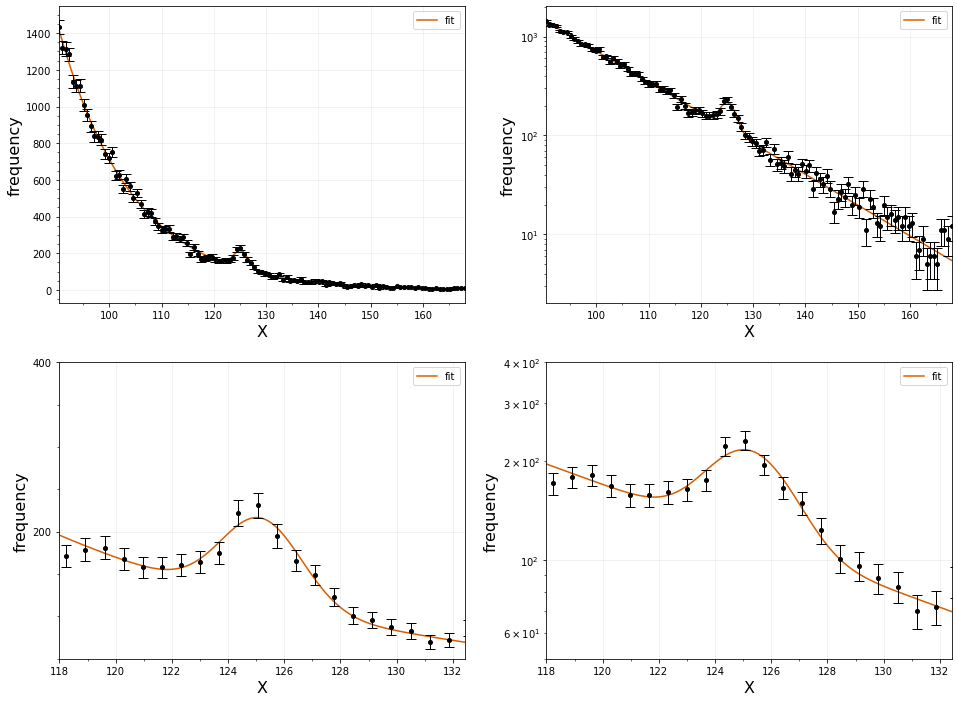

In [100]:
# Plot result. This comes from exercise 6

fig, axs = plt.subplots(2,2,figsize = (16,12))

# X Values to use when showing fitted curve
x_min = min(data_x)
x_max = max(data_x)

#fit_x_values1 = np.linspace(x_min,x_max,100)
#fit_x_values2 = np.linspace( mu_value3-5*sigma_value3, mu_value3+5*sigma_value3, 100)
#fit_x_values_list = [fit_x_values1,fit_x_values2]
for rrr in [0,1]:
    # rrr=0 is the standard plot of the whole data
    # rrr=1 zooms in on the interesting part around X=125 anticpating the next question
    for fff in [0,1]:
        # fff=0 is on normal axes, fff=1 is on semilog axes
        if fff==1:
            axs[rrr,fff].set_yscale('log')
        
        if rrr==1: # limit to region around signal
            fit_x_values = np.linspace( mu_value3-5*sigma_value3, mu_value3+5*sigma_value3, 100)
            axs[rrr,fff].set_ylim(50,400)
            axs[rrr,fff].xaxis.set_minor_locator(MultipleLocator(5))
            axs[rrr,fff].xaxis.set_minor_locator(MultipleLocator(1))
        else: # standard plot
            fit_x_values = np.linspace(x_min,x_max,100)
            axs[rrr,fff].xaxis.set_minor_locator(MultipleLocator(20))
            axs[rrr,fff].xaxis.set_minor_locator(MultipleLocator(5))
        
        axs[rrr,fff].set_xlim(min(fit_x_values),max(fit_x_values))

        # for each fit, plot a line
        #fit_param_values = [ v for v in signal_lsq_eg_mobj.values]
        fit_y_values = exp_plus_gauss(fit_x_values, *signal_lsq_eg_mobj.values ) 
        axs[rrr,fff].plot( fit_x_values, fit_y_values, color="#D55E00", label= "fit") #fit_form_eg_str")
        axs[rrr,fff].errorbar(data_x, data_y, yerr = data_yerr,
                color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
        axs[rrr,fff].set_ylabel('frequency',fontsize = 16)
        axs[rrr,fff].legend(loc='best')
        if fff==0:
            axs[rrr,fff].yaxis.set_major_locator(MultipleLocator(200))
            axs[rrr,fff].yaxis.set_minor_locator(MultipleLocator(50))

        # labels etc
        axs[rrr,fff].set_xlabel('X',fontsize = 16)
        axs[rrr,fff].grid('xkcd:dark blue',alpha = 0.2)    






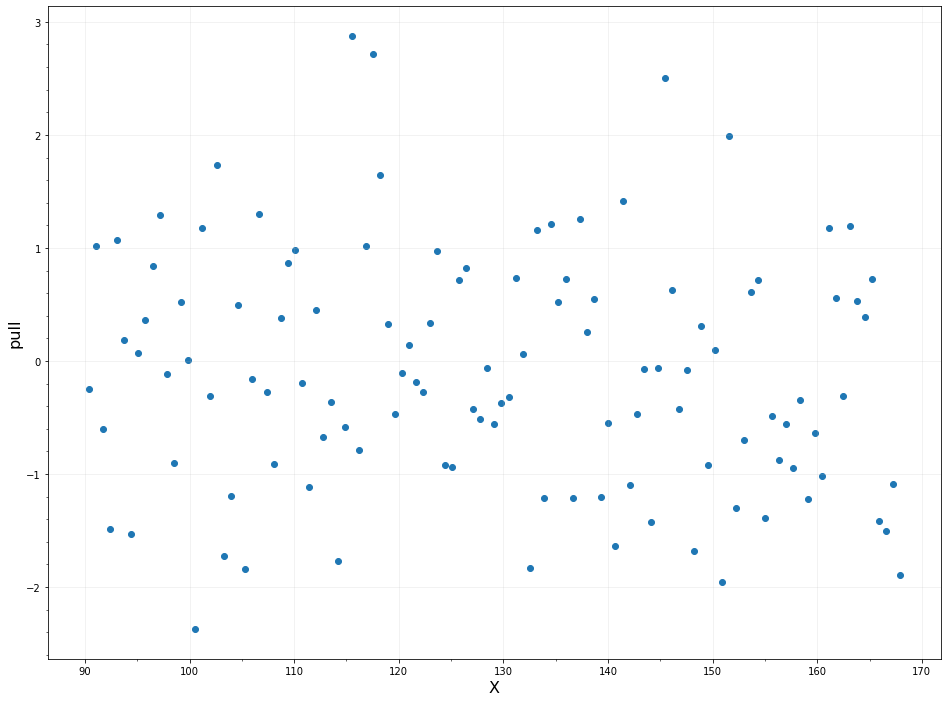

In [101]:
# OPTIONAL. I just thought I'd check the pull values, I want 95% two lie between -2 and 2.
fig, ax = plt.subplots(1,1,figsize = (16,12))
pull_y_values = (exp_plus_gauss(data_x, *signal_lsq_eg_mobj.values ) -  data_y) / data_yerr
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.scatter(data_x, pull_y_values)
ax.set_ylabel('pull',fontsize = 16)
# labels etc
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlabel('X',fontsize = 16)
ax.grid('xkcd:dark blue',alpha = 0.2)    

<div style="background-color:#C2F5DD">

Does the masking approach improve the quality of your fit? What is the value of $\mu$ for your Gaussian signal? Answer in the Markdown cell below.

In [102]:
# Goodness of fit
display(signal_lsq_eg_mobj2.fmin)

# Now look at measures of goodness of fit
print( f" chi^2/dof = {signal_lsq_eg_mobj2.fval:.2f} / {signal_lsq_eg_mobj2.ndof:.0f} = {signal_lsq_eg_mobj2.fmin.reduced_chi2:.2f}")  

# for this line see week 3 "Calculating p-values from $\chi^2$ tests"
pvalue = chi2.sf(signal_lsq_eg_mobj2.fval,signal_lsq_eg_mobj2.ndof)
print( f" p-value is {pvalue:5.3f}\n")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 128.5 (χ²/ndof = 1.2)      │              Nfcn = 254              │
│ EDM = 1.87e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘

 chi^2/dof = 128.54 / 109 = 1.18
 p-value is 0.097



So in the end all this messing around with masks etc, has not improved the situation from exercise 6. Visually and then backed up by the chi square statistic values, the fit is good but no better that before. 

The story here is that on some attempts to solve this question, the tricks in exercise 7 did make a difference.  There is a a lot of semi-quantitaive magic here. Things like choices of initial values for parameters or the noise on the data (here what X values did we exclude) has odd effects on the results. We are, after all, searching in a six-dimensional space to find the best fit and there are no guarantees in such searches. 

<div style="background-color:#C2F5DD">

### Exercise 8
    
#### Exercise 8a 

Now repeat fitting the background and signal simultaneously, but this time using a binned negative log likelihood fit. We will use a linear combination of an exponential pdf $f_\mathrm{exp}(x;B,C)$  and a Gaussian pdf $f_\mathrm{g}(x;\mu,\sigma)$ as we did with least squares. That is our pdf will be $f_\mathrm{BNLL} (x;\mu, \sigma, B, C, z)$ where

$$
\begin{align*}
 f_\mathrm{BNLL} (x;\mu, \sigma, B, C, z)   
 & = z . f_\mathrm{exp}(x;B,C) + (1-z) . f_\mathrm{g}(x;\mu,\sigma) \\
 & = z . C \exp ( (x-B)/ C ) + z . \frac{1}{\sqrt{2 \pi} \sigma}   \exp( (x-\mu)^2 / \sigma ^2) 
 \, .
\end{align*}
$$

The first code cell below defines a CDF you can use for this purpose using built in functions. 
    
There are various issues mathematically with $f_\mathrm{BNLL} (x;\mu, \sigma, B, C, z)$ and with the normalisation which is why we have replaced $A$ and $D$ parameters used in the least square exercises by a single variable $z$ here. Some optional comments on this follow but this form will work.
    
To solve the problem using binned negative log likelihood fit, use the same data as you did above. Remember to set physical limits on your parameters, including:

* `mu` within the range of the data.
* `sigma` and `C` as strictly $\gt 0$.
* $0 \leq$ `z` $\leq 1$

Remember to use the `BinnedNLL` cost function.




<div style="background-color:#C2F5DD">

#### Exercise 8b

Once you have the best fit using log likelihood, comment on how good the solution is.
    
Also, compare the log likelihood solution to the least squares solution.  For instance, you can use the same `hesse` method and the same built in functions to get the errors on bets fit values for parameters and the $\chi$ square values. So you should be able to copy code used in the least squares case.

<div style="background-color: #FFF8C6">

#### Optional notes on Exercise 8: Normalisation and Log Likelihood.
    
Normalisation is an issue here. The exponential distribution is normalised for $0 \leq x \leq \infty$ while Gaussians are defined for any real $x$. In any case, we are only really interested in the limited range used in our data and then the standard functions we use from the libraries are definitely not normalised for these limited ranges.  
    
If we have normalised pdf $f_1(x)$ and $f_2(x)$ defined for the same range of $x$ values, then $z.f_1(x)+(1-z).f_2(x)$ is also a valid pdf in the same range of $x$ if $0 \leq z \leq 1$. However here each individual function is not normalised over the range of our data so adding them together with a $z$ and (=$(1-z)$ prefactors where $z$ lies between $0$ and $1$ makes no sense. 

We could normalise the functions, numerically in the Gaussian, but then these factors would also depend on the parameters making definition of the functions much more involved. 

In fact for log likelihood, the overall freedom to change the normalisation of a function is an irrelevant factor and you should never include this. Suppose $f(x; \theta)$ is a normalised pdf but we choose to work with the log likelihood of $g(x; \lambda, \theta) = \lambda f(x; \theta)$ where $\lambda$ is an extra parameters. We can see that the negative log likelihood working with $f$ and with $g$ only differ by a factor of $N\ln(\lambda)$ for $N$ data points. This is minimised by taking $\lambda$ to zero which is clearly silly. Even if we limit $\lambda$ to be greater than some positive number $c$ we will always chose $\lambda=c$ as this is the smallest value for this extra factor. So we should never allow the overall normalisation of our pdf to change in log likelihood analysis though it need not be equal to $1$. As long as $\lambda$ is fixed, minimising with $f$ or $g$ will give the same result for parameters as the log likelihoods differ by a constant $N\ln(\lambda)$. So the overall normalisation is irrelevant as long as it is fixed. So we don't care if the normalisation is messed up as long as we factor this out and work with $z$ and $(1-z)$ pre-factors with $0 \leq z \leq 1$ rather than the independent $A$ and $D$ normalisations used in least squares.

In [103]:
# Define the cdf we need
from scipy.stats import norm, expon

"""
 expon is an exponentially distributed random variable
 https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html
  expon(x; loc, scale) = scale * exp ( (x-loc)/ scale )
 for x>loc and it is normalised, $\int_B^\infty dx C \expexp ( (x-B)/ C ) =1$
 which you can see by changing variable to $y = (x-B)/ C$.

 norm is the normal distribution with loc = mu and scale = sigma
  norm(x; loc, scale) = [2 pi scale^2]^{-1/2}   exp[ ( (x-loc) / scale )^2]
 but note this is normalised for any real x.
 
 So compared to last time where
  f(X) = A \exp ( -(X-B)/C) ) + D \exp(-(x-\mu)^2 / \sigma^2) \, .
 all parameters are equivalent except for A,D vs z. 
 These are related to the normalisation but over the range of data we have
 the standard functions we use are not normalised 
 so normalisation is a bit screwed up here.

"""

def expgaussian_cdf(x, mu, sigma, B, C, z):
    return z*norm.cdf(x, mu, sigma) + (1-z)*expon.cdf(x, B, C)

In [104]:
# First get the data we will use. 
# Perhaps simply reuse the parameters and data used for least squares.

#n_bins=200
print("\n*** FINAL choice for number of bins is "+str(n_bins))
#min_bin_count = 5
print("*** Limit X to be below lowest X value of any bin containing counts less than  "+str(min_bin_count))

counts_all, bin_edges_all = np.histogram(signal_data, bins = n_bins)

bin_centre_all = 0.5*(bin_edges_all[1:]+bin_edges_all[:-1]) # x value is centre of each bin

# Cutoff bins at high X with low numbers of counts, work in terms of centre of bin
bin_centre_small_bincount = bin_centre_all[data_y_all<min_bin_count]
bin_centre_small_bincount_min = min(bin_centre_small_bincount) 
print("    We will drop {:d} bins starting from X={:5.1f} from our analysis".format(len(x_small_bincount),x_small_bincount_min))

# Now limit to data to final range of  X < x_small_bincount_min so data_y[i] >= min_bin_count = 5 
bin_centre = bin_centre_all[ bin_centre_all < bin_centre_small_bincount_min ] 
last_edge_index = len(bin_centre)+1 
bin_edges = bin_edges_all[:last_edge_index]
counts = data_y_all[ data_x_all < x_small_bincount_min ] 





*** FINAL choice for number of bins is 200
*** Limit X to be below lowest X value of any bin containing counts less than  5
    We will drop 81 bins starting from X=168.6 from our analysis


In [105]:
# Define your cost function
from iminuit.cost import BinnedNLL

signal_bnll_eg_cost = BinnedNLL(counts, bin_edges, expgaussian_cdf)



In [106]:
# Define your Minuit object & set limits on parameters

# We could use the best fit values from the LeastSquares exercise above.
# However, for a fair comparison let us use the same starting values as we did initially
# for least squares back in exercise 6. That is we use values from the best least squares 
# fit to the pure exponential as our initial estimate for exponential part of f(X)  
# and we set by eye the gaussian parameters as we did in exercise.
# The exception are the normalisation parameters.
z_est = D_est/(A_est+D_est)
signal_bnll_eg_mobj = Minuit(signal_bnll_eg_cost, mu = mu_est, sigma = sigma_est, B = B_est, C = C_est, z = z_est, )
print(signal_bnll_eg_mobj.init_params) # shows initial parameter values



┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   125.2   │    1.2    │            │            │         │         │       │
│ 1 │ sigma │   1.445   │   0.014   │            │            │         │         │       │
│ 2 │ B     │   3.273   │   0.033   │            │            │         │         │       │
│ 3 │ C     │   13.94   │   0.14    │            │            │         │         │       │
│ 4 │ z     │ 134.9e-6  │  1.4e-6   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [107]:
# Fit your function

signal_bnll_eg_mobj.limits['z'] = (0,1)
signal_bnll_eg_mobj.limits['mu'] = (xsignal_min,xsignal_max) # use same limits as before
signal_bnll_eg_mobj.limits['sigma'] = (0, None)

signal_bnll_eg_mobj.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 345.6 (χ²/ndof = 3.1)      │              Nfcn = 347              │
│ EDM = 0.000115 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  125.19   │   0.14    │            │            │   120   │   130   │       │
│ 1 │ sigma │   1.51    │   0.15    │            │            │    0    │         │       │
│ 2 │ B     │  90.006   │   0.018   │            │            │         │         │       │
│ 3 │ C     │   13.73   │   0.09    │            │            │         │         │       │
│ 4 │ z     │  0.0186   │  0.0016   │            │            │    0    │    1    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │       mu    sigma        B        C        z │
├───────┼──────────────────────────────────────────────┤
│    mu │   0.0192   -0.000  0.01e-3   -0.000 -11.2e-6 │
│ sigma │   -0.000   0.0238  0.05e-3   -0.003 136.2e-6 │
│     B │  0.01e-3  0.05e-3 0.000334 -0.34e-3   0.8e-6 │
│     C │   -0.000   -0.003 -0.34e-3  0.00759 -43.5e-6 │
│     z │ -11.2e-6 136.2e-6   0.8e-6 -43.5e-6 2.56e-06 │
└───────┴──────────────────────────────────────────────┘

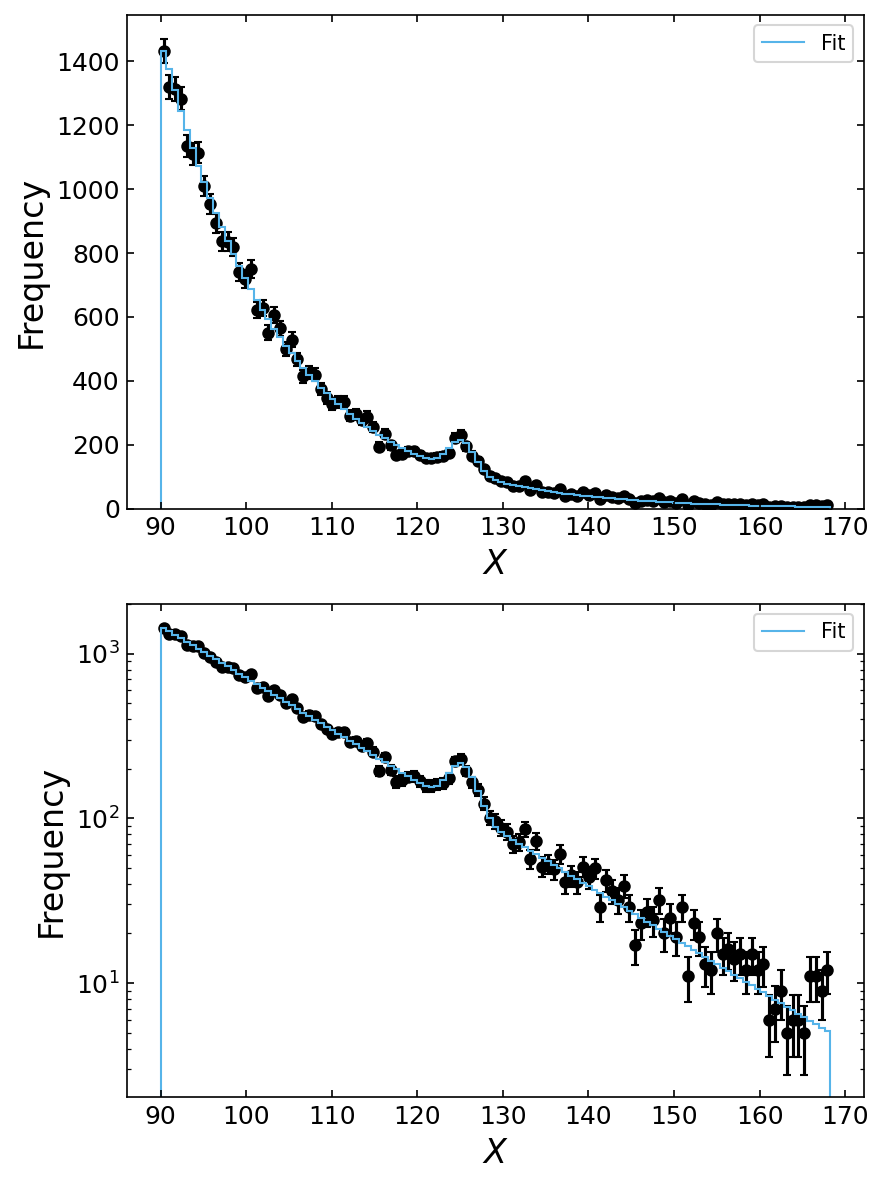

In [108]:
# Plot your results
total_count = sum(counts) # need to fix normalisation

fig, axs = plt.subplots(2,1,figsize = (6,8),dpi = 150)
for fff in [0,1]:
    if fff==1:
        axs[fff].set_yscale('log')
    else:
        ax.yaxis.set_major_locator(MultipleLocator(200))
        ax.yaxis.set_minor_locator(MultipleLocator(50))
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(MultipleLocator(5))

    axs[fff].errorbar(bin_centre, counts, counts**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
    axs[fff].stairs(np.diff(expgaussian_cdf(bin_edges, *signal_bnll_eg_mobj.values))*total_count, bin_edges, 
              label='Fit',zorder = 1,color='#56B4E9')

    axs[fff].set_xlabel('$X$',fontsize = 16)
    axs[fff].set_ylabel('Frequency',fontsize = 16)
    axs[fff].legend(loc='upper right')
    axs[fff].tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

fig.tight_layout()

In [109]:
# create a label for the best fit
print (" Least Squares best form was\n"+fit3_form_eg_str)

# create a label for the best fit
B_value_bnll = signal_bnll_eg_mobj.params['B'].value
C_value_bnll = signal_bnll_eg_mobj.params['C'].value
mu_value_bnll = signal_bnll_eg_mobj.params['mu'].value
sigma_value_bnll = signal_bnll_eg_mobj.params['sigma'].value
z_value_bnll = signal_bnll_eg_mobj.params['z'].value

fit_form_bnll_eg_str  = f"fBNLL(X) = {(1-z_value_bnll):.2g} exp( -(X-{B_value_bnll:4.2f}) / {C_value_bnll:4.1f}) + {z_value_bnll:.2g}  exp( -(x-{mu_value_bnll:5.1f} )^2/ {sigma_value_bnll:5.2f}^2 )"
print ("BNLL fitted form is\n"+fit_form_bnll_eg_str)

# Calculate error using hesse
hhh = signal_bnll_eg_mobj.hesse() # calculate parameter uncertainties

for param in signal_bnll_eg_mobj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))


 Least Squares best form was
f3(X) = 7.3e+05 exp( -(X-3.28) / 13.9) +  99.1  exp( -(x-125.2 )^2/  1.44^2 )
BNLL fitted form is
fBNLL(X) = 0.98 exp( -(X-90.01) / 13.7) + 0.019  exp( -(x-125.2 )^2/  1.51^2 )
mu = 125.19 +/- 0.14
sigma = 1.51 +/- 0.15
B = 90.01 +/- 0.02
C = 13.73 +/- 0.09
z = 0.02 +/- 0.00


In [110]:
# Goodness of fit
display(signal_bnll_eg_mobj.fmin)

# Now look at measures of goodness of fit
print( f" chi^2/dof = {signal_bnll_eg_mobj.fval:.2f} / {signal_bnll_eg_mobj.ndof:.0f} = {signal_bnll_eg_mobj.fmin.reduced_chi2:.2f}")  

# for this line see week 3 "Calculating p-values from $\chi^2$ tests"
pvalue = chi2.sf(signal_bnll_eg_mobj.fval,signal_bnll_eg_mobj.ndof)
print( f" p-value is {pvalue:5.3f}\n")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 345.6 (χ²/ndof = 3.1)      │              Nfcn = 378              │
│ EDM = 0.000115 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

 chi^2/dof = 345.58 / 110 = 3.14
 p-value is 0.000



#### Comparison of Least Squares and BNLL solutions

The fit for the Higgs mass is almost the same and well within the erors on the estimates. The width of the gaussian looks more different but still compatible within errors. The problem is in the parameters for the exponential background and this is where the least squares and log likelihood methods differ. In my BNLL plots, I can see that at high X (energy) in the log plot there is some visual evidence of a systematic poor fit. If we look at the chi square goodness of fit measure, the BNLL result looks to be bad. My guess is the poor chi square statistic comes from this high X region.

However we have to remember that the Least Square method is designed to optimise the chi square measure, BNLL is not. So we should not be surprised that BNLL has a worse chi square as Least Square will deliver the best chi square result possible.

The issue here is that chi square is just one number, one statistic that represents the goodness of fit. Likelihood is another measure. If we took the time I am sure the Least Square best solution will have a worse Likeliood than the BNLL solution. I expect that Least Square is more  sensitive to the low count high energy that BNLL.

Which solution is correct? Both are, by different measures. Depending what measure, what you optimise, you will get different results. The key is if for any rasonable statistics you get consistent results.  As the focus is on the signal, we can see the same basic results for the Higgs are found in the signal regardless of which approach we take. 

FINISHED!
<!-- NO TOO BORING, DONE ENOUGH.

<div style="background-color:#C2F5DD">

### Exercise 9

Finally, repeat the unbinned maximum-likelihood fit with the same masking procedure we used for the `LeastSquares` cost function, but this time using the CDF we have defined and the `BinnedNLL` cost function. Remember the key steps:

* Fix the signal parameters `mu`, and `sigma`
* Set physical limits on background parameters `C`, and `D` 
* Mask the relevant region
* Fit the model
* Fix background parameters and release signal parameters
* Set physical limits on signal parameters 
* Remove the mask
* Fit the model 
* Finally, release all parameters and fit one final time


How does the result from this compare with the unmasked approach? How does it compare with the `LeastSquares` results? What about the uncertainty on the fitted parameters? Write your answers in the Markdown cell after the code cells.

-->


<hr style="border:2px solid gray">
<a id='appendix'></a>

<div style="background-color:#efdff2">
    
# Appendices [^](#appendix)


<div style="background-color:#efdff2">
    
## Appendix: Bug or feature when using functions with multiple parameters in `migrad`   
    
The `line_np` routine used above to fit polynomials of any given degree works as long as you don't visualise the result in iminuit which the `migrad` method does in Jupyter notebooks. Given our first example comes from the iminuit DOCS it seems like a bug. The solution used above was to assign a variable to the Minuit object when using migrad.
    
Alternatively this version 2 below does work with the visualisation in iminuit.
Here we use `*par` in our definition to pack all parameters passed (when we use the Minuit object) into a single tuple, to pass to `np.polyval`. This prevents a bug with Minuit's built-in visualisation. However, note you now call this routine with an explicit list of parameter values
`line_np_version2(x, p0, p1, p2, p3)` as opposed to `line_np(x, [p0,p1,p2] )` as we did originally.

In [111]:
def line_np_version2(x, *par):
    return np.polyval(par, x)  # for len(par) == 2, this is a line

<div style="background-color:#efdff2">

## Appendix: Approximating the predicted count in a bin

Here won't write the dependence on parameters ($\theta$) explicity. We then note that for the CDF $F(X)$ we have that
$$ 
F(X+\Delta X) \approx F(X) + \Delta X \, \frac{\partial F}{\partial X} = F(X; \theta) + \Delta X \, f(X) \, . 
$$
Note we use an identity that the derivative of the CDF $F(X)$ is the PDF $f(X)$ which you prove from the definition of the CDF in terms of the intergal of the PDF (EFS: prove it).

Let $p_b$ be the predicted probability that one event will be in bin $b$. Then this is given by
$$
\begin{align*}
p_b 
& =  F(X_{b}) - F(X_{b-1}) \\
\end{align*}
$$
Suppose we let $\bar{X}_b = (X_{b} + X_{b-1})/2$, i.e. the location of the centre $X$ value of the bin. Then
$$
\begin{align*}
p_b 
& \approx    \left( F(\bar{X}_{b}) + (X_b-\bar{X}_b) \, f(\bar{X}_{b}) \right) 
\quad - \quad 
             \left( F(\bar{X}_{b}) + (X_{b-1} -\bar{X}_b) \, f(\bar{X}_{b}) \right) \\ 
\Rightarrow \quad
p_b & \approx (X_b - X_{b-1}) \, f(\bar{X}_{b}) \, .
\end{align*}
$$

<div style="background-color:#efdff2">

## Appendix: Extended unbinned and binned maximum-likelihood fits

Sometimes, rather than just finding the shape parameters of some underlying probability distributions, we want to also find the integral of the probability distribution. This is particularly common in particle physics where we are trying to estimate physical observables, like the cross section of an interaction. 

For the unbinned case, the model has to return not only the probability density (as before) but also the integral of the density, which corresponds to the total number of counts. For the model we have used so far, this is equivalent to replacing the $z$ term before the normal distrubution with $n_{\text{sig}}$, the number of signal events, and the $(1-z)$ term before the uniform distribution with $n_{\text{bkg}}$, the number of background events.

For the binned case, we still only need to return the CDF, but we still must make the parameter update as before. In both cases, we are fitting one extra parameter. 

We can run these fits using the cost functions `ExtendedUnbinnedNLL` and `ExtendedBinnedNLL` from `iminuit.cost`. 

<div style="background-color:#efdff2">

### Temporary masking for fitting

When we have a complex data set with one or multiple peak(s) and a background, it can be useful to fit in several stages. It is common to start by masking the signal region, so we can fit only the background region. This means we can hide some region of our data, e.g. around where we expect our signal, so we can just fit the background. After we have successfully fit the background, we can then keep the background parameters fixed and fit the signal parameters of the whole distribution.

This is easy to do in iminuit, using the mask attribute of cost functions.

We can demonstrate this for a binned fit below, where now instead of fitting the fraction of signal and background 𝑧
we fit for the total number of signal and background events, 𝑛sig and 𝑛bkg respectively. This kind of fit can be referred to as an extended binned maximum-likelihood fit, and is useful when we care about the total number of events as well as the shape of the probability distributions. Extended maximum-likelihood fits are non-examinable and will not be discussed further, but are useful as an example for masking. 

In [112]:
# This reproduces the data used in the Maximum Likelihood section.
from scipy.stats import norm, uniform
from matplotlib.colors import to_rgba
from matplotlib.ticker import MultipleLocator

xrange = -1, 1
rng = np.random.default_rng(1)

mu_value = 0.0
sigma_value = 0.1
n_normal = 400
n_uniform = 1000
z_value =  n_normal/(n_normal+n_uniform)
print("Data generated using mu={:.3f}, sigma={:.3f},  z={:.3f} ".format(mu_value,sigma_value,z_value))
# EFS: we don't stop the Gaussian from ranging outside -2 to 2 range. Does it matter?
x_data = rng.normal( mu_value, sigma_value, size = n_normal) 
x_data = np.append(x_data, rng.uniform(*xrange, size = n_uniform))

n, xe = np.histogram(x_data, bins = 50, range = xrange)
x_bin_centre = 0.5*(xe[1:]+xe[:-1])
dx = np.diff(xe)

Data generated using mu=0.000, sigma=0.100,  z=0.286 


In [113]:
from iminuit.cost import ExtendedBinnedNLL

def model_density_cdf(x, nsig, nbkg, mu, sigma):
    return (nsig*norm.cdf(x, mu, sigma) + nbkg*uniform.cdf(x, xrange[0], xrange[1]-xrange[0]))

c = ExtendedBinnedNLL(n, xe, model_density_cdf)

m = Minuit(c, nsig = 300, nbkg = 1500, mu = 0, sigma = 0.2)

m.limits['mu'] = (-1,1)
m.limits['nsig','nbkg','sigma'] = (0, None)
m.fixed['mu','sigma','nsig'] = True # Fix mu, sigma, and the total number of signal events

c.mask = (x_bin_centre < -0.5) | (0.5 < x_bin_centre) # Mask the signal between -0.5 and 0.5, note OR symbol used

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.28 (χ²/ndof = 0.8)      │              Nfcn = 20               │
│ EDM = 2.39e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    300    │     3     │            │            │    0    │         │  yes  │
│ 1 │ nbkg  │  1.00e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ mu    │    0.0    │    0.1    │            │            │   -1    │    1    │  yes  │
│ 3 │ sigma │   0.200   │   0.002   │            │            │    0    │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────┐
│       │    nsig    nbkg      mu   sigma │
├───────┼─────────────────────────────────┤
│  nsig │       0       0       0       0 │
│  nbkg │       0 2.1e+03       0       0 │
│    mu │       0       0       0       0 │
│ sigma │       0       0       0       0 │
└───────┴─────────────────────────────────┘

<div style="background-color:#efdff2">

We can now plot the background result we have fitted:

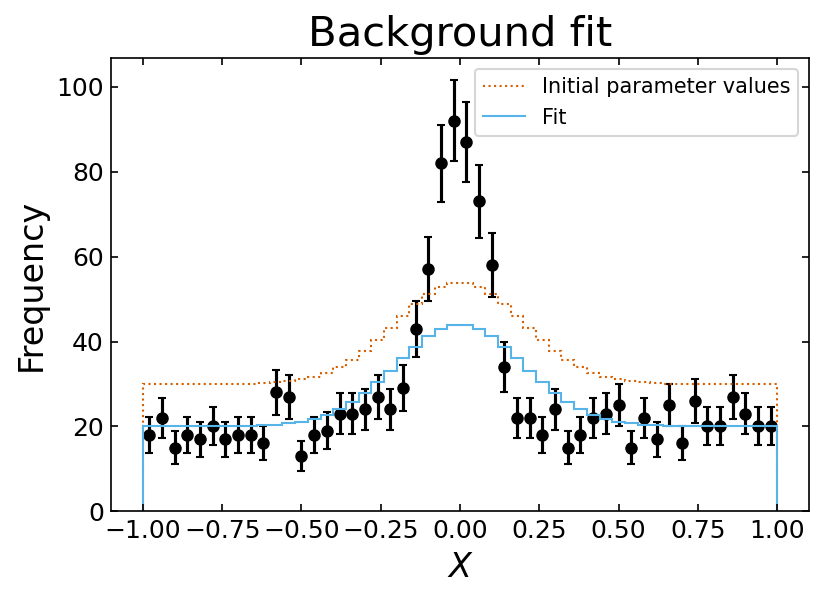

In [114]:
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.errorbar(x_bin_centre, n, n**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
ax.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe, ls=':',label='Initial parameter values',zorder = 1,color='#D55E00')
ax.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label='Fit',zorder = 1,color='#56B4E9')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.set_title('Background fit',fontsize = 20)
# ax.xaxis.set_minor_locator(MultipleLocator(0.05))
# ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.legend(loc='upper right')
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

<div style="background-color:#efdff2">

We can see the background level looks about right, but obviously our signal region has not been fitted. We can now fix the background, remove the mask, and fit only the signal parameter. 

In [115]:
c.mask = None # Remove the mask of the signal region
m.fixed = False # Release all parameters
m.fixed['nbkg'] = True # Fix the background amplitude

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.86 (χ²/ndof = 0.6)      │              Nfcn = 91               │
│ EDM = 8.78e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    386    │    25     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.00e3   │  0.05e3   │            │            │    0    │         │  yes  │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig      nbkg        mu     sigma │
├───────┼─────────────────────────────────────────┤
│  nsig │       625         0  -5.29e-3 43.938e-3 │
│  nbkg │         0         0         0         0 │
│    mu │  -5.29e-3         0   3.9e-05 -0.003e-3 │
│ sigma │ 43.938e-3         0 -0.003e-3  3.29e-05 │
└───────┴─────────────────────────────────────────┘

<div style="background-color:#efdff2">

Finally, we release all of the parameters and run the fit again to get correct estimates of the uncertainty. 

In [116]:
m.fixed = None
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.74 (χ²/ndof = 0.6)      │              Nfcn = 158              │
│ EDM = 5.84e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    383    │    26     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────┐
│       │       nsig       nbkg         mu      sigma │
├───────┼─────────────────────────────────────────────┤
│  nsig │        696     -0.3e3   -6.76e-3  56.718e-3 │
│  nbkg │     -0.3e3   1.33e+03    6.76e-3 -56.713e-3 │
│    mu │   -6.76e-3    6.76e-3   3.89e-05  -0.003e-3 │
│ sigma │  56.718e-3 -56.713e-3  -0.003e-3   3.49e-05 │
└───────┴─────────────────────────────────────────────┘

<div style="background-color:#efdff2">

We can now plot the full result:

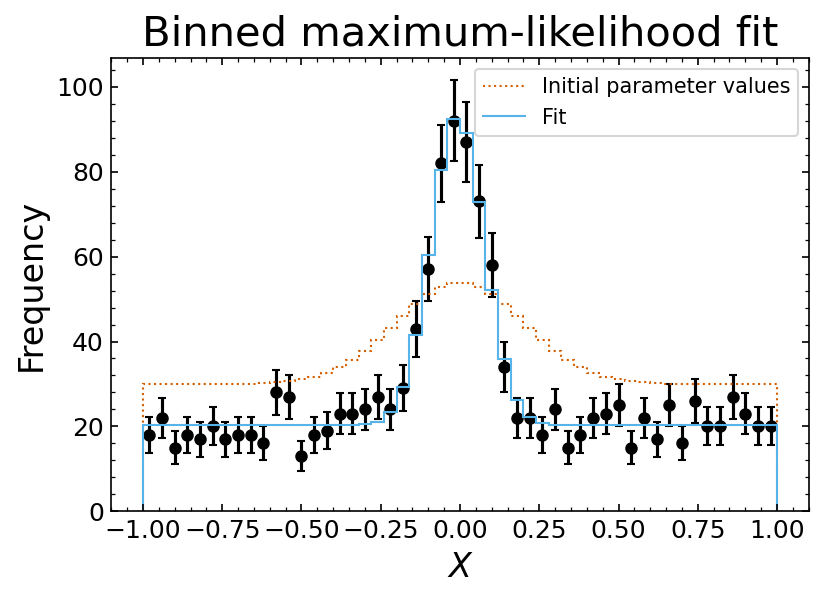

In [117]:
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.errorbar(x_bin_centre, n, n**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
ax.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe, ls=':',label='Initial parameter values',zorder = 1,color='#D55E00')
ax.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label='Fit',zorder = 1,color='#56B4E9')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.set_title('Binned maximum-likelihood fit',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.legend(loc='upper right')
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

<div style="background-color:#efdff2">

As we can see, this is exactly the same as when we did the fit all in one go. This is because we have used a simple example, but in general this can be very helpful to fit lots of histograms without having to adjust each fit manually.